In [1]:
# exp1_baseline.py
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from typing import List, Tuple

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer , OrdinalEncoder 
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score  , accuracy_score, f1_score, recall_score, precision_score


from sklearn.model_selection import cross_validate
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC , SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import pickle

from sklearn.model_selection import GridSearchCV
import time
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectFromModel
from collections import Counter
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, classification_report, confusion_matrix
)

from preprocessing import   create_preprocessing_pipeline , get_column_groups  , FeatureEngineering  , update_column_groups_after_fe 


In [2]:
df = pd.read_csv('data/train_merged.csv')



In [3]:
print("📊 SPLITTING DATA INTO TRAIN, VALIDATION, AND TEST SETS")
print("="*70)

# Step 1: Split df into train_df and test_df (80/20)
print("\n🔹 Step 1: Splitting df into train_df and test_df...")
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# First split: 80% train_df, 20% test_df
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['isFraud']
)

print(f"✅ Original dataset split complete:")
print(f"   Original:    {df.shape} - Fraud Rate: {y.mean():.4f}")
print(f"   Train_df:    {train_df.shape} - Fraud Rate: {train_df['isFraud'].mean():.4f}")
print(f"   Test_df:     {test_df.shape} - Fraud Rate: {test_df['isFraud'].mean():.4f}")

# Step 2: Split train_df into X_train and X_val (80/20 of train_df)
print("\n🔹 Step 2: Splitting train_df into X_train and X_val...")
X_train_full = train_df.drop('isFraud', axis=1)
y_train_full = train_df['isFraud']

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

print(f"✅ Train_df split complete:")
print(f"   Train Set:   {X_train.shape} - Fraud Rate: {y_train.mean():.4f}")
print(f"   Val Set:     {X_val.shape} - Fraud Rate: {y_val.mean():.4f}")

# Summary
print("\n" + "="*70)
print("📊 FINAL DATA SPLIT SUMMARY")
print("="*70)
print(f"   Original Dataset:  {df.shape}")
print(f"   ├─ Train_df:       {train_df.shape} ({len(train_df)/len(df)*100:.1f}%)")
print(f"   │  ├─ X_train:     {X_train.shape} ({len(X_train)/len(df)*100:.1f}%)")
print(f"   │  └─ X_val:       {X_val.shape} ({len(X_val)/len(df)*100:.1f}%)")
print(f"   └─ Test_df:        {test_df.shape} ({len(test_df)/len(df)*100:.1f}%)")
print(f"\n   Fraud Rates:")
print(f"   ├─ Train:          {y_train.mean():.4f}")
print(f"   ├─ Validation:     {y_val.mean():.4f}")
print(f"   └─ Test:           {test_df['isFraud'].mean():.4f}")
print(f"\n✅ Data splitting completed!")
print(f"   📝 Note: test_df is kept completely separate for final evaluation")

📊 SPLITTING DATA INTO TRAIN, VALIDATION, AND TEST SETS

🔹 Step 1: Splitting df into train_df and test_df...
✅ Original dataset split complete:
   Original:    (590540, 434) - Fraud Rate: 0.0350
   Train_df:    (472432, 434) - Fraud Rate: 0.0350
   Test_df:     (118108, 434) - Fraud Rate: 0.0350

🔹 Step 2: Splitting train_df into X_train and X_val...
✅ Original dataset split complete:
   Original:    (590540, 434) - Fraud Rate: 0.0350
   Train_df:    (472432, 434) - Fraud Rate: 0.0350
   Test_df:     (118108, 434) - Fraud Rate: 0.0350

🔹 Step 2: Splitting train_df into X_train and X_val...
✅ Train_df split complete:
   Train Set:   (377945, 433) - Fraud Rate: 0.0350
   Val Set:     (94487, 433) - Fraud Rate: 0.0350

📊 FINAL DATA SPLIT SUMMARY
   Original Dataset:  (590540, 434)
   ├─ Train_df:       (472432, 434) (80.0%)
   │  ├─ X_train:     (377945, 433) (64.0%)
   │  └─ X_val:       (94487, 433) (16.0%)
   └─ Test_df:        (118108, 434) (20.0%)

   Fraud Rates:
   ├─ Train:        

In [4]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
) 

print("✅ Data Split Complete:")
print(f"   Original:    {X.shape} - Fraud Rate: {y.mean():.4f}")
print(f"   Train Set:   {X_train.shape} - Fraud Rate: {y_train.mean():.4f}")
print(f"   Val Set:     {X_val.shape} - Fraud Rate: {y_val.mean():.4f}")

# Load test data
test_df = pd.read_csv('data/test_debug.csv')
print(f"\n   Test Set:    {test_df.shape}")

✅ Data Split Complete:
   Original:    (590540, 433) - Fraud Rate: 0.0350
   Train Set:   (472432, 433) - Fraud Rate: 0.0350
   Val Set:     (118108, 433) - Fraud Rate: 0.0350

   Test Set:    (2953, 434)


# Preprocessing Data

In [5]:
# Step 1: Get column groups từ TRAIN set
col_groups = get_column_groups(pd.concat([X_train, y_train], axis=1))

# Step 2: Fit Feature Engineering trên TRAIN set
X_train_sample = X_train.head(1000)
fe_transformer = FeatureEngineering()
fe_transformer.fit(X_train_sample, y_train.head(1000))
col_groups_fe = update_column_groups_after_fe(X_train_sample, fe_transformer, col_groups)

print("✅ Column groups updated after Feature Engineering:")
print(f"  Original features: {len(col_groups['num_cols']) + len(col_groups['cat_cols'])}")
print(f"  After FE: {len(col_groups_fe['num_cols']) + len(col_groups_fe['cat_cols'])}")
print(f"  New features created: {(len(col_groups_fe['num_cols']) + len(col_groups_fe['cat_cols'])) - (len(col_groups['num_cols']) + len(col_groups['cat_cols']))}")

✅ Column groups updated after Feature Engineering:
  Original features: 433
  After FE: 509
  New features created: 76


In [6]:
lgbm_selector = SelectFromModel(
    lgb.LGBMClassifier(n_estimators=200, random_state=42, verbose=-1),
    threshold="mean"
)

full_preprocessing_pipeline = create_preprocessing_pipeline(
    col_groups_fe,
    include_fe=True,
    include_smote=True,
    feature_selector=lgbm_selector,
    smote_strategy=0.3
)


print("🎯 Full Preprocessing Pipeline Created!")
print("\n📋 Pipeline Steps:")
for i, (name, transformer) in enumerate(full_preprocessing_pipeline.steps, 1):
    print(f"  {i}. {name}: {type(transformer).__name__}")

🎯 Full Preprocessing Pipeline Created!

📋 Pipeline Steps:
  1. feature_engineering: FeatureEngineering
  2. custom_imputer: CustomImputer
  3. outlier_clipper: OutlierClipper
  4. log_transformer: LogTransformer
  5. column_transformer: ColumnTransformer
  6. feature_selector: SelectFromModel
  7. smote: SMOTE


In [7]:

print("🔄 Transforming data with full preprocessing pipeline...")
print("="*70)

print("\n1️⃣ Processing TRAIN set (with SMOTE)...")
X_train_processed, y_train_processed = full_preprocessing_pipeline.fit_resample(X_train, y_train)

print(f"✅ Train set processed:")
print(f"   Original shape: {X_train.shape}")
print(f"   Processed shape: {X_train_processed.shape}")
print(f"   Original class distribution: {dict(y_train.value_counts())}")
print(f"   After SMOTE distribution: {dict(pd.Series(y_train_processed).value_counts())}")

print("\n2️⃣ Processing VALIDATION set (without SMOTE)...")

val_preprocessing_pipeline = create_preprocessing_pipeline(
    col_groups_fe,
    include_fe=True,
    include_smote=False,  
    feature_selector=lgbm_selector,
    smote_strategy=None
)

val_preprocessing_pipeline.fit(X_train, y_train)
X_val_processed = val_preprocessing_pipeline.transform(X_val)

print(f"✅ Validation set processed:")
print(f"   Original shape: {X_val.shape}")
print(f"   Processed shape: {X_val_processed.shape}")
print(f"   Class distribution: {dict(y_val.value_counts())} (unchanged)")

print("\n📊 Processing Summary:")
print(f"   Features: {X_train.shape[1]} → {X_train_processed.shape[1]}")
print(f"   Train samples: {len(y_train)} → {len(y_train_processed)}")
print(f"   Val samples: {len(y_val)} (unchanged)")
print(f"   Train fraud ratio: {y_train.mean()*100:.2f}% → {pd.Series(y_train_processed).mean()*100:.2f}%")
print(f"   Val fraud ratio: {y_val.mean()*100:.2f}% (unchanged)")

🔄 Transforming data with full preprocessing pipeline...

1️⃣ Processing TRAIN set (with SMOTE)...
✅ Train set processed:
   Original shape: (472432, 433)
   Processed shape: (592672, 114)
   Original class distribution: {0: np.int64(455902), 1: np.int64(16530)}
   After SMOTE distribution: {0: np.int64(455902), 1: np.int64(136770)}

2️⃣ Processing VALIDATION set (without SMOTE)...
✅ Train set processed:
   Original shape: (472432, 433)
   Processed shape: (592672, 114)
   Original class distribution: {0: np.int64(455902), 1: np.int64(16530)}
   After SMOTE distribution: {0: np.int64(455902), 1: np.int64(136770)}

2️⃣ Processing VALIDATION set (without SMOTE)...
✅ Validation set processed:
   Original shape: (118108, 433)
   Processed shape: (118108, 114)
   Class distribution: {0: np.int64(113975), 1: np.int64(4133)} (unchanged)

📊 Processing Summary:
   Features: 433 → 114
   Train samples: 472432 → 592672
   Val samples: 118108 (unchanged)
   Train fraud ratio: 3.50% → 23.08%
   Val 

# LOGISTIC REGRESSION 

## Base line training experiment

In [8]:
# ===================================
# LOGISTIC REGRESSION - BASELINE
# ===================================


print("🚀 Training Baseline Logistic Regression Model")
print("="*70)

baseline_lr = LogisticRegression(
    C=1.0,                      # Regularization strength (inverse)
    penalty='l2',               # L2 regularization
    solver='lbfgs',             # Optimization algorithm
    max_iter=1000,              # Maximum iterations
    class_weight='balanced',    # Auto-adjust weights for imbalanced data
    random_state=42,            # Reproducibility
    multi_class='ovr',          # One-vs-Rest strategy
    n_jobs=-1,                  # Use all CPU cores
    verbose=1                   # Show training progress
)


print("\n🔄 Training on processed train set...")
print(f"   Train samples: {len(y_train_processed):,}")
print(f"   Features: {X_train_processed.shape[1]}")
print(f"   Class distribution after SMOTE: {dict(pd.Series(y_train_processed).value_counts())}")

baseline_lr.fit(X_train_processed, y_train_processed)
print("✅ Training completed!")

print("\n🔮 Making predictions on validation set...")
print(f"   Val samples: {len(y_val):,}")
print(f"   Features: {X_val_processed.shape[1]}")

y_val_pred = baseline_lr.predict(X_val_processed)
y_val_pred_proba = baseline_lr.predict_proba(X_val_processed)[:, 1]

# Tính metrics
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, zero_division=0)
val_recall = recall_score(y_val, y_val_pred, zero_division=0)
val_f1 = f1_score(y_val, y_val_pred, zero_division=0)

# In kết quả baseline
print("\n" + "="*70)
print("📊 BASELINE MODEL PERFORMANCE ON VALIDATION SET")
print("="*70)
print(f"   ROC-AUC:   {val_roc_auc:.4f}")
print(f"   Accuracy:  {val_accuracy:.4f}")
print(f"   Precision: {val_precision:.4f}")
print(f"   Recall:    {val_recall:.4f}")
print(f"   F1-Score:  {val_f1:.4f}")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Normal', 'Fraud']))

# Confusion Matrix
print("\n🔢 Confusion Matrix:")
cm = confusion_matrix(y_val, y_val_pred)
print(f"   True Negatives:  {cm[0,0]:,}")
print(f"   False Positives: {cm[0,1]:,}")
print(f"   False Negatives: {cm[1,0]:,}")
print(f"   True Positives:  {cm[1,1]:,}")

# Fraud Detection Metrics
if (cm[1,0] + cm[1,1]) > 0:
    fraud_detection_rate = cm[1,1] / (cm[1,0] + cm[1,1]) * 100
else:
    fraud_detection_rate = 0.0

if (cm[0,0] + cm[0,1]) > 0:
    false_alarm_rate = cm[0,1] / (cm[0,0] + cm[0,1]) * 100
else:
    false_alarm_rate = 0.0

print(f"\n📈 Detection Metrics:")
print(f"   Fraud Detection Rate: {fraud_detection_rate:.2f}% (Recall)")
print(f"   False Alarm Rate: {false_alarm_rate:.2f}%")

# Model coefficients info
print(f"\n🔍 Model Information:")
print(f"   Number of features: {X_train_processed.shape[1]}")
print(f"   Number of coefficients: {len(baseline_lr.coef_[0])}")
print(f"   Intercept: {baseline_lr.intercept_[0]:.4f}")
print(f"   Iterations: {baseline_lr.n_iter_[0]}")

# Lưu baseline results để so sánh sau
baseline_results = {
    'model': 'Logistic Regression (Baseline)',
    'params': {
        'C': 1.0,
        'penalty': 'l2',
        'solver': 'lbfgs',
        'class_weight': 'balanced'
    },
    'metrics': {
        'roc_auc': val_roc_auc,
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1
    },
    'confusion_matrix': cm,
    'n_features': X_train_processed.shape[1],
    'n_iterations': baseline_lr.n_iter_[0]
}

print("\n✅ Baseline model evaluation completed!")
print("📝 Results saved for comparison with tuned model")

🚀 Training Baseline Logistic Regression Model

🔄 Training on processed train set...
   Train samples: 592,672
   Features: 114
   Class distribution after SMOTE: {0: np.int64(455902), 1: np.int64(136770)}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


✅ Training completed!

🔮 Making predictions on validation set...
   Val samples: 118,108
   Features: 114

📊 BASELINE MODEL PERFORMANCE ON VALIDATION SET
   ROC-AUC:   0.7654
   Accuracy:  0.7570
   Precision: 0.0899
   Recall:    0.6516
   F1-Score:  0.1580

📋 Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.76      0.86    113975
       Fraud       0.09      0.65      0.16      4133

    accuracy                           0.76    118108
   macro avg       0.54      0.71      0.51    118108
weighted avg       0.95      0.76      0.83    118108


🔢 Confusion Matrix:
   True Negatives:  86,716
   False Positives: 27,259
   False Negatives: 1,440
   True Positives:  2,693

📈 Detection Metrics:
   Fraud Detection Rate: 65.16% (Recall)
   False Alarm Rate: 23.92%

🔍 Model Information:
   Number of features: 114
   Number of coefficients: 114
   Intercept: -0.0000
   Iterations: 1000

✅ Baseline model evaluation completed!
📝 Result

📊 Creating Performance Visualizations for Baseline Model


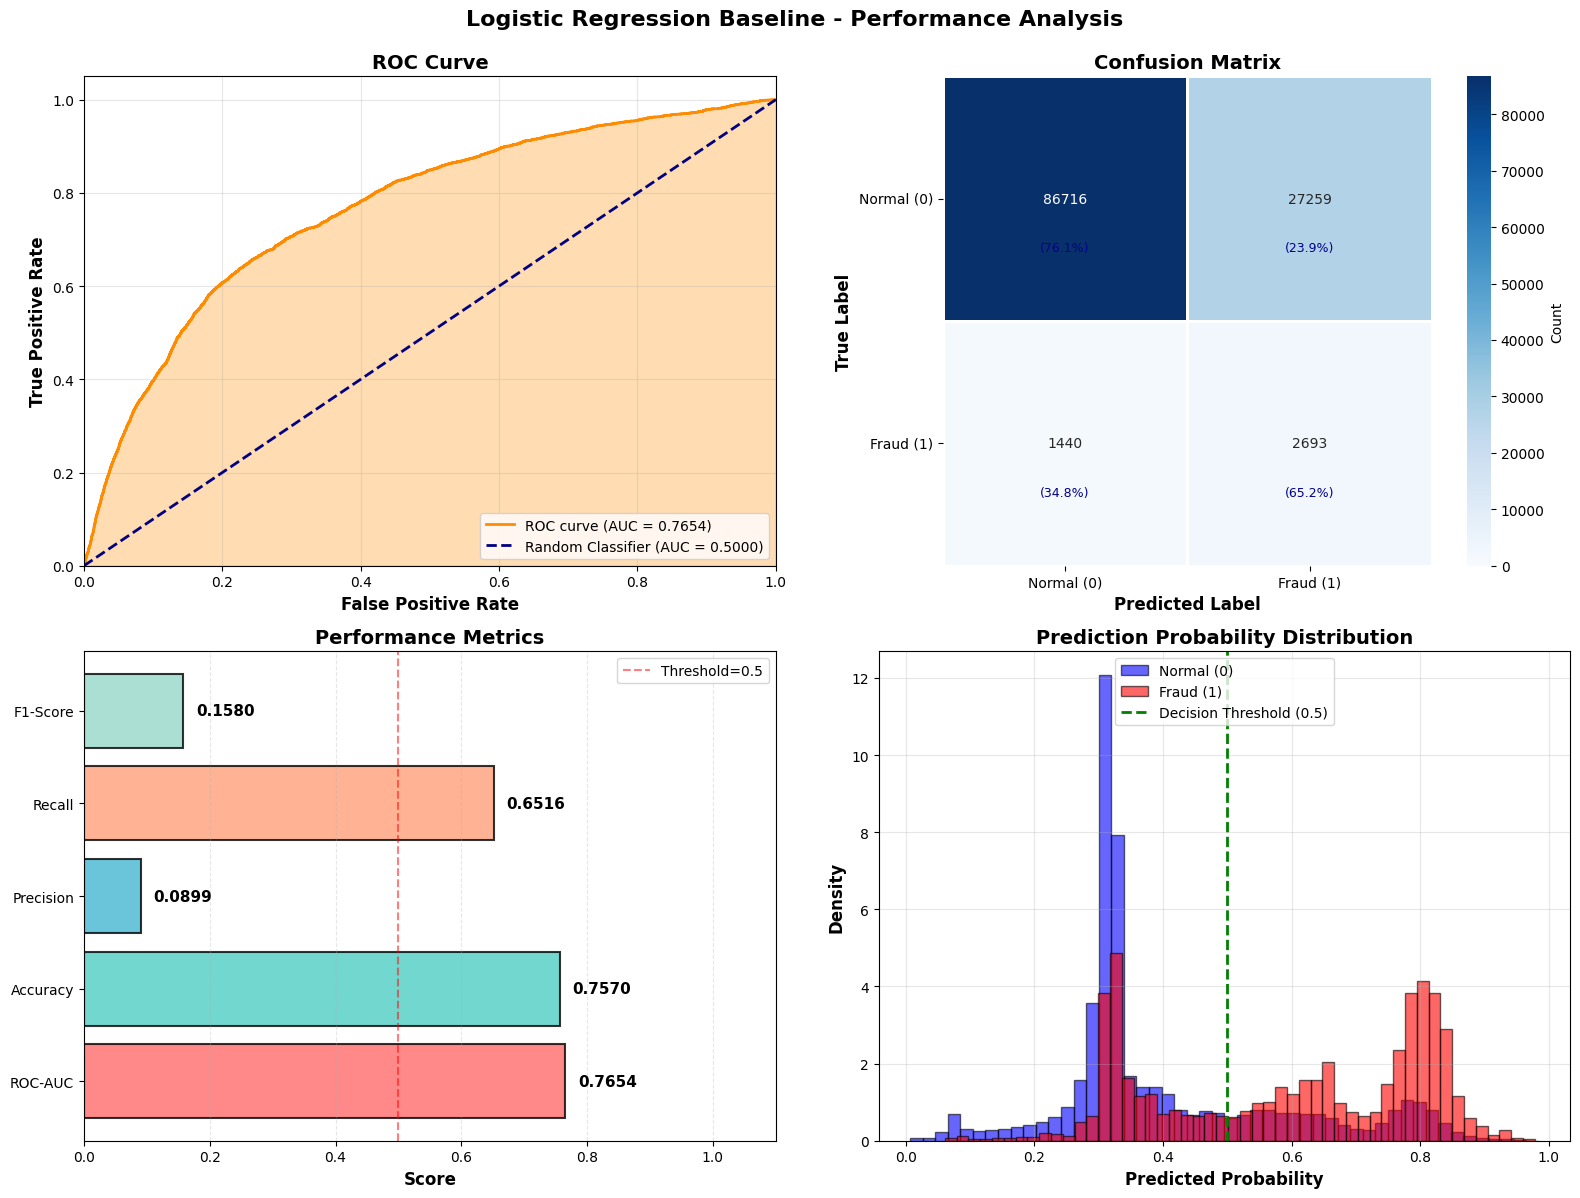


✅ Baseline model visualization completed!


In [9]:
# ===================================
# VISUALIZE BASELINE MODEL PERFORMANCE
# ===================================

from sklearn.metrics import roc_curve, auc

print("📊 Creating Performance Visualizations for Baseline Model")
print("="*70)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Logistic Regression Baseline - Performance Analysis', fontsize=16, fontweight='bold', y=0.995)

# ========================================
# 1. ROC-AUC Curve
# ========================================
ax1 = axes[0, 0]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.5000)')

# Fill area under curve
ax1.fill_between(fpr, tpr, alpha=0.3, color='darkorange')

# Styling
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right", fontsize=10)
ax1.grid(True, alpha=0.3)

# ========================================
# 2. Confusion Matrix Heatmap
# ========================================
ax2 = axes[0, 1]

# Create confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, 
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='white',
            square=True, vmin=0)

# Add percentage annotations
for i in range(2):
    for j in range(2):
        text = ax2.text(j+0.5, i+0.7, f'({cm_normalized[i, j]*100:.1f}%)',
                       ha="center", va="center", color="darkblue", fontsize=9)

ax2.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_xticklabels(['Normal (0)', 'Fraud (1)'], fontsize=10)
ax2.set_yticklabels(['Normal (0)', 'Fraud (1)'], fontsize=10, rotation=0)

# ========================================
# 3. Performance Metrics Bar Chart
# ========================================
ax3 = axes[1, 0]

metrics_names = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [val_roc_auc, val_accuracy, val_precision, val_recall, val_f1]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

bars = ax3.barh(metrics_names, metrics_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, metrics_values)):
    width = bar.get_width()
    ax3.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{value:.4f}', ha='left', va='center', fontsize=11, fontweight='bold')

ax3.set_xlim([0, 1.1])
ax3.set_xlabel('Score', fontsize=12, fontweight='bold')
ax3.set_title('Performance Metrics', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3, linestyle='--')
ax3.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold=0.5')
ax3.legend()

# ========================================
# 4. Prediction Distribution
# ========================================
ax4 = axes[1, 1]

# Separate predictions by actual class
y_val_pred_proba_0 = y_val_pred_proba[y_val == 0]  # Normal transactions
y_val_pred_proba_1 = y_val_pred_proba[y_val == 1]  # Fraud transactions

# Plot histograms
ax4.hist(y_val_pred_proba_0, bins=50, alpha=0.6, label='Normal (0)', 
         color='blue', edgecolor='black', density=True)
ax4.hist(y_val_pred_proba_1, bins=50, alpha=0.6, label='Fraud (1)', 
         color='red', edgecolor='black', density=True)

# Add vertical line at 0.5 threshold
ax4.axvline(x=0.5, color='green', linestyle='--', linewidth=2, 
           label='Decision Threshold (0.5)')

ax4.set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
ax4.set_ylabel('Density', fontsize=12, fontweight='bold')
ax4.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
ax4.legend(loc='upper center', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Baseline model visualization completed!")

## Hyper tunning params 

In [10]:


print("🔧 Hyperparameter Tuning for Logistic Regression")
print("="*70)

# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],               # Regularization type
    'solver': ['lbfgs', 'saga'],       # Optimizers that support L1
    'class_weight': [None, 'balanced'],    # Class weighting
    'max_iter': [1000, 2000]               # Max iterations
}

print("\n📋 Tuning Configuration:")
print(f"   Parameter Grid:")
print(f"   - C: {param_grid['C']}")
print(f"   - penalty: {param_grid['penalty']}")
print(f"   - solver: {param_grid['solver']}")
print(f"   - class_weight: {param_grid['class_weight']}")
print(f"   - max_iter: {param_grid['max_iter']}")
print(f"\n   Total combinations: {len(param_grid['C']) * len(param_grid['penalty']) * len(param_grid['solver']) * len(param_grid['class_weight']) * len(param_grid['max_iter'])}")

# Initialize model for tuning
lr_tuning = LogisticRegression(
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=lr_tuning,
    param_grid=param_grid,
    cv=3,                          # 5-fold cross-validation
    scoring='roc_auc',            # Optimize for ROC-AUC
    n_jobs=-1,                    # Use all CPU cores
    verbose=2,                    # Show progress
    return_train_score=True
)

print("\n🔄 Starting Grid Search (this may take a while)...")
print(f"   Using 5-fold cross-validation on validation set")
print(f"   Scoring metric: ROC-AUC")

start_time = time.time()

# Perform grid search on VALIDATION set
grid_search.fit(X_val_processed, y_val)

elapsed_time = time.time() - start_time

print(f"\n✅ Grid Search completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

# Best parameters
print("\n" + "="*70)
print("🏆 BEST HYPERPARAMETERS")
print("="*70)
print(f"Best parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"   - {param}: {value}")
print(f"\nBest CV ROC-AUC Score: {grid_search.best_score_:.4f}")

# Get detailed results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Top 10 combinations
print("\n📊 Top 10 Parameter Combinations:")
print("-"*70)
top_10 = cv_results.nlargest(10, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'mean_fit_time']
]
for idx, row in top_10.iterrows():
    print(f"\nRank {idx+1}:")
    print(f"   Params: {row['params']}")
    print(f"   Mean ROC-AUC: {row['mean_test_score']:.4f} (+/- {row['std_test_score']*2:.4f})")
    print(f"   Fit time: {row['mean_fit_time']:.2f}s")

# Save tuning results
tuning_results = {
    'best_params': grid_search.best_params_,
    'best_score': grid_search.best_score_,
    'cv_results': cv_results,
    'elapsed_time': elapsed_time
}

print("\n✅ Hyperparameter tuning completed!")

🔧 Hyperparameter Tuning for Logistic Regression

📋 Tuning Configuration:
   Parameter Grid:
   - C: [0.001, 0.01, 0.1, 1, 10]
   - penalty: ['l1', 'l2']
   - solver: ['lbfgs', 'saga']
   - class_weight: [None, 'balanced']
   - max_iter: [1000, 2000]

   Total combinations: 80

🔄 Starting Grid Search (this may take a while)...
   Using 5-fold cross-validation on validation set
   Scoring metric: ROC-AUC
Fitting 3 folds for each of 80 candidates, totalling 240 fits

✅ Grid Search completed in 2873.05 seconds (47.88 minutes)

🏆 BEST HYPERPARAMETERS
Best parameters found:
   - C: 0.01
   - class_weight: balanced
   - max_iter: 2000
   - penalty: l2
   - solver: lbfgs

Best CV ROC-AUC Score: 0.7867

📊 Top 10 Parameter Combinations:
----------------------------------------------------------------------

Rank 31:
   Params: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
   Mean ROC-AUC: 0.7867 (+/- 0.0169)
   Fit time: 49.99s

Rank 79:
   Params:

In [11]:
# ===================================
# TRAIN BEST MODEL WITH TUNED PARAMETERS
# ===================================

print("🚀 Training Best Model with Tuned Parameters")
print("="*70)

# Initialize best model
best_lr = LogisticRegression(
    **grid_search.best_params_,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n📋 Best Model Configuration:")
for param, value in grid_search.best_params_.items():
    print(f"   - {param}: {value}")

# Train on full processed training set
print("\n🔄 Training on full processed train set...")
print(f"   Train samples: {len(y_train_processed):,}")
print(f"   Features: {X_train_processed.shape[1]}")

best_lr.fit(X_train_processed, y_train_processed)
print("✅ Training completed!")

# Predict on validation set
print("\n🔮 Making predictions on validation set...")
y_val_pred_best = best_lr.predict(X_val_processed)
y_val_pred_proba_best = best_lr.predict_proba(X_val_processed)[:, 1]

# Calculate metrics
val_roc_auc_best = roc_auc_score(y_val, y_val_pred_proba_best)
val_accuracy_best = accuracy_score(y_val, y_val_pred_best)
val_precision_best = precision_score(y_val, y_val_pred_best, zero_division=0)
val_recall_best = recall_score(y_val, y_val_pred_best, zero_division=0)
val_f1_best = f1_score(y_val, y_val_pred_best, zero_division=0)

# Print results
print("\n" + "="*70)
print("📊 TUNED MODEL PERFORMANCE ON VALIDATION SET")
print("="*70)
print(f"   ROC-AUC:   {val_roc_auc_best:.4f}")
print(f"   Accuracy:  {val_accuracy_best:.4f}")
print(f"   Precision: {val_precision_best:.4f}")
print(f"   Recall:    {val_recall_best:.4f}")
print(f"   F1-Score:  {val_f1_best:.4f}")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_val, y_val_pred_best, target_names=['Normal', 'Fraud']))

# Confusion Matrix
print("\n🔢 Confusion Matrix:")
cm_best = confusion_matrix(y_val, y_val_pred_best)
print(f"   True Negatives:  {cm_best[0,0]:,}")
print(f"   False Positives: {cm_best[0,1]:,}")
print(f"   False Negatives: {cm_best[1,0]:,}")
print(f"   True Positives:  {cm_best[1,1]:,}")

# Detection metrics
fraud_detection_rate_best = cm_best[1,1] / (cm_best[1,0] + cm_best[1,1]) * 100
false_alarm_rate_best = cm_best[0,1] / (cm_best[0,0] + cm_best[0,1]) * 100

print(f"\n📈 Detection Metrics:")
print(f"   Fraud Detection Rate: {fraud_detection_rate_best:.2f}%")
print(f"   False Alarm Rate: {false_alarm_rate_best:.2f}%")

# Compare with baseline
print("\n" + "="*70)
print("📈 COMPARISON: BASELINE vs TUNED MODEL")
print("="*70)
print(f"{'Metric':<15} {'Baseline':<12} {'Tuned':<12} {'Improvement':<12}")
print("-"*70)
print(f"{'ROC-AUC':<15} {val_roc_auc:<12.4f} {val_roc_auc_best:<12.4f} {(val_roc_auc_best-val_roc_auc)*100:+12.2f}%")
print(f"{'Accuracy':<15} {val_accuracy:<12.4f} {val_accuracy_best:<12.4f} {(val_accuracy_best-val_accuracy)*100:+12.2f}%")
print(f"{'Precision':<15} {val_precision:<12.4f} {val_precision_best:<12.4f} {(val_precision_best-val_precision)*100:+12.2f}%")
print(f"{'Recall':<15} {val_recall:<12.4f} {val_recall_best:<12.4f} {(val_recall_best-val_recall)*100:+12.2f}%")
print(f"{'F1-Score':<15} {val_f1:<12.4f} {val_f1_best:<12.4f} {(val_f1_best-val_f1)*100:+12.2f}%")

# Save best model results
best_model_results = {
    'model': 'Logistic Regression (Tuned)',
    'params': grid_search.best_params_,
    'metrics': {
        'roc_auc': val_roc_auc_best,
        'accuracy': val_accuracy_best,
        'precision': val_precision_best,
        'recall': val_recall_best,
        'f1_score': val_f1_best
    },
    'confusion_matrix': cm_best,
    'n_features': X_train_processed.shape[1]
}

print("\n✅ Best model training and evaluation completed!")

🚀 Training Best Model with Tuned Parameters

📋 Best Model Configuration:
   - C: 0.01
   - class_weight: balanced
   - max_iter: 2000
   - penalty: l2
   - solver: lbfgs

🔄 Training on full processed train set...
   Train samples: 592,672
   Features: 114


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


✅ Training completed!

🔮 Making predictions on validation set...

📊 TUNED MODEL PERFORMANCE ON VALIDATION SET
   ROC-AUC:   0.7840
   Accuracy:  0.7889
   Precision: 0.0998
   Recall:    0.6279
   F1-Score:  0.1723

📋 Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.79      0.88    113975
       Fraud       0.10      0.63      0.17      4133

    accuracy                           0.79    118108
   macro avg       0.54      0.71      0.53    118108
weighted avg       0.95      0.79      0.85    118108


🔢 Confusion Matrix:
   True Negatives:  90,576
   False Positives: 23,399
   False Negatives: 1,538
   True Positives:  2,595

📈 Detection Metrics:
   Fraud Detection Rate: 62.79%
   False Alarm Rate: 20.53%

📈 COMPARISON: BASELINE vs TUNED MODEL
Metric          Baseline     Tuned        Improvement 
----------------------------------------------------------------------
ROC-AUC         0.7654       0.7840              +1.85%
Ac

📊 Creating ROC Curves Comparison: Baseline vs Best Model


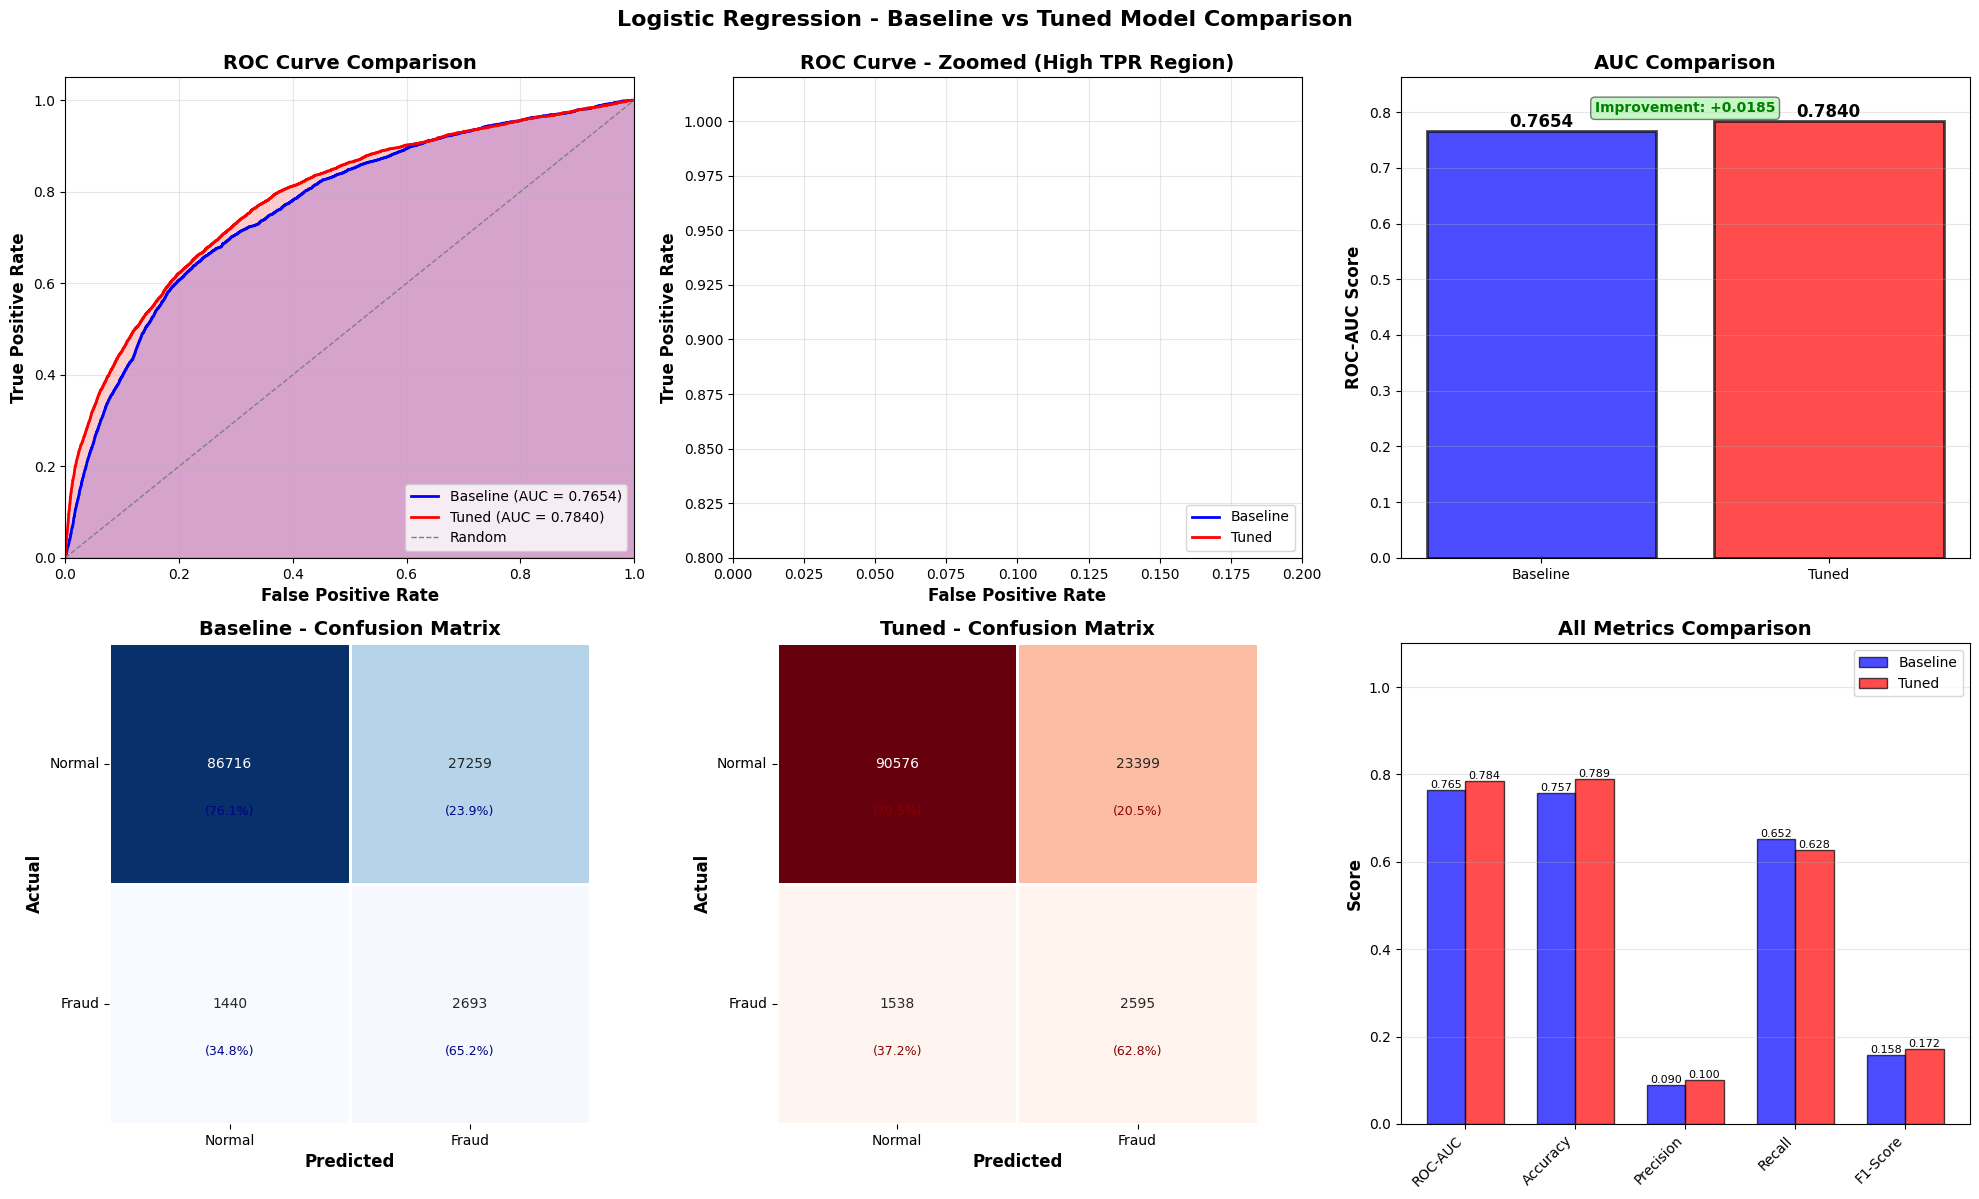


📈 Performance Improvement Summary:
Metric          Baseline     Tuned        Change         
----------------------------------------------------------------------
ROC-AUC         0.7654       0.7840              +1.85%
Accuracy        0.7570       0.7889              +3.19%
Precision       0.0899       0.0998              +0.99%
Recall          0.6516       0.6279              -2.37%
F1-Score        0.1580       0.1723              +1.43%

✅ Comparison visualization completed!


In [12]:
# ===================================
# VISUALIZE BEST MODEL vs BASELINE - ROC CURVES COMPARISON
# ===================================

print("📊 Creating ROC Curves Comparison: Baseline vs Best Model")
print("="*70)

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Logistic Regression - Baseline vs Tuned Model Comparison', 
             fontsize=16, fontweight='bold', y=0.995)

# Calculate ROC curves
fpr_base, tpr_base, _ = roc_curve(y_val, y_val_pred_proba)
fpr_best, tpr_best, _ = roc_curve(y_val, y_val_pred_proba_best)
roc_auc_base = auc(fpr_base, tpr_base)
roc_auc_best = auc(fpr_best, tpr_best)

# ========================================
# 1. ROC Curves Comparison
# ========================================
ax1 = axes[0, 0]

ax1.plot(fpr_base, tpr_base, color='blue', lw=2, 
         label=f'Baseline (AUC = {roc_auc_base:.4f})')
ax1.plot(fpr_best, tpr_best, color='red', lw=2, 
         label=f'Tuned (AUC = {roc_auc_best:.4f})')
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Random')

ax1.fill_between(fpr_base, tpr_base, alpha=0.2, color='blue')
ax1.fill_between(fpr_best, tpr_best, alpha=0.2, color='red')

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right", fontsize=10)
ax1.grid(True, alpha=0.3)

# ========================================
# 2. Zoomed ROC Curves (High Performance Region)
# ========================================
ax2 = axes[0, 1]

ax2.plot(fpr_base, tpr_base, color='blue', lw=2, label=f'Baseline')
ax2.plot(fpr_best, tpr_best, color='red', lw=2, label=f'Tuned')

ax2.set_xlim([0, 0.2])
ax2.set_ylim([0.8, 1.02])
ax2.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax2.set_title('ROC Curve - Zoomed (High TPR Region)', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right", fontsize=10)
ax2.grid(True, alpha=0.3)

# ========================================
# 3. AUC Comparison Bar Chart
# ========================================
ax3 = axes[0, 2]

models = ['Baseline', 'Tuned']
aucs = [roc_auc_base, roc_auc_best]
colors_auc = ['blue', 'red']

bars = ax3.bar(models, aucs, color=colors_auc, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels
for bar, value in zip(bars, aucs):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add improvement annotation
improvement = roc_auc_best - roc_auc_base
ax3.text(0.5, max(aucs)*1.02, f'Improvement: +{improvement:.4f}',
        ha='center', fontsize=10, color='green', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

ax3.set_ylim([0, max(aucs)*1.1])
ax3.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax3.set_title('AUC Comparison', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# ========================================
# 4. Confusion Matrices Comparison
# ========================================
ax4 = axes[1, 0]

# Baseline confusion matrix
cm_base_norm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4, cbar=False,
            linewidths=2, linecolor='white', square=True)

for i in range(2):
    for j in range(2):
        ax4.text(j+0.5, i+0.7, f'({cm_base_norm[i, j]*100:.1f}%)',
                ha="center", va="center", color="darkblue", fontsize=9)

ax4.set_title('Baseline - Confusion Matrix', fontsize=14, fontweight='bold')
ax4.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax4.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax4.set_xticklabels(['Normal', 'Fraud'])
ax4.set_yticklabels(['Normal', 'Fraud'], rotation=0)

# ========================================
# 5. Tuned Model Confusion Matrix
# ========================================
ax5 = axes[1, 1]

cm_best_norm = cm_best / cm_best.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Reds', ax=ax5, cbar=False,
            linewidths=2, linecolor='white', square=True)

for i in range(2):
    for j in range(2):
        ax5.text(j+0.5, i+0.7, f'({cm_best_norm[i, j]*100:.1f}%)',
                ha="center", va="center", color="darkred", fontsize=9)

ax5.set_title('Tuned - Confusion Matrix', fontsize=14, fontweight='bold')
ax5.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax5.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax5.set_xticklabels(['Normal', 'Fraud'])
ax5.set_yticklabels(['Normal', 'Fraud'], rotation=0)

# ========================================
# 6. All Metrics Comparison
# ========================================
ax6 = axes[1, 2]

metrics_names = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
baseline_metrics = [val_roc_auc, val_accuracy, val_precision, val_recall, val_f1]
tuned_metrics = [val_roc_auc_best, val_accuracy_best, val_precision_best, val_recall_best, val_f1_best]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax6.bar(x - width/2, baseline_metrics, width, label='Baseline', 
                color='blue', alpha=0.7, edgecolor='black')
bars2 = ax6.bar(x + width/2, tuned_metrics, width, label='Tuned', 
                color='red', alpha=0.7, edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax6.set_ylabel('Score', fontsize=12, fontweight='bold')
ax6.set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics_names, rotation=45, ha='right')
ax6.legend(fontsize=10)
ax6.grid(axis='y', alpha=0.3)
ax6.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

# ========================================
# Summary Statistics
# ========================================
print("\n📈 Performance Improvement Summary:")
print("="*70)
print(f"{'Metric':<15} {'Baseline':<12} {'Tuned':<12} {'Change':<15}")
print("-"*70)
print(f"{'ROC-AUC':<15} {val_roc_auc:<12.4f} {val_roc_auc_best:<12.4f} {(val_roc_auc_best-val_roc_auc)*100:+12.2f}%")
print(f"{'Accuracy':<15} {val_accuracy:<12.4f} {val_accuracy_best:<12.4f} {(val_accuracy_best-val_accuracy)*100:+12.2f}%")
print(f"{'Precision':<15} {val_precision:<12.4f} {val_precision_best:<12.4f} {(val_precision_best-val_precision)*100:+12.2f}%")
print(f"{'Recall':<15} {val_recall:<12.4f} {val_recall_best:<12.4f} {(val_recall_best-val_recall)*100:+12.2f}%")
print(f"{'F1-Score':<15} {val_f1:<12.4f} {val_f1_best:<12.4f} {(val_f1_best-val_f1)*100:+12.2f}%")

print("\n✅ Comparison visualization completed!")

## Best logistic model 

In [13]:
# ===================================
# SELECT BEST LOGISTIC REGRESSION MODEL & TEST
# ===================================

print("🏆 SELECTING BEST LOGISTIC REGRESSION MODEL")
print("="*70)

# Compare ROC-AUC scores
print("\n📊 Model Selection based on Validation ROC-AUC:")
print(f"   Baseline LR:  {val_roc_auc:.4f}")
print(f"   Tuned LR:     {val_roc_auc_best:.4f}")

# Select best model
if val_roc_auc_best >= val_roc_auc:
    best_lr_model = best_lr
    best_lr_name = "Tuned Logistic Regression"
    best_lr_auc = val_roc_auc_best
    best_lr_params = grid_search.best_params_
    print(f"\n✅ Selected: {best_lr_name} (ROC-AUC: {best_lr_auc:.4f})")
else:
    best_lr_model = baseline_lr
    best_lr_name = "Baseline Logistic Regression"
    best_lr_auc = val_roc_auc
    best_lr_params = baseline_results['params']
    print(f"\n✅ Selected: {best_lr_name} (ROC-AUC: {best_lr_auc:.4f})")

print("\n" + "="*70)
print("🧪 TESTING ON TEST SET")
print("="*70)

# Load and prepare test data
print("\n📂 Loading test data...")
X_test = test_df.drop('isFraud', axis=1)
y_test = test_df['isFraud']

print(f"   Test samples: {len(y_test):,}")
print(f"   Fraud rate: {y_test.mean()*100:.2f}%")
print(f"   Class distribution: {dict(y_test.value_counts())}")

# Process test data (NO SMOTE on test!)
print("\n🔄 Processing test data...")
test_preprocessing_pipeline = create_preprocessing_pipeline(
    col_groups_fe,
    include_fe=True,
    include_smote=False,
    feature_selector=lgbm_selector,
    smote_strategy=None
)

test_preprocessing_pipeline.fit(X_train, y_train)
X_test_processed = test_preprocessing_pipeline.transform(X_test)

print(f"✅ Test set processed:")
print(f"   Original shape: {X_test.shape}")
print(f"   Processed shape: {X_test_processed.shape}")

# Make predictions
print("\n🔮 Making predictions on test set...")
y_test_pred_lr = best_lr_model.predict(X_test_processed)
y_test_pred_proba_lr = best_lr_model.predict_proba(X_test_processed)[:, 1]

# Calculate metrics
test_roc_auc_lr = roc_auc_score(y_test, y_test_pred_proba_lr)
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
test_precision_lr = precision_score(y_test, y_test_pred_lr, zero_division=0)
test_recall_lr = recall_score(y_test, y_test_pred_lr, zero_division=0)
test_f1_lr = f1_score(y_test, y_test_pred_lr, zero_division=0)

# Print results
print("\n" + "="*70)
print(f"📊 {best_lr_name.upper()} - TEST SET PERFORMANCE")
print("="*70)
print(f"   ROC-AUC:   {test_roc_auc_lr:.4f}")
print(f"   Accuracy:  {test_accuracy_lr:.4f}")
print(f"   Precision: {test_precision_lr:.4f}")
print(f"   Recall:    {test_recall_lr:.4f}")
print(f"   F1-Score:  {test_f1_lr:.4f}")

# Classification Report
print("\n📋 Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred_lr, target_names=['Normal', 'Fraud']))

# Confusion Matrix
print("\n🔢 Confusion Matrix (Test Set):")
cm_test_lr = confusion_matrix(y_test, y_test_pred_lr)
print(f"   True Negatives:  {cm_test_lr[0,0]:,}")
print(f"   False Positives: {cm_test_lr[0,1]:,}")
print(f"   False Negatives: {cm_test_lr[1,0]:,}")
print(f"   True Positives:  {cm_test_lr[1,1]:,}")

# Detection metrics
test_fraud_detection_rate_lr = cm_test_lr[1,1] / (cm_test_lr[1,0] + cm_test_lr[1,1]) * 100
test_false_alarm_rate_lr = cm_test_lr[0,1] / (cm_test_lr[0,0] + cm_test_lr[0,1]) * 100

print(f"\n📈 Detection Metrics (Test Set):")
print(f"   Fraud Detection Rate: {test_fraud_detection_rate_lr:.2f}%")
print(f"   False Alarm Rate: {test_false_alarm_rate_lr:.2f}%")

# Compare Validation vs Test
print("\n" + "="*70)
print("📊 VALIDATION vs TEST PERFORMANCE COMPARISON")
print("="*70)
print(f"{'Metric':<15} {'Validation':<12} {'Test':<12} {'Difference':<12}")
print("-"*70)
print(f"{'ROC-AUC':<15} {best_lr_auc:<12.4f} {test_roc_auc_lr:<12.4f} {(test_roc_auc_lr-best_lr_auc)*100:+12.2f}%")
print(f"{'Accuracy':<15} {val_accuracy_best if val_roc_auc_best >= val_roc_auc else val_accuracy:<12.4f} {test_accuracy_lr:<12.4f} {(test_accuracy_lr-(val_accuracy_best if val_roc_auc_best >= val_roc_auc else val_accuracy))*100:+12.2f}%")
print(f"{'Precision':<15} {val_precision_best if val_roc_auc_best >= val_roc_auc else val_precision:<12.4f} {test_precision_lr:<12.4f} {(test_precision_lr-(val_precision_best if val_roc_auc_best >= val_roc_auc else val_precision))*100:+12.2f}%")
print(f"{'Recall':<15} {val_recall_best if val_roc_auc_best >= val_roc_auc else val_recall:<12.4f} {test_recall_lr:<12.4f} {(test_recall_lr-(val_recall_best if val_roc_auc_best >= val_roc_auc else val_recall))*100:+12.2f}%")
print(f"{'F1-Score':<15} {val_f1_best if val_roc_auc_best >= val_roc_auc else val_f1:<12.4f} {test_f1_lr:<12.4f} {(test_f1_lr-(val_f1_best if val_roc_auc_best >= val_roc_auc else val_f1))*100:+12.2f}%")

# Save test results
test_lr_results = {
    'model': best_lr_name,
    'params': best_lr_params,
    'validation_metrics': {
        'roc_auc': best_lr_auc,
        'accuracy': val_accuracy_best if val_roc_auc_best >= val_roc_auc else val_accuracy,
        'precision': val_precision_best if val_roc_auc_best >= val_roc_auc else val_precision,
        'recall': val_recall_best if val_roc_auc_best >= val_roc_auc else val_recall,
        'f1_score': val_f1_best if val_roc_auc_best >= val_roc_auc else val_f1
    },
    'test_metrics': {
        'roc_auc': test_roc_auc_lr,
        'accuracy': test_accuracy_lr,
        'precision': test_precision_lr,
        'recall': test_recall_lr,
        'f1_score': test_f1_lr
    },
    'test_confusion_matrix': cm_test_lr
}

print("\n✅ Logistic Regression test evaluation completed!")

🏆 SELECTING BEST LOGISTIC REGRESSION MODEL

📊 Model Selection based on Validation ROC-AUC:
   Baseline LR:  0.7654
   Tuned LR:     0.7840

✅ Selected: Tuned Logistic Regression (ROC-AUC: 0.7840)

🧪 TESTING ON TEST SET

📂 Loading test data...
   Test samples: 2,953
   Fraud rate: 3.49%
   Class distribution: {0: np.int64(2850), 1: np.int64(103)}

🔄 Processing test data...
✅ Test set processed:
   Original shape: (2953, 433)
   Processed shape: (2953, 114)

🔮 Making predictions on test set...

📊 TUNED LOGISTIC REGRESSION - TEST SET PERFORMANCE
   ROC-AUC:   0.8062
   Accuracy:  0.7961
   Precision: 0.1095
   Recall:    0.6796
   F1-Score:  0.1887

📋 Classification Report (Test Set):
              precision    recall  f1-score   support

      Normal       0.99      0.80      0.88      2850
       Fraud       0.11      0.68      0.19       103

    accuracy                           0.80      2953
   macro avg       0.55      0.74      0.54      2953
weighted avg       0.96      0.80    

📊 Creating Test Set Performance Visualizations for Logistic Regression


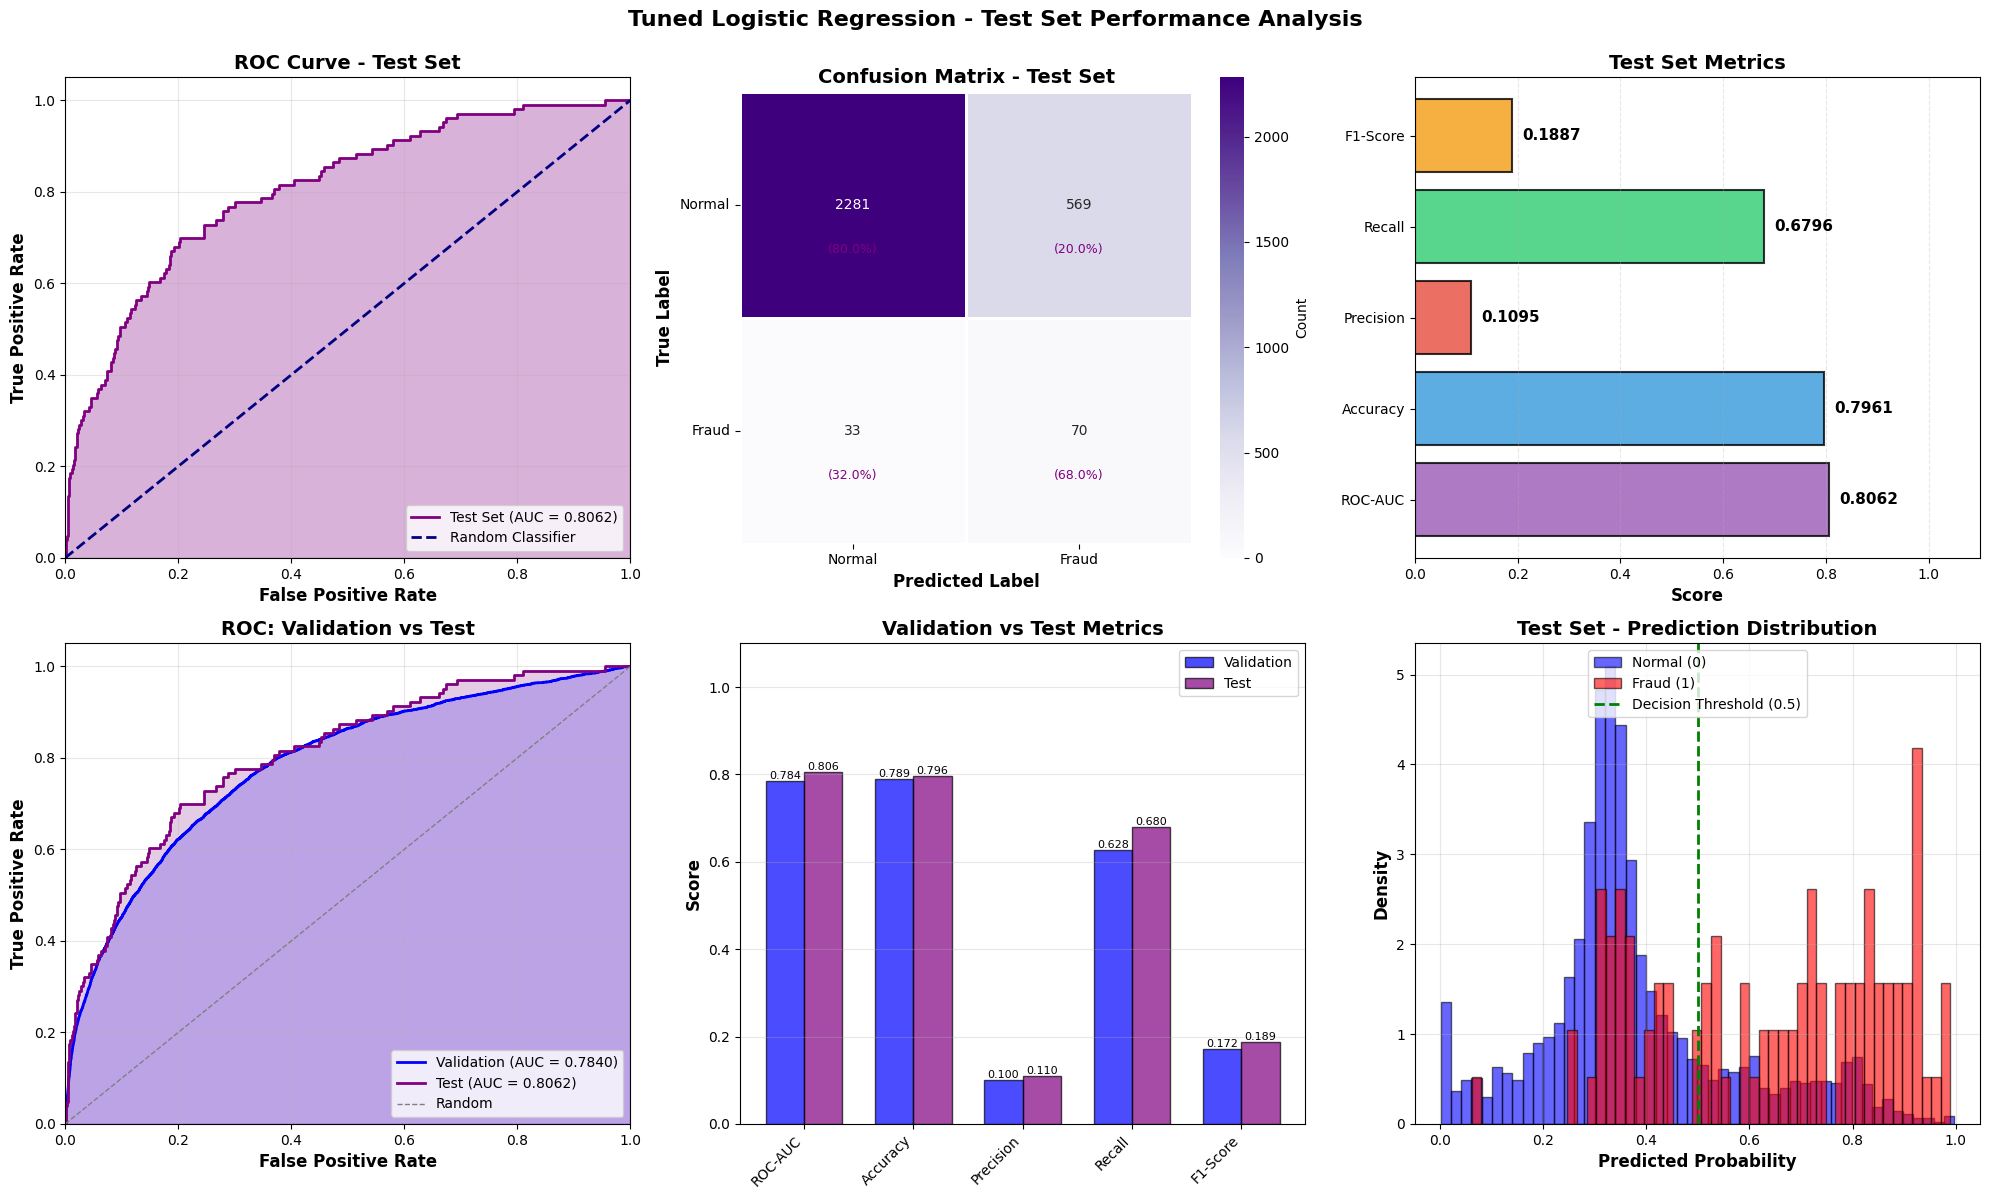


✅ Logistic Regression test visualization completed!

🎉 EXPERIMENT 1: LOGISTIC REGRESSION - COMPLETED!


In [14]:
# ===================================
# VISUALIZE LOGISTIC REGRESSION TEST RESULTS
# ===================================

print("📊 Creating Test Set Performance Visualizations for Logistic Regression")
print("="*70)

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(f'{best_lr_name} - Test Set Performance Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

# ========================================
# 1. ROC-AUC Curve (Test Set)
# ========================================
ax1 = axes[0, 0]

fpr_test_lr, tpr_test_lr, _ = roc_curve(y_test, y_test_pred_proba_lr)
roc_auc_test_lr = auc(fpr_test_lr, tpr_test_lr)

ax1.plot(fpr_test_lr, tpr_test_lr, color='purple', lw=2, 
         label=f'Test Set (AUC = {roc_auc_test_lr:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')

ax1.fill_between(fpr_test_lr, tpr_test_lr, alpha=0.3, color='purple')

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right", fontsize=10)
ax1.grid(True, alpha=0.3)

# ========================================
# 2. Confusion Matrix (Test Set)
# ========================================
ax2 = axes[0, 1]

cm_test_lr_norm = cm_test_lr.astype('float') / cm_test_lr.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_test_lr, annot=True, fmt='d', cmap='Purples', ax=ax2, 
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='white',
            square=True, vmin=0)

for i in range(2):
    for j in range(2):
        ax2.text(j+0.5, i+0.7, f'({cm_test_lr_norm[i, j]*100:.1f}%)',
                ha="center", va="center", color="purple", fontsize=9)

ax2.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_xticklabels(['Normal', 'Fraud'], fontsize=10)
ax2.set_yticklabels(['Normal', 'Fraud'], fontsize=10, rotation=0)

# ========================================
# 3. Performance Metrics (Test Set)
# ========================================
ax3 = axes[0, 2]

metrics_names_test_lr = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values_test_lr = [test_roc_auc_lr, test_accuracy_lr, test_precision_lr, test_recall_lr, test_f1_lr]
colors_test = ['#9B59B6', '#3498DB', '#E74C3C', '#2ECC71', '#F39C12']

bars_test_lr = ax3.barh(metrics_names_test_lr, metrics_values_test_lr, 
                        color=colors_test, alpha=0.8, edgecolor='black', linewidth=1.5)

for bar, value in zip(bars_test_lr, metrics_values_test_lr):
    width = bar.get_width()
    ax3.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{value:.4f}', ha='left', va='center', fontsize=11, fontweight='bold')

ax3.set_xlim([0, 1.1])
ax3.set_xlabel('Score', fontsize=12, fontweight='bold')
ax3.set_title('Test Set Metrics', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3, linestyle='--')

# ========================================
# 4. Validation vs Test ROC Comparison
# ========================================
ax4 = axes[1, 0]

# Get validation ROC
if val_roc_auc_best >= val_roc_auc:
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba_best)
else:
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)

ax4.plot(fpr_val, tpr_val, color='blue', lw=2, 
         label=f'Validation (AUC = {best_lr_auc:.4f})')
ax4.plot(fpr_test_lr, tpr_test_lr, color='purple', lw=2, 
         label=f'Test (AUC = {roc_auc_test_lr:.4f})')
ax4.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Random')

ax4.fill_between(fpr_val, tpr_val, alpha=0.2, color='blue')
ax4.fill_between(fpr_test_lr, tpr_test_lr, alpha=0.2, color='purple')

ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax4.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax4.set_title('ROC: Validation vs Test', fontsize=14, fontweight='bold')
ax4.legend(loc="lower right", fontsize=10)
ax4.grid(True, alpha=0.3)

# ========================================
# 5. Validation vs Test Metrics Comparison
# ========================================
ax5 = axes[1, 1]

val_metrics_lr = [best_lr_auc, 
                  val_accuracy_best if val_roc_auc_best >= val_roc_auc else val_accuracy,
                  val_precision_best if val_roc_auc_best >= val_roc_auc else val_precision,
                  val_recall_best if val_roc_auc_best >= val_roc_auc else val_recall,
                  val_f1_best if val_roc_auc_best >= val_roc_auc else val_f1]

x_compare = np.arange(len(metrics_names_test_lr))
width_compare = 0.35

bars_val = ax5.bar(x_compare - width_compare/2, val_metrics_lr, width_compare, 
                   label='Validation', color='blue', alpha=0.7, edgecolor='black')
bars_test = ax5.bar(x_compare + width_compare/2, metrics_values_test_lr, width_compare, 
                    label='Test', color='purple', alpha=0.7, edgecolor='black')

for bars in [bars_val, bars_test]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax5.set_ylabel('Score', fontsize=12, fontweight='bold')
ax5.set_title('Validation vs Test Metrics', fontsize=14, fontweight='bold')
ax5.set_xticks(x_compare)
ax5.set_xticklabels(metrics_names_test_lr, rotation=45, ha='right')
ax5.legend(fontsize=10)
ax5.grid(axis='y', alpha=0.3)
ax5.set_ylim([0, 1.1])

# ========================================
# 6. Prediction Distribution (Test Set)
# ========================================
ax6 = axes[1, 2]

y_test_pred_proba_lr_0 = y_test_pred_proba_lr[y_test == 0]
y_test_pred_proba_lr_1 = y_test_pred_proba_lr[y_test == 1]

ax6.hist(y_test_pred_proba_lr_0, bins=50, alpha=0.6, label='Normal (0)', 
         color='blue', edgecolor='black', density=True)
ax6.hist(y_test_pred_proba_lr_1, bins=50, alpha=0.6, label='Fraud (1)', 
         color='red', edgecolor='black', density=True)

ax6.axvline(x=0.5, color='green', linestyle='--', linewidth=2, 
           label='Decision Threshold (0.5)')

ax6.set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
ax6.set_ylabel('Density', fontsize=12, fontweight='bold')
ax6.set_title('Test Set - Prediction Distribution', fontsize=14, fontweight='bold')
ax6.legend(loc='upper center', fontsize=10)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Logistic Regression test visualization completed!")
print("\n" + "="*70)
print("🎉 EXPERIMENT 1: LOGISTIC REGRESSION - COMPLETED!")
print("="*70)

# Random Forest 

## Base line RF model

In [15]:
# ===================================
# RANDOM FOREST - BASELINE
# ===================================

from sklearn.ensemble import RandomForestClassifier

print("🚀 Training Baseline Random Forest Model")
print("="*70)

baseline_rf = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=20,               # Maximum depth of each tree
    min_samples_split=5,        # Minimum samples to split
    min_samples_leaf=3,         # Minimum samples per leaf
    max_features='sqrt',        # Features per split
    class_weight='balanced',    # Auto-adjust weights for imbalanced data
    random_state=42,            # Reproducibility
    n_jobs=-1,                  # Use all CPU cores
    verbose=1                   # Show training progress
)


print("\n🔄 Training on processed train set...")
print(f"   Train samples: {len(y_train_processed):,}")
print(f"   Features: {X_train_processed.shape[1]}")
print(f"   Class distribution after SMOTE: {dict(pd.Series(y_train_processed).value_counts())}")

baseline_rf.fit(X_train_processed, y_train_processed)
print("✅ Training completed!")

print("\n🔮 Making predictions on validation set...")
print(f"   Val samples: {len(y_val):,}")
print(f"   Features: {X_val_processed.shape[1]}")

y_val_pred_rf = baseline_rf.predict(X_val_processed)
y_val_pred_proba_rf = baseline_rf.predict_proba(X_val_processed)[:, 1]

# Tính metrics
val_roc_auc_rf = roc_auc_score(y_val, y_val_pred_proba_rf)
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
val_precision_rf = precision_score(y_val, y_val_pred_rf, zero_division=0)
val_recall_rf = recall_score(y_val, y_val_pred_rf, zero_division=0)
val_f1_rf = f1_score(y_val, y_val_pred_rf, zero_division=0)

# In kết quả baseline
print("\n" + "="*70)
print("📊 BASELINE RANDOM FOREST PERFORMANCE ON VALIDATION SET")
print("="*70)
print(f"   ROC-AUC:   {val_roc_auc_rf:.4f}")
print(f"   Accuracy:  {val_accuracy_rf:.4f}")
print(f"   Precision: {val_precision_rf:.4f}")
print(f"   Recall:    {val_recall_rf:.4f}")
print(f"   F1-Score:  {val_f1_rf:.4f}")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Normal', 'Fraud']))

# Confusion Matrix
print("\n🔢 Confusion Matrix:")
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
print(f"   True Negatives:  {cm_rf[0,0]:,}")
print(f"   False Positives: {cm_rf[0,1]:,}")
print(f"   False Negatives: {cm_rf[1,0]:,}")
print(f"   True Positives:  {cm_rf[1,1]:,}")

# Fraud Detection Metrics
if (cm_rf[1,0] + cm_rf[1,1]) > 0:
    fraud_detection_rate_rf = cm_rf[1,1] / (cm_rf[1,0] + cm_rf[1,1]) * 100
else:
    fraud_detection_rate_rf = 0.0

if (cm_rf[0,0] + cm_rf[0,1]) > 0:
    false_alarm_rate_rf = cm_rf[0,1] / (cm_rf[0,0] + cm_rf[0,1]) * 100
else:
    false_alarm_rate_rf = 0.0

print(f"\n📈 Detection Metrics:")
print(f"   Fraud Detection Rate: {fraud_detection_rate_rf:.2f}% (Recall)")
print(f"   False Alarm Rate: {false_alarm_rate_rf:.2f}%")

# Model information
print(f"\n🌲 Model Information:")
print(f"   Number of trees: {baseline_rf.n_estimators}")
print(f"   Number of features: {X_train_processed.shape[1]}")
print(f"   Number of features used: {baseline_rf.n_features_in_}")
print(f"   Tree depth (max): {max([tree.get_depth() for tree in baseline_rf.estimators_])}")
print(f"   Tree depth (avg): {np.mean([tree.get_depth() for tree in baseline_rf.estimators_]):.1f}")

# Lưu baseline results
baseline_rf_results = {
    'model': 'Random Forest (Baseline)',
    'params': {
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'class_weight': 'balanced'
    },
    'metrics': {
        'roc_auc': val_roc_auc_rf,
        'accuracy': val_accuracy_rf,
        'precision': val_precision_rf,
        'recall': val_recall_rf,
        'f1_score': val_f1_rf
    },
    'confusion_matrix': cm_rf,
    'n_features': X_train_processed.shape[1]
}

print("\n✅ Baseline Random Forest evaluation completed!")
print("📝 Results saved for comparison with tuned model")

🚀 Training Baseline Random Forest Model

🔄 Training on processed train set...
   Train samples: 592,672
   Features: 114
   Class distribution after SMOTE: {0: np.int64(455902), 1: np.int64(136770)}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


✅ Training completed!

🔮 Making predictions on validation set...
   Val samples: 118,108
   Features: 114


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s



📊 BASELINE RANDOM FOREST PERFORMANCE ON VALIDATION SET
   ROC-AUC:   0.9476
   Accuracy:  0.9819
   Precision: 0.8164
   Recall:    0.6221
   F1-Score:  0.7061

📋 Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99    113975
       Fraud       0.82      0.62      0.71      4133

    accuracy                           0.98    118108
   macro avg       0.90      0.81      0.85    118108
weighted avg       0.98      0.98      0.98    118108


🔢 Confusion Matrix:
   True Negatives:  113,397
   False Positives: 578
   False Negatives: 1,562
   True Positives:  2,571

📈 Detection Metrics:
   Fraud Detection Rate: 62.21% (Recall)
   False Alarm Rate: 0.51%

🌲 Model Information:
   Number of trees: 100
   Number of features: 114
   Number of features used: 114
   Tree depth (max): 20
   Tree depth (avg): 20.0

✅ Baseline Random Forest evaluation completed!
📝 Results saved for comparison with tuned model


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.2s finished


📊 Creating Performance Visualizations for Baseline Random Forest


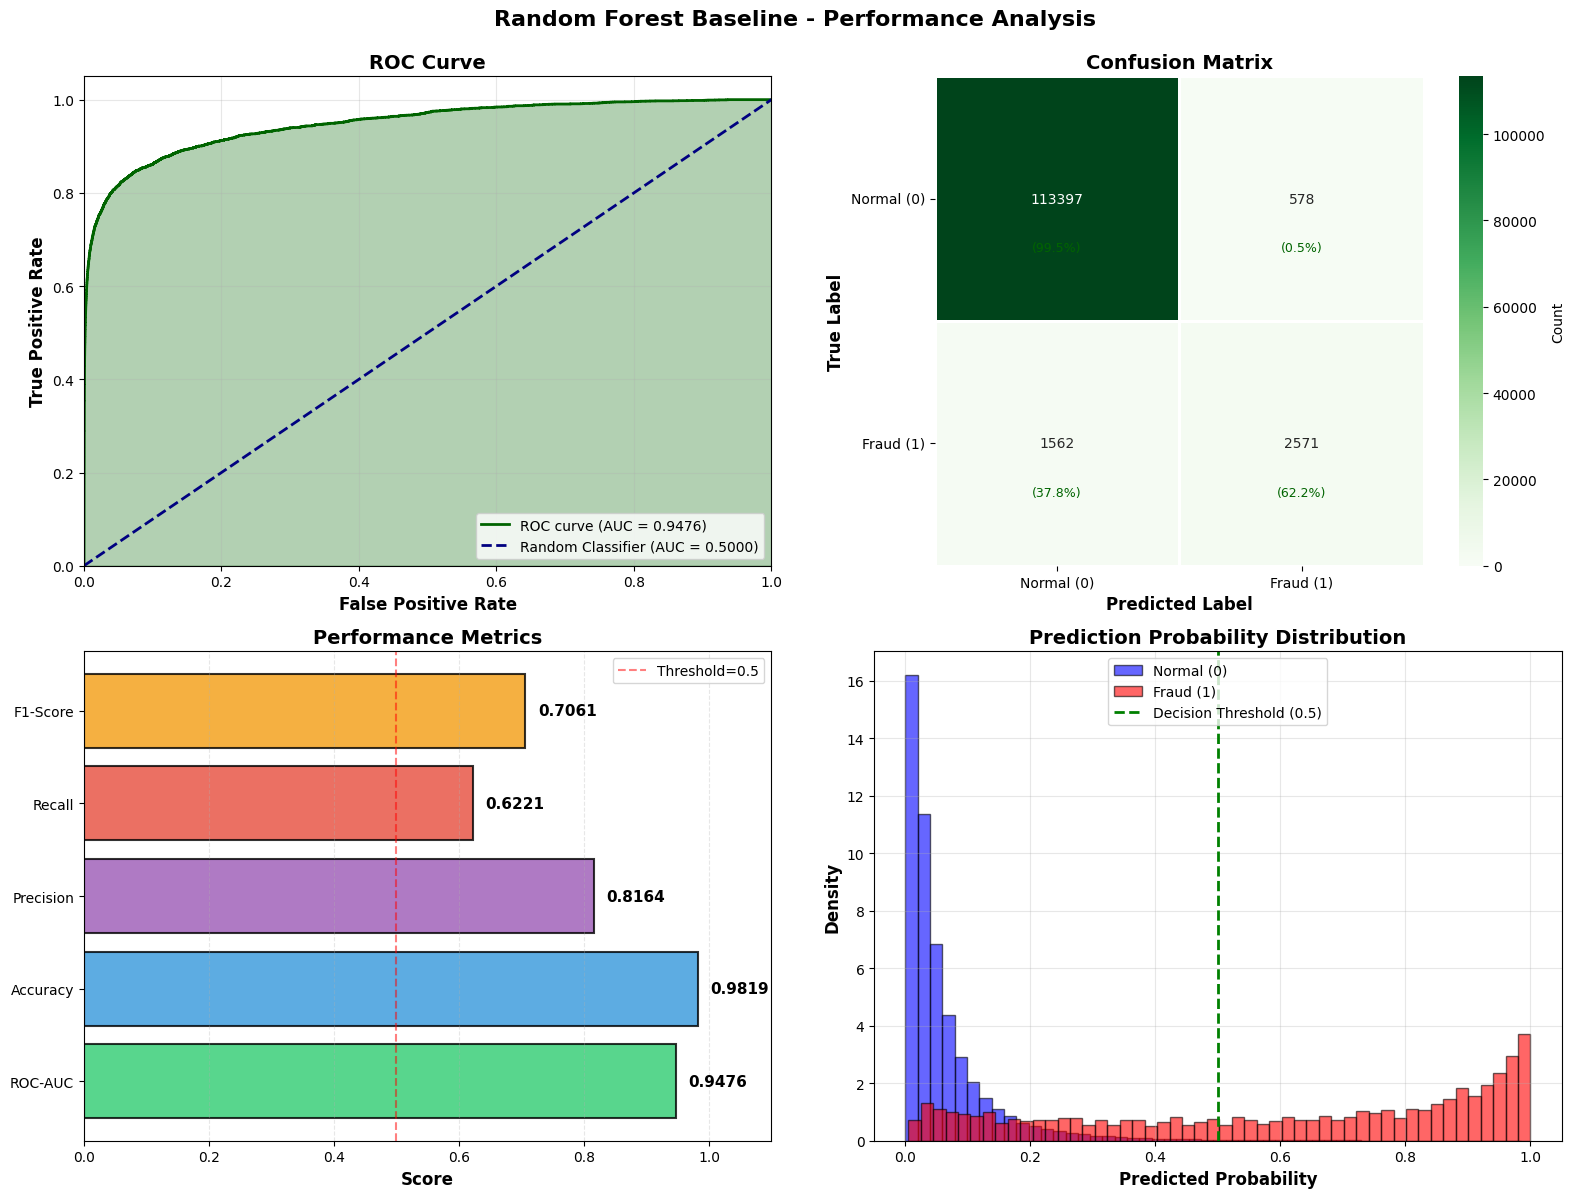


✅ Baseline Random Forest visualization completed!


In [16]:
# ===================================
# VISUALIZE RANDOM FOREST BASELINE PERFORMANCE
# ===================================

print("📊 Creating Performance Visualizations for Baseline Random Forest")
print("="*70)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Random Forest Baseline - Performance Analysis', fontsize=16, fontweight='bold', y=0.995)

# ========================================
# 1. ROC-AUC Curve
# ========================================
ax1 = axes[0, 0]

# Calculate ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, y_val_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
ax1.plot(fpr_rf, tpr_rf, color='darkgreen', lw=2, 
         label=f'ROC curve (AUC = {roc_auc_rf:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.5000)')

# Fill area under curve
ax1.fill_between(fpr_rf, tpr_rf, alpha=0.3, color='darkgreen')

# Styling
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right", fontsize=10)
ax1.grid(True, alpha=0.3)

# ========================================
# 2. Confusion Matrix Heatmap
# ========================================
ax2 = axes[0, 1]

# Create confusion matrix with percentages
cm_rf_normalized = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]

# Plot heatmap
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax2, 
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='white',
            square=True, vmin=0)

# Add percentage annotations
for i in range(2):
    for j in range(2):
        text = ax2.text(j+0.5, i+0.7, f'({cm_rf_normalized[i, j]*100:.1f}%)',
                       ha="center", va="center", color="darkgreen", fontsize=9)

ax2.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_xticklabels(['Normal (0)', 'Fraud (1)'], fontsize=10)
ax2.set_yticklabels(['Normal (0)', 'Fraud (1)'], fontsize=10, rotation=0)

# ========================================
# 3. Performance Metrics Bar Chart
# ========================================
ax3 = axes[1, 0]

metrics_names_rf = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values_rf = [val_roc_auc_rf, val_accuracy_rf, val_precision_rf, val_recall_rf, val_f1_rf]
colors_rf = ['#2ECC71', '#3498DB', '#9B59B6', '#E74C3C', '#F39C12']

bars_rf = ax3.barh(metrics_names_rf, metrics_values_rf, color=colors_rf, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars_rf, metrics_values_rf)):
    width = bar.get_width()
    ax3.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{value:.4f}', ha='left', va='center', fontsize=11, fontweight='bold')

ax3.set_xlim([0, 1.1])
ax3.set_xlabel('Score', fontsize=12, fontweight='bold')
ax3.set_title('Performance Metrics', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3, linestyle='--')
ax3.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold=0.5')
ax3.legend()

# ========================================
# 4. Prediction Distribution
# ========================================
ax4 = axes[1, 1]

# Separate predictions by actual class
y_val_pred_proba_rf_0 = y_val_pred_proba_rf[y_val == 0]  # Normal transactions
y_val_pred_proba_rf_1 = y_val_pred_proba_rf[y_val == 1]  # Fraud transactions

# Plot histograms
ax4.hist(y_val_pred_proba_rf_0, bins=50, alpha=0.6, label='Normal (0)', 
         color='blue', edgecolor='black', density=True)
ax4.hist(y_val_pred_proba_rf_1, bins=50, alpha=0.6, label='Fraud (1)', 
         color='red', edgecolor='black', density=True)

# Add vertical line at 0.5 threshold
ax4.axvline(x=0.5, color='green', linestyle='--', linewidth=2, 
           label='Decision Threshold (0.5)')

ax4.set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
ax4.set_ylabel('Density', fontsize=12, fontweight='bold')
ax4.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
ax4.legend(loc='upper center', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Baseline Random Forest visualization completed!")

## Hyper tunning params

In [17]:
# ===================================
# RANDOM FOREST - HYPERPARAMETER TUNING
# ===================================

print("🔧 Hyperparameter Tuning for Random Forest")
print("="*70)

# Define REDUCED parameter grid for faster execution
param_grid_rf = {
    'n_estimators': [50, 100, 200],           # Number of trees
    'max_depth': [  30 , 40 , 50 ],              # Tree depth
    'min_samples_split': [2, 5],              # Min samples to split
    'min_samples_leaf': [1, 2],               # Min samples per leaf
    'max_features': ['sqrt', 'log2'],         # Features per split
    'class_weight': ['balanced']              # Only balanced for imbalanced data
}

print("\n📋 Tuning Configuration (REDUCED for faster execution):")
print(f"   Parameter Grid:")
print(f"   - n_estimators: {param_grid_rf['n_estimators']}")
print(f"   - max_depth: {param_grid_rf['max_depth']}")
print(f"   - min_samples_split: {param_grid_rf['min_samples_split']}")
print(f"   - min_samples_leaf: {param_grid_rf['min_samples_leaf']}")
print(f"   - max_features: {param_grid_rf['max_features']}")
print(f"   - class_weight: {param_grid_rf['class_weight']}")

total_combinations_rf = (len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * 
                         len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf']) * 
                         len(param_grid_rf['max_features']) * len(param_grid_rf['class_weight']))
print(f"\n   Total combinations: {total_combinations_rf}")
print(f"   Estimated time: ~{total_combinations_rf * 3 * 5 / 60:.1f} minutes (with 3-fold CV)")

# Initialize model for tuning
rf_tuning = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Setup GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_tuning,
    param_grid=param_grid_rf,
    cv=3,                          # 3-fold CV for faster execution
    scoring='roc_auc',            # Optimize for ROC-AUC
    n_jobs=-1,                    # Use all CPU cores
    verbose=2,                    # Show progress
    return_train_score=True
)

print("\n🔄 Starting Grid Search...")
print(f"   Using 3-fold cross-validation on train set")
print(f"   Scoring metric: ROC-AUC")

start_time_rf = time.time()

# Perform grid search on TRAIN set
grid_search_rf.fit(X_train_processed, y_train_processed)

elapsed_time_rf = time.time() - start_time_rf

print(f"\n✅ Grid Search completed in {elapsed_time_rf:.2f} seconds ({elapsed_time_rf/60:.2f} minutes)")

# Best parameters
print("\n" + "="*70)
print("🏆 BEST HYPERPARAMETERS")
print("="*70)
print(f"Best parameters found:")
for param, value in grid_search_rf.best_params_.items():
    print(f"   - {param}: {value}")
print(f"\nBest CV ROC-AUC Score: {grid_search_rf.best_score_:.4f}")

# Get detailed results
cv_results_rf = pd.DataFrame(grid_search_rf.cv_results_)

# Top 10 combinations
print("\n📊 Top 10 Parameter Combinations:")
print("-"*70)
top_10_rf = cv_results_rf.nlargest(10, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'mean_fit_time']
]

for idx, row in top_10_rf.iterrows():
    print(f"\nRank {list(top_10_rf.index).index(idx)+1}:")
    print(f"   Params: {row['params']}")
    print(f"   Mean ROC-AUC: {row['mean_test_score']:.4f} (+/- {row['std_test_score']*2:.4f})")
    print(f"   Fit time: {row['mean_fit_time']:.2f}s")

# Save tuning results
tuning_results_rf = {
    'best_params': grid_search_rf.best_params_,
    'best_score': grid_search_rf.best_score_,
    'cv_results': cv_results_rf,
    'elapsed_time': elapsed_time_rf
}

print("\n✅ Hyperparameter tuning completed!")
print(f"💡 Best model will be trained with: {grid_search_rf.best_params_}")

🔧 Hyperparameter Tuning for Random Forest

📋 Tuning Configuration (REDUCED for faster execution):
   Parameter Grid:
   - n_estimators: [50, 100, 200]
   - max_depth: [30, 40, 50]
   - min_samples_split: [2, 5]
   - min_samples_leaf: [1, 2]
   - max_features: ['sqrt', 'log2']
   - class_weight: ['balanced']

   Total combinations: 72
   Estimated time: ~18.0 minutes (with 3-fold CV)

🔄 Starting Grid Search...
   Using 3-fold cross-validation on train set
   Scoring metric: ROC-AUC
Fitting 3 folds for each of 72 candidates, totalling 216 fits

✅ Grid Search completed in 7832.18 seconds (130.54 minutes)

🏆 BEST HYPERPARAMETERS
Best parameters found:
   - class_weight: balanced
   - max_depth: 40
   - max_features: log2
   - min_samples_leaf: 1
   - min_samples_split: 2
   - n_estimators: 200

Best CV ROC-AUC Score: 0.9948

📊 Top 10 Parameter Combinations:
----------------------------------------------------------------------

Rank 1:
   Params: {'class_weight': 'balanced', 'max_depth': 4

In [18]:
# ===================================
# TRAIN BEST RANDOM FOREST WITH TUNED PARAMETERS
# ===================================

print("🚀 Training Best Random Forest with Tuned Parameters")
print("="*70)

# Initialize best model
best_rf = RandomForestClassifier(
    **grid_search_rf.best_params_,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n📋 Best Model Configuration:")
for param, value in grid_search_rf.best_params_.items():
    print(f"   - {param}: {value}")

# Train on full processed training set
print("\n🔄 Training on full processed train set...")
print(f"   Train samples: {len(y_train_processed):,}")
print(f"   Features: {X_train_processed.shape[1]}")

best_rf.fit(X_train_processed, y_train_processed)
print("✅ Training completed!")

# Predict on validation set
print("\n🔮 Making predictions on validation set...")
y_val_pred_rf_best = best_rf.predict(X_val_processed)
y_val_pred_proba_rf_best = best_rf.predict_proba(X_val_processed)[:, 1]

# Calculate metrics
val_roc_auc_rf_best = roc_auc_score(y_val, y_val_pred_proba_rf_best)
val_accuracy_rf_best = accuracy_score(y_val, y_val_pred_rf_best)
val_precision_rf_best = precision_score(y_val, y_val_pred_rf_best, zero_division=0)
val_recall_rf_best = recall_score(y_val, y_val_pred_rf_best, zero_division=0)
val_f1_rf_best = f1_score(y_val, y_val_pred_rf_best, zero_division=0)

# Print results
print("\n" + "="*70)
print("📊 TUNED RANDOM FOREST PERFORMANCE ON VALIDATION SET")
print("="*70)
print(f"   ROC-AUC:   {val_roc_auc_rf_best:.4f}")
print(f"   Accuracy:  {val_accuracy_rf_best:.4f}")
print(f"   Precision: {val_precision_rf_best:.4f}")
print(f"   Recall:    {val_recall_rf_best:.4f}")
print(f"   F1-Score:  {val_f1_rf_best:.4f}")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_val, y_val_pred_rf_best, target_names=['Normal', 'Fraud']))

# Confusion Matrix
print("\n🔢 Confusion Matrix:")
cm_rf_best = confusion_matrix(y_val, y_val_pred_rf_best)
print(f"   True Negatives:  {cm_rf_best[0,0]:,}")
print(f"   False Positives: {cm_rf_best[0,1]:,}")
print(f"   False Negatives: {cm_rf_best[1,0]:,}")
print(f"   True Positives:  {cm_rf_best[1,1]:,}")

# Detection metrics
fraud_detection_rate_rf_best = cm_rf_best[1,1] / (cm_rf_best[1,0] + cm_rf_best[1,1]) * 100
false_alarm_rate_rf_best = cm_rf_best[0,1] / (cm_rf_best[0,0] + cm_rf_best[0,1]) * 100

print(f"\n📈 Detection Metrics:")
print(f"   Fraud Detection Rate: {fraud_detection_rate_rf_best:.2f}%")
print(f"   False Alarm Rate: {false_alarm_rate_rf_best:.2f}%")

# Model information
print(f"\n🌲 Model Information:")
print(f"   Number of trees: {best_rf.n_estimators}")
print(f"   Number of features: {X_train_processed.shape[1]}")
print(f"   Tree depth (max): {max([tree.get_depth() for tree in best_rf.estimators_])}")
print(f"   Tree depth (avg): {np.mean([tree.get_depth() for tree in best_rf.estimators_]):.1f}")

# Compare with baseline
print("\n" + "="*70)
print("📈 COMPARISON: BASELINE vs TUNED RANDOM FOREST")
print("="*70)
print(f"{'Metric':<15} {'Baseline':<12} {'Tuned':<12} {'Improvement':<12}")
print("-"*70)
print(f"{'ROC-AUC':<15} {val_roc_auc_rf:<12.4f} {val_roc_auc_rf_best:<12.4f} {(val_roc_auc_rf_best-val_roc_auc_rf)*100:+12.2f}%")
print(f"{'Accuracy':<15} {val_accuracy_rf:<12.4f} {val_accuracy_rf_best:<12.4f} {(val_accuracy_rf_best-val_accuracy_rf)*100:+12.2f}%")
print(f"{'Precision':<15} {val_precision_rf:<12.4f} {val_precision_rf_best:<12.4f} {(val_precision_rf_best-val_precision_rf)*100:+12.2f}%")
print(f"{'Recall':<15} {val_recall_rf:<12.4f} {val_recall_rf_best:<12.4f} {(val_recall_rf_best-val_recall_rf)*100:+12.2f}%")
print(f"{'F1-Score':<15} {val_f1_rf:<12.4f} {val_f1_rf_best:<12.4f} {(val_f1_rf_best-val_f1_rf)*100:+12.2f}%")

# Save best model results
best_rf_results = {
    'model': 'Random Forest (Tuned)',
    'params': grid_search_rf.best_params_,
    'metrics': {
        'roc_auc': val_roc_auc_rf_best,
        'accuracy': val_accuracy_rf_best,
        'precision': val_precision_rf_best,
        'recall': val_recall_rf_best,
        'f1_score': val_f1_rf_best
    },
    'confusion_matrix': cm_rf_best,
    'n_features': X_train_processed.shape[1]
}

print("\n✅ Best Random Forest training and evaluation completed!")

🚀 Training Best Random Forest with Tuned Parameters

📋 Best Model Configuration:
   - class_weight: balanced
   - max_depth: 40
   - max_features: log2
   - min_samples_leaf: 1
   - min_samples_split: 2
   - n_estimators: 200

🔄 Training on full processed train set...
   Train samples: 592,672
   Features: 114


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished


✅ Training completed!

🔮 Making predictions on validation set...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.7s finished



📊 TUNED RANDOM FOREST PERFORMANCE ON VALIDATION SET
   ROC-AUC:   0.9542
   Accuracy:  0.9840
   Precision: 0.9455
   Recall:    0.5751
   F1-Score:  0.7152

📋 Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99    113975
       Fraud       0.95      0.58      0.72      4133

    accuracy                           0.98    118108
   macro avg       0.97      0.79      0.85    118108
weighted avg       0.98      0.98      0.98    118108


🔢 Confusion Matrix:
   True Negatives:  113,838
   False Positives: 137
   False Negatives: 1,756
   True Positives:  2,377

📈 Detection Metrics:
   Fraud Detection Rate: 57.51%
   False Alarm Rate: 0.12%

🌲 Model Information:
   Number of trees: 200
   Number of features: 114
   Tree depth (max): 40
   Tree depth (avg): 40.0

📈 COMPARISON: BASELINE vs TUNED RANDOM FOREST
Metric          Baseline     Tuned        Improvement 
----------------------------------------------------------

📊 Creating ROC Curves Comparison: Baseline vs Best Random Forest


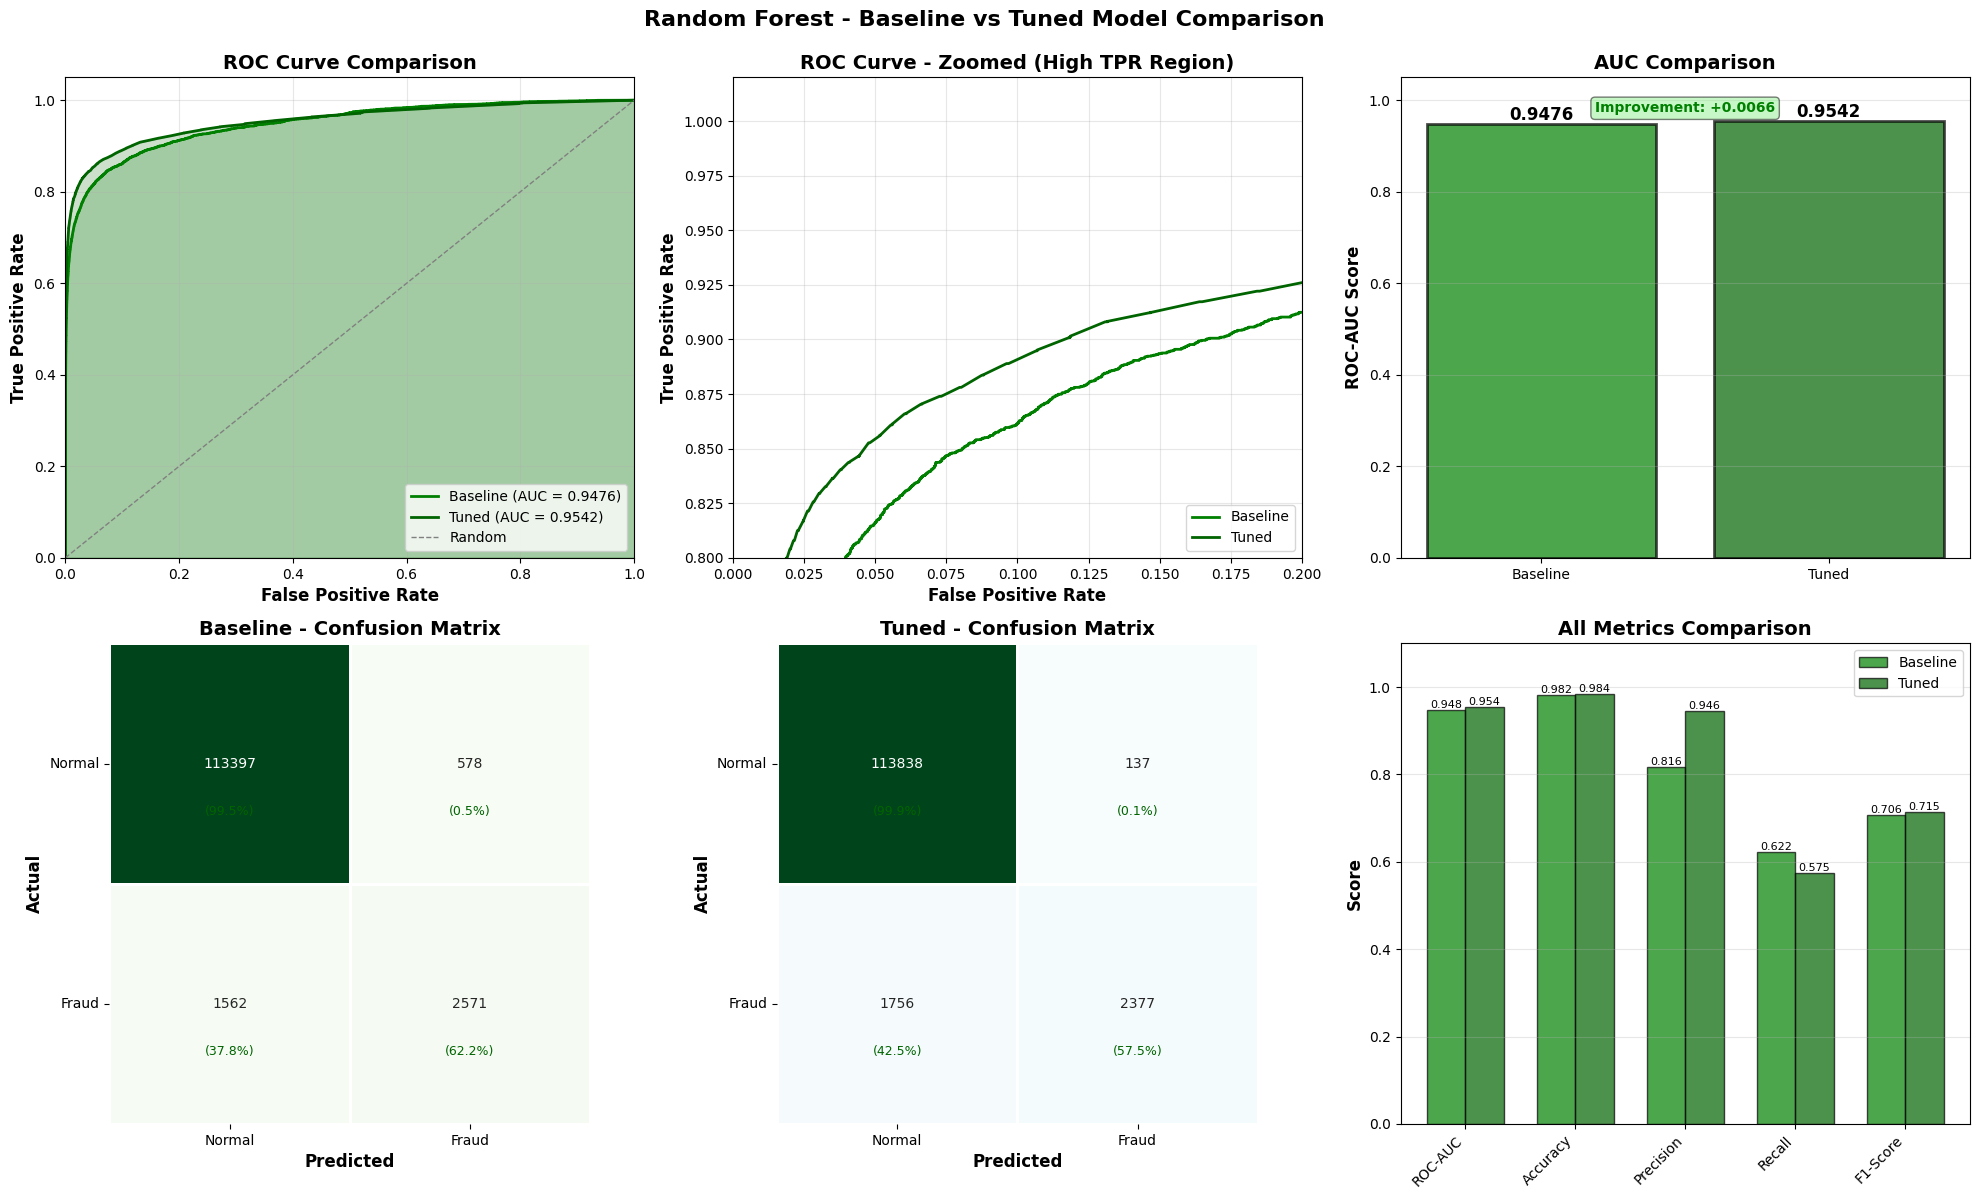


📈 Random Forest Performance Improvement Summary:
Metric          Baseline     Tuned        Change         
----------------------------------------------------------------------
ROC-AUC         0.9476       0.9542              +0.66%
Accuracy        0.9819       0.9840              +0.21%
Precision       0.8164       0.9455             +12.91%
Recall          0.6221       0.5751              -4.69%
F1-Score        0.7061       0.7152              +0.91%

✅ Random Forest comparison visualization completed!


In [19]:
# ===================================
# VISUALIZE BEST RANDOM FOREST vs BASELINE - ROC CURVES COMPARISON
# ===================================

print("📊 Creating ROC Curves Comparison: Baseline vs Best Random Forest")
print("="*70)

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Random Forest - Baseline vs Tuned Model Comparison', 
             fontsize=16, fontweight='bold', y=0.995)

# Calculate ROC curves
fpr_rf_base, tpr_rf_base, _ = roc_curve(y_val, y_val_pred_proba_rf)
fpr_rf_best, tpr_rf_best, _ = roc_curve(y_val, y_val_pred_proba_rf_best)
roc_auc_rf_base = auc(fpr_rf_base, tpr_rf_base)
roc_auc_rf_best = auc(fpr_rf_best, tpr_rf_best)

# ========================================
# 1. ROC Curves Comparison
# ========================================
ax1 = axes[0, 0]

ax1.plot(fpr_rf_base, tpr_rf_base, color='green', lw=2, 
         label=f'Baseline (AUC = {roc_auc_rf_base:.4f})')
ax1.plot(fpr_rf_best, tpr_rf_best, color='darkgreen', lw=2, 
         label=f'Tuned (AUC = {roc_auc_rf_best:.4f})')
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Random')

ax1.fill_between(fpr_rf_base, tpr_rf_base, alpha=0.2, color='green')
ax1.fill_between(fpr_rf_best, tpr_rf_best, alpha=0.2, color='darkgreen')

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right", fontsize=10)
ax1.grid(True, alpha=0.3)

# ========================================
# 2. Zoomed ROC Curves (High Performance Region)
# ========================================
ax2 = axes[0, 1]

ax2.plot(fpr_rf_base, tpr_rf_base, color='green', lw=2, label=f'Baseline')
ax2.plot(fpr_rf_best, tpr_rf_best, color='darkgreen', lw=2, label=f'Tuned')

ax2.set_xlim([0, 0.2])
ax2.set_ylim([0.8, 1.02])
ax2.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax2.set_title('ROC Curve - Zoomed (High TPR Region)', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right", fontsize=10)
ax2.grid(True, alpha=0.3)

# ========================================
# 3. AUC Comparison Bar Chart
# ========================================
ax3 = axes[0, 2]

models_rf = ['Baseline', 'Tuned']
aucs_rf = [roc_auc_rf_base, roc_auc_rf_best]
colors_rf_bar = ['green', 'darkgreen']

bars_rf_auc = ax3.bar(models_rf, aucs_rf, color=colors_rf_bar, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels
for bar, value in zip(bars_rf_auc, aucs_rf):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add improvement annotation
improvement_rf = roc_auc_rf_best - roc_auc_rf_base
ax3.text(0.5, max(aucs_rf)*1.02, f'Improvement: +{improvement_rf:.4f}',
        ha='center', fontsize=10, color='green', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

ax3.set_ylim([0, max(aucs_rf)*1.1])
ax3.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax3.set_title('AUC Comparison', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# ========================================
# 4. Baseline Confusion Matrix
# ========================================
ax4 = axes[1, 0]

cm_rf_base_norm = cm_rf / cm_rf.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax4, cbar=False,
            linewidths=2, linecolor='white', square=True)

for i in range(2):
    for j in range(2):
        ax4.text(j+0.5, i+0.7, f'({cm_rf_base_norm[i, j]*100:.1f}%)',
                ha="center", va="center", color="darkgreen", fontsize=9)

ax4.set_title('Baseline - Confusion Matrix', fontsize=14, fontweight='bold')
ax4.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax4.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax4.set_xticklabels(['Normal', 'Fraud'])
ax4.set_yticklabels(['Normal', 'Fraud'], rotation=0)

# ========================================
# 5. Tuned Model Confusion Matrix
# ========================================
ax5 = axes[1, 1]

cm_rf_best_norm = cm_rf_best / cm_rf_best.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_rf_best, annot=True, fmt='d', cmap='BuGn', ax=ax5, cbar=False,
            linewidths=2, linecolor='white', square=True)

for i in range(2):
    for j in range(2):
        ax5.text(j+0.5, i+0.7, f'({cm_rf_best_norm[i, j]*100:.1f}%)',
                ha="center", va="center", color="darkgreen", fontsize=9)

ax5.set_title('Tuned - Confusion Matrix', fontsize=14, fontweight='bold')
ax5.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax5.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax5.set_xticklabels(['Normal', 'Fraud'])
ax5.set_yticklabels(['Normal', 'Fraud'], rotation=0)

# ========================================
# 6. All Metrics Comparison
# ========================================
ax6 = axes[1, 2]

metrics_names_rf_comp = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
baseline_metrics_rf = [val_roc_auc_rf, val_accuracy_rf, val_precision_rf, val_recall_rf, val_f1_rf]
tuned_metrics_rf = [val_roc_auc_rf_best, val_accuracy_rf_best, val_precision_rf_best, val_recall_rf_best, val_f1_rf_best]

x_rf = np.arange(len(metrics_names_rf_comp))
width_rf = 0.35

bars1_rf = ax6.bar(x_rf - width_rf/2, baseline_metrics_rf, width_rf, label='Baseline', 
                   color='green', alpha=0.7, edgecolor='black')
bars2_rf = ax6.bar(x_rf + width_rf/2, tuned_metrics_rf, width_rf, label='Tuned', 
                   color='darkgreen', alpha=0.7, edgecolor='black')

# Add value labels
for bars in [bars1_rf, bars2_rf]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax6.set_ylabel('Score', fontsize=12, fontweight='bold')
ax6.set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
ax6.set_xticks(x_rf)
ax6.set_xticklabels(metrics_names_rf_comp, rotation=45, ha='right')
ax6.legend(fontsize=10)
ax6.grid(axis='y', alpha=0.3)
ax6.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

# ========================================
# Summary Statistics
# ========================================
print("\n📈 Random Forest Performance Improvement Summary:")
print("="*70)
print(f"{'Metric':<15} {'Baseline':<12} {'Tuned':<12} {'Change':<15}")
print("-"*70)
print(f"{'ROC-AUC':<15} {val_roc_auc_rf:<12.4f} {val_roc_auc_rf_best:<12.4f} {(val_roc_auc_rf_best-val_roc_auc_rf)*100:+12.2f}%")
print(f"{'Accuracy':<15} {val_accuracy_rf:<12.4f} {val_accuracy_rf_best:<12.4f} {(val_accuracy_rf_best-val_accuracy_rf)*100:+12.2f}%")
print(f"{'Precision':<15} {val_precision_rf:<12.4f} {val_precision_rf_best:<12.4f} {(val_precision_rf_best-val_precision_rf)*100:+12.2f}%")
print(f"{'Recall':<15} {val_recall_rf:<12.4f} {val_recall_rf_best:<12.4f} {(val_recall_rf_best-val_recall_rf)*100:+12.2f}%")
print(f"{'F1-Score':<15} {val_f1_rf:<12.4f} {val_f1_rf_best:<12.4f} {(val_f1_rf_best-val_f1_rf)*100:+12.2f}%")

print("\n✅ Random Forest comparison visualization completed!")

## Best random forest model 

In [20]:
# ===================================
# SELECT BEST RANDOM FOREST MODEL & TEST
# ===================================

print("🏆 SELECTING BEST RANDOM FOREST MODEL")
print("="*70)

# Compare ROC-AUC scores
print("\n📊 Model Selection based on Validation ROC-AUC:")
print(f"   Baseline RF:  {val_roc_auc_rf:.4f}")
print(f"   Tuned RF:     {val_roc_auc_rf_best:.4f}")

# Select best model
if val_roc_auc_rf_best >= val_roc_auc_rf:
    best_rf_model = best_rf
    best_rf_name = "Tuned Random Forest"
    best_rf_auc = val_roc_auc_rf_best
    best_rf_params = grid_search_rf.best_params_
    print(f"\n✅ Selected: {best_rf_name} (ROC-AUC: {best_rf_auc:.4f})")
else:
    best_rf_model = baseline_rf
    best_rf_name = "Baseline Random Forest"
    best_rf_auc = val_roc_auc_rf
    best_rf_params = baseline_rf_results['params']
    print(f"\n✅ Selected: {best_rf_name} (ROC-AUC: {best_rf_auc:.4f})")

print("\n" + "="*70)
print("🧪 TESTING ON TEST SET")
print("="*70)

# Test data already processed from LR experiment
print("\n🔮 Making predictions on test set...")
y_test_pred_rf = best_rf_model.predict(X_test_processed)
y_test_pred_proba_rf = best_rf_model.predict_proba(X_test_processed)[:, 1]

# Calculate metrics
test_roc_auc_rf = roc_auc_score(y_test, y_test_pred_proba_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_precision_rf = precision_score(y_test, y_test_pred_rf, zero_division=0)
test_recall_rf = recall_score(y_test, y_test_pred_rf, zero_division=0)
test_f1_rf = f1_score(y_test, y_test_pred_rf, zero_division=0)

# Print results
print("\n" + "="*70)
print(f"📊 {best_rf_name.upper()} - TEST SET PERFORMANCE")
print("="*70)
print(f"   ROC-AUC:   {test_roc_auc_rf:.4f}")
print(f"   Accuracy:  {test_accuracy_rf:.4f}")
print(f"   Precision: {test_precision_rf:.4f}")
print(f"   Recall:    {test_recall_rf:.4f}")
print(f"   F1-Score:  {test_f1_rf:.4f}")

# Classification Report
print("\n📋 Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred_rf, target_names=['Normal', 'Fraud']))

# Confusion Matrix
print("\n🔢 Confusion Matrix (Test Set):")
cm_test_rf = confusion_matrix(y_test, y_test_pred_rf)
print(f"   True Negatives:  {cm_test_rf[0,0]:,}")
print(f"   False Positives: {cm_test_rf[0,1]:,}")
print(f"   False Negatives: {cm_test_rf[1,0]:,}")
print(f"   True Positives:  {cm_test_rf[1,1]:,}")

# Detection metrics
test_fraud_detection_rate_rf = cm_test_rf[1,1] / (cm_test_rf[1,0] + cm_test_rf[1,1]) * 100
test_false_alarm_rate_rf = cm_test_rf[0,1] / (cm_test_rf[0,0] + cm_test_rf[0,1]) * 100

print(f"\n📈 Detection Metrics (Test Set):")
print(f"   Fraud Detection Rate: {test_fraud_detection_rate_rf:.2f}%")
print(f"   False Alarm Rate: {test_false_alarm_rate_rf:.2f}%")

# Compare Validation vs Test
print("\n" + "="*70)
print("📊 VALIDATION vs TEST PERFORMANCE COMPARISON")
print("="*70)
print(f"{'Metric':<15} {'Validation':<12} {'Test':<12} {'Difference':<12}")
print("-"*70)
print(f"{'ROC-AUC':<15} {best_rf_auc:<12.4f} {test_roc_auc_rf:<12.4f} {(test_roc_auc_rf-best_rf_auc)*100:+12.2f}%")
print(f"{'Accuracy':<15} {val_accuracy_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_accuracy_rf:<12.4f} {test_accuracy_rf:<12.4f} {(test_accuracy_rf-(val_accuracy_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_accuracy_rf))*100:+12.2f}%")
print(f"{'Precision':<15} {val_precision_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_precision_rf:<12.4f} {test_precision_rf:<12.4f} {(test_precision_rf-(val_precision_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_precision_rf))*100:+12.2f}%")
print(f"{'Recall':<15} {val_recall_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_recall_rf:<12.4f} {test_recall_rf:<12.4f} {(test_recall_rf-(val_recall_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_recall_rf))*100:+12.2f}%")
print(f"{'F1-Score':<15} {val_f1_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_f1_rf:<12.4f} {test_f1_rf:<12.4f} {(test_f1_rf-(val_f1_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_f1_rf))*100:+12.2f}%")

# Save test results
test_rf_results = {
    'model': best_rf_name,
    'params': best_rf_params,
    'validation_metrics': {
        'roc_auc': best_rf_auc,
        'accuracy': val_accuracy_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_accuracy_rf,
        'precision': val_precision_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_precision_rf,
        'recall': val_recall_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_recall_rf,
        'f1_score': val_f1_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_f1_rf
    },
    'test_metrics': {
        'roc_auc': test_roc_auc_rf,
        'accuracy': test_accuracy_rf,
        'precision': test_precision_rf,
        'recall': test_recall_rf,
        'f1_score': test_f1_rf
    },
    'test_confusion_matrix': cm_test_rf
}

print("\n✅ Random Forest test evaluation completed!")

🏆 SELECTING BEST RANDOM FOREST MODEL

📊 Model Selection based on Validation ROC-AUC:
   Baseline RF:  0.9476
   Tuned RF:     0.9542

✅ Selected: Tuned Random Forest (ROC-AUC: 0.9542)

🧪 TESTING ON TEST SET

🔮 Making predictions on test set...

📊 TUNED RANDOM FOREST - TEST SET PERFORMANCE
   ROC-AUC:   0.9644
   Accuracy:  0.9834
   Precision: 0.9355
   Recall:    0.5631
   F1-Score:  0.7030

📋 Classification Report (Test Set):
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      2850
       Fraud       0.94      0.56      0.70       103

    accuracy                           0.98      2953
   macro avg       0.96      0.78      0.85      2953
weighted avg       0.98      0.98      0.98      2953


🔢 Confusion Matrix (Test Set):
   True Negatives:  2,846
   False Positives: 4
   False Negatives: 45
   True Positives:  58

📈 Detection Metrics (Test Set):
   Fraud Detection Rate: 56.31%
   False Alarm Rate: 0.14%

📊 VALIDATION vs TEST P

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


📊 Creating Test Set Performance Visualizations for Random Forest


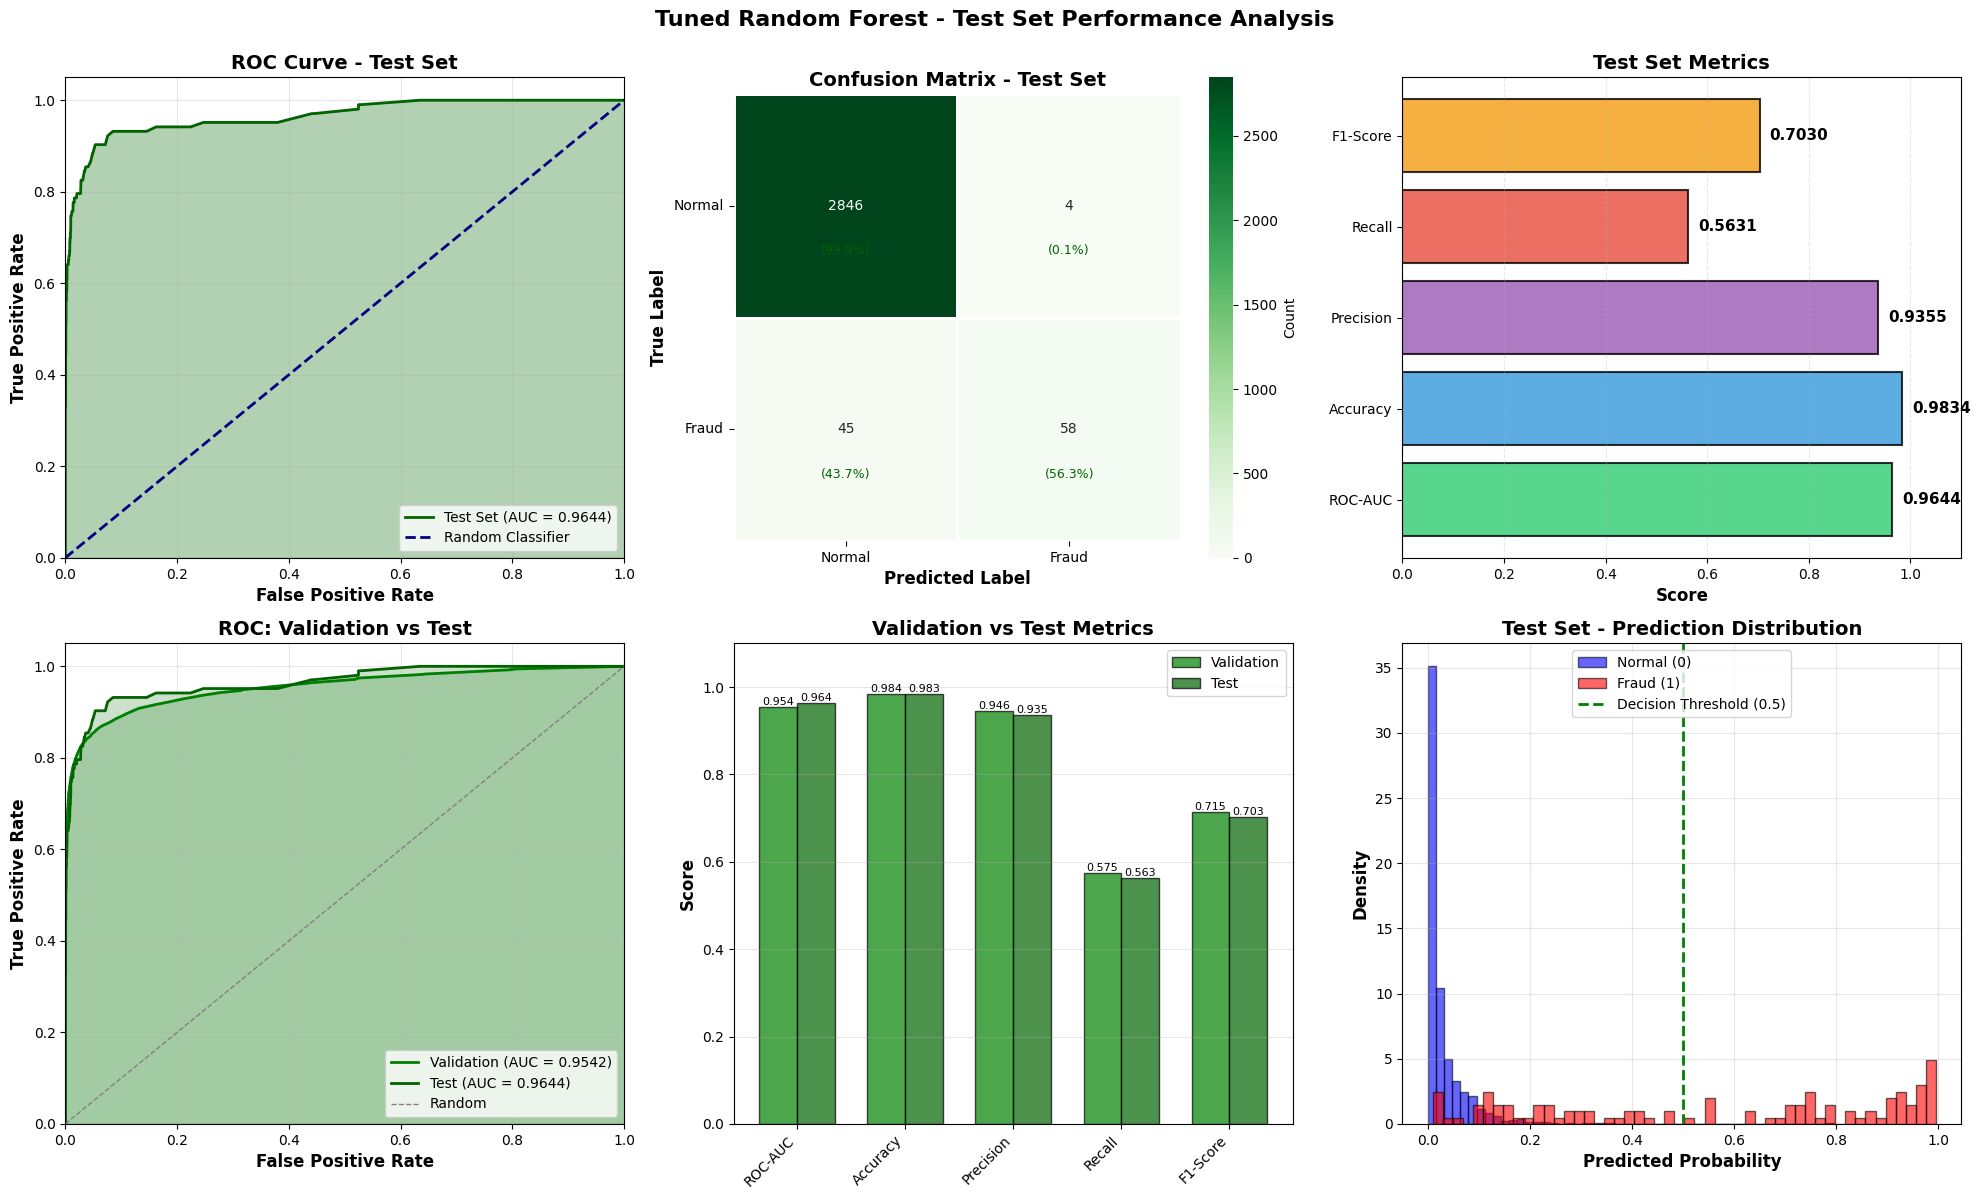


✅ Random Forest test visualization completed!

🎉 EXPERIMENT 2: RANDOM FOREST - COMPLETED!


In [21]:
# ===================================
# VISUALIZE RANDOM FOREST TEST RESULTS
# ===================================

print("📊 Creating Test Set Performance Visualizations for Random Forest")
print("="*70)

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(f'{best_rf_name} - Test Set Performance Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

# ========================================
# 1. ROC-AUC Curve (Test Set)
# ========================================
ax1 = axes[0, 0]

fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_test_pred_proba_rf)
roc_auc_test_rf = auc(fpr_test_rf, tpr_test_rf)

ax1.plot(fpr_test_rf, tpr_test_rf, color='darkgreen', lw=2, 
         label=f'Test Set (AUC = {roc_auc_test_rf:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')

ax1.fill_between(fpr_test_rf, tpr_test_rf, alpha=0.3, color='darkgreen')

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right", fontsize=10)
ax1.grid(True, alpha=0.3)

# ========================================
# 2. Confusion Matrix (Test Set)
# ========================================
ax2 = axes[0, 1]

cm_test_rf_norm = cm_test_rf.astype('float') / cm_test_rf.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_test_rf, annot=True, fmt='d', cmap='Greens', ax=ax2, 
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='white',
            square=True, vmin=0)

for i in range(2):
    for j in range(2):
        ax2.text(j+0.5, i+0.7, f'({cm_test_rf_norm[i, j]*100:.1f}%)',
                ha="center", va="center", color="darkgreen", fontsize=9)

ax2.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_xticklabels(['Normal', 'Fraud'], fontsize=10)
ax2.set_yticklabels(['Normal', 'Fraud'], fontsize=10, rotation=0)

# ========================================
# 3. Performance Metrics (Test Set)
# ========================================
ax3 = axes[0, 2]

metrics_names_test_rf = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values_test_rf = [test_roc_auc_rf, test_accuracy_rf, test_precision_rf, test_recall_rf, test_f1_rf]
colors_test_rf = ['#2ECC71', '#3498DB', '#9B59B6', '#E74C3C', '#F39C12']

bars_test_rf = ax3.barh(metrics_names_test_rf, metrics_values_test_rf, 
                        color=colors_test_rf, alpha=0.8, edgecolor='black', linewidth=1.5)

for bar, value in zip(bars_test_rf, metrics_values_test_rf):
    width = bar.get_width()
    ax3.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{value:.4f}', ha='left', va='center', fontsize=11, fontweight='bold')

ax3.set_xlim([0, 1.1])
ax3.set_xlabel('Score', fontsize=12, fontweight='bold')
ax3.set_title('Test Set Metrics', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3, linestyle='--')

# ========================================
# 4. Validation vs Test ROC Comparison
# ========================================
ax4 = axes[1, 0]

# Get validation ROC
if val_roc_auc_rf_best >= val_roc_auc_rf:
    fpr_val_rf, tpr_val_rf, _ = roc_curve(y_val, y_val_pred_proba_rf_best)
else:
    fpr_val_rf, tpr_val_rf, _ = roc_curve(y_val, y_val_pred_proba_rf)

ax4.plot(fpr_val_rf, tpr_val_rf, color='green', lw=2, 
         label=f'Validation (AUC = {best_rf_auc:.4f})')
ax4.plot(fpr_test_rf, tpr_test_rf, color='darkgreen', lw=2, 
         label=f'Test (AUC = {roc_auc_test_rf:.4f})')
ax4.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Random')

ax4.fill_between(fpr_val_rf, tpr_val_rf, alpha=0.2, color='green')
ax4.fill_between(fpr_test_rf, tpr_test_rf, alpha=0.2, color='darkgreen')

ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax4.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax4.set_title('ROC: Validation vs Test', fontsize=14, fontweight='bold')
ax4.legend(loc="lower right", fontsize=10)
ax4.grid(True, alpha=0.3)

# ========================================
# 5. Validation vs Test Metrics Comparison
# ========================================
ax5 = axes[1, 1]

val_metrics_rf = [best_rf_auc, 
                  val_accuracy_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_accuracy_rf,
                  val_precision_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_precision_rf,
                  val_recall_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_recall_rf,
                  val_f1_rf_best if val_roc_auc_rf_best >= val_roc_auc_rf else val_f1_rf]

x_compare_rf = np.arange(len(metrics_names_test_rf))
width_compare_rf = 0.35

bars_val_rf = ax5.bar(x_compare_rf - width_compare_rf/2, val_metrics_rf, width_compare_rf, 
                      label='Validation', color='green', alpha=0.7, edgecolor='black')
bars_test_rf2 = ax5.bar(x_compare_rf + width_compare_rf/2, metrics_values_test_rf, width_compare_rf, 
                        label='Test', color='darkgreen', alpha=0.7, edgecolor='black')

for bars in [bars_val_rf, bars_test_rf2]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax5.set_ylabel('Score', fontsize=12, fontweight='bold')
ax5.set_title('Validation vs Test Metrics', fontsize=14, fontweight='bold')
ax5.set_xticks(x_compare_rf)
ax5.set_xticklabels(metrics_names_test_rf, rotation=45, ha='right')
ax5.legend(fontsize=10)
ax5.grid(axis='y', alpha=0.3)
ax5.set_ylim([0, 1.1])

# ========================================
# 6. Prediction Distribution (Test Set)
# ========================================
ax6 = axes[1, 2]

y_test_pred_proba_rf_0 = y_test_pred_proba_rf[y_test == 0]
y_test_pred_proba_rf_1 = y_test_pred_proba_rf[y_test == 1]

ax6.hist(y_test_pred_proba_rf_0, bins=50, alpha=0.6, label='Normal (0)', 
         color='blue', edgecolor='black', density=True)
ax6.hist(y_test_pred_proba_rf_1, bins=50, alpha=0.6, label='Fraud (1)', 
         color='red', edgecolor='black', density=True)

ax6.axvline(x=0.5, color='green', linestyle='--', linewidth=2, 
           label='Decision Threshold (0.5)')

ax6.set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
ax6.set_ylabel('Density', fontsize=12, fontweight='bold')
ax6.set_title('Test Set - Prediction Distribution', fontsize=14, fontweight='bold')
ax6.legend(loc='upper center', fontsize=10)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Random Forest test visualization completed!")
print("\n" + "="*70)
print("🎉 EXPERIMENT 2: RANDOM FOREST - COMPLETED!")
print("="*70)

# Decision Tree

## Baseline model

In [22]:
# ===================================
# DECISION TREE - BASELINE
# ===================================

print("🚀 Training Baseline Decision Tree Model")
print("="*70)

# Khởi tạo baseline model
baseline_dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

print("\n📋 Baseline Model Configuration:")
print(f"   Model: Decision Tree Classifier")
print(f"   Parameters:")
print(f"   - max_depth: 10")
print(f"   - min_samples_split: 10")
print(f"   - min_samples_leaf: 5")
print(f"   - class_weight: balanced")

print("\n🔄 Training on processed train set...")
baseline_dt.fit(X_train_processed, y_train_processed)
print("✅ Training completed!")

print("\n🔮 Making predictions on validation set...")
y_val_pred_dt = baseline_dt.predict(X_val_processed)
y_val_pred_proba_dt = baseline_dt.predict_proba(X_val_processed)[:, 1]

# Tính metrics
val_roc_auc_dt = roc_auc_score(y_val, y_val_pred_proba_dt)
val_accuracy_dt = accuracy_score(y_val, y_val_pred_dt)
val_precision_dt = precision_score(y_val, y_val_pred_dt, zero_division=0)
val_recall_dt = recall_score(y_val, y_val_pred_dt, zero_division=0)
val_f1_dt = f1_score(y_val, y_val_pred_dt, zero_division=0)

print("\n" + "="*70)
print("📊 BASELINE DECISION TREE PERFORMANCE")
print("="*70)
print(f"   ROC-AUC:   {val_roc_auc_dt:.4f}")
print(f"   Accuracy:  {val_accuracy_dt:.4f}")
print(f"   Precision: {val_precision_dt:.4f}")
print(f"   Recall:    {val_recall_dt:.4f}")
print(f"   F1-Score:  {val_f1_dt:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_val, y_val_pred_dt, target_names=['Normal', 'Fraud']))

cm_dt = confusion_matrix(y_val, y_val_pred_dt)
print(f"\n🔢 Confusion Matrix:")
print(f"   True Negatives:  {cm_dt[0,0]:,}")
print(f"   False Positives: {cm_dt[0,1]:,}")
print(f"   False Negatives: {cm_dt[1,0]:,}")
print(f"   True Positives:  {cm_dt[1,1]:,}")

print(f"\n🌲 Model Information:")
print(f"   Tree depth: {baseline_dt.get_depth()}")
print(f"   Number of leaves: {baseline_dt.get_n_leaves()}")
print(f"   Number of features: {baseline_dt.n_features_in_}")

print("\n✅ Baseline Decision Tree evaluation completed!")

🚀 Training Baseline Decision Tree Model

📋 Baseline Model Configuration:
   Model: Decision Tree Classifier
   Parameters:
   - max_depth: 10
   - min_samples_split: 10
   - min_samples_leaf: 5
   - class_weight: balanced

🔄 Training on processed train set...
✅ Training completed!

🔮 Making predictions on validation set...

📊 BASELINE DECISION TREE PERFORMANCE
   ROC-AUC:   0.8196
   Accuracy:  0.9026
   Precision: 0.1846
   Recall:    0.5224
   F1-Score:  0.2728

📋 Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.92      0.95    113975
       Fraud       0.18      0.52      0.27      4133

    accuracy                           0.90    118108
   macro avg       0.58      0.72      0.61    118108
weighted avg       0.95      0.90      0.92    118108


🔢 Confusion Matrix:
   True Negatives:  104,441
   False Positives: 9,534
   False Negatives: 1,974
   True Positives:  2,159

🌲 Model Information:
   Tree depth: 5
   Number of 


📊 VISUALIZING BASELINE DECISION TREE PERFORMANCE


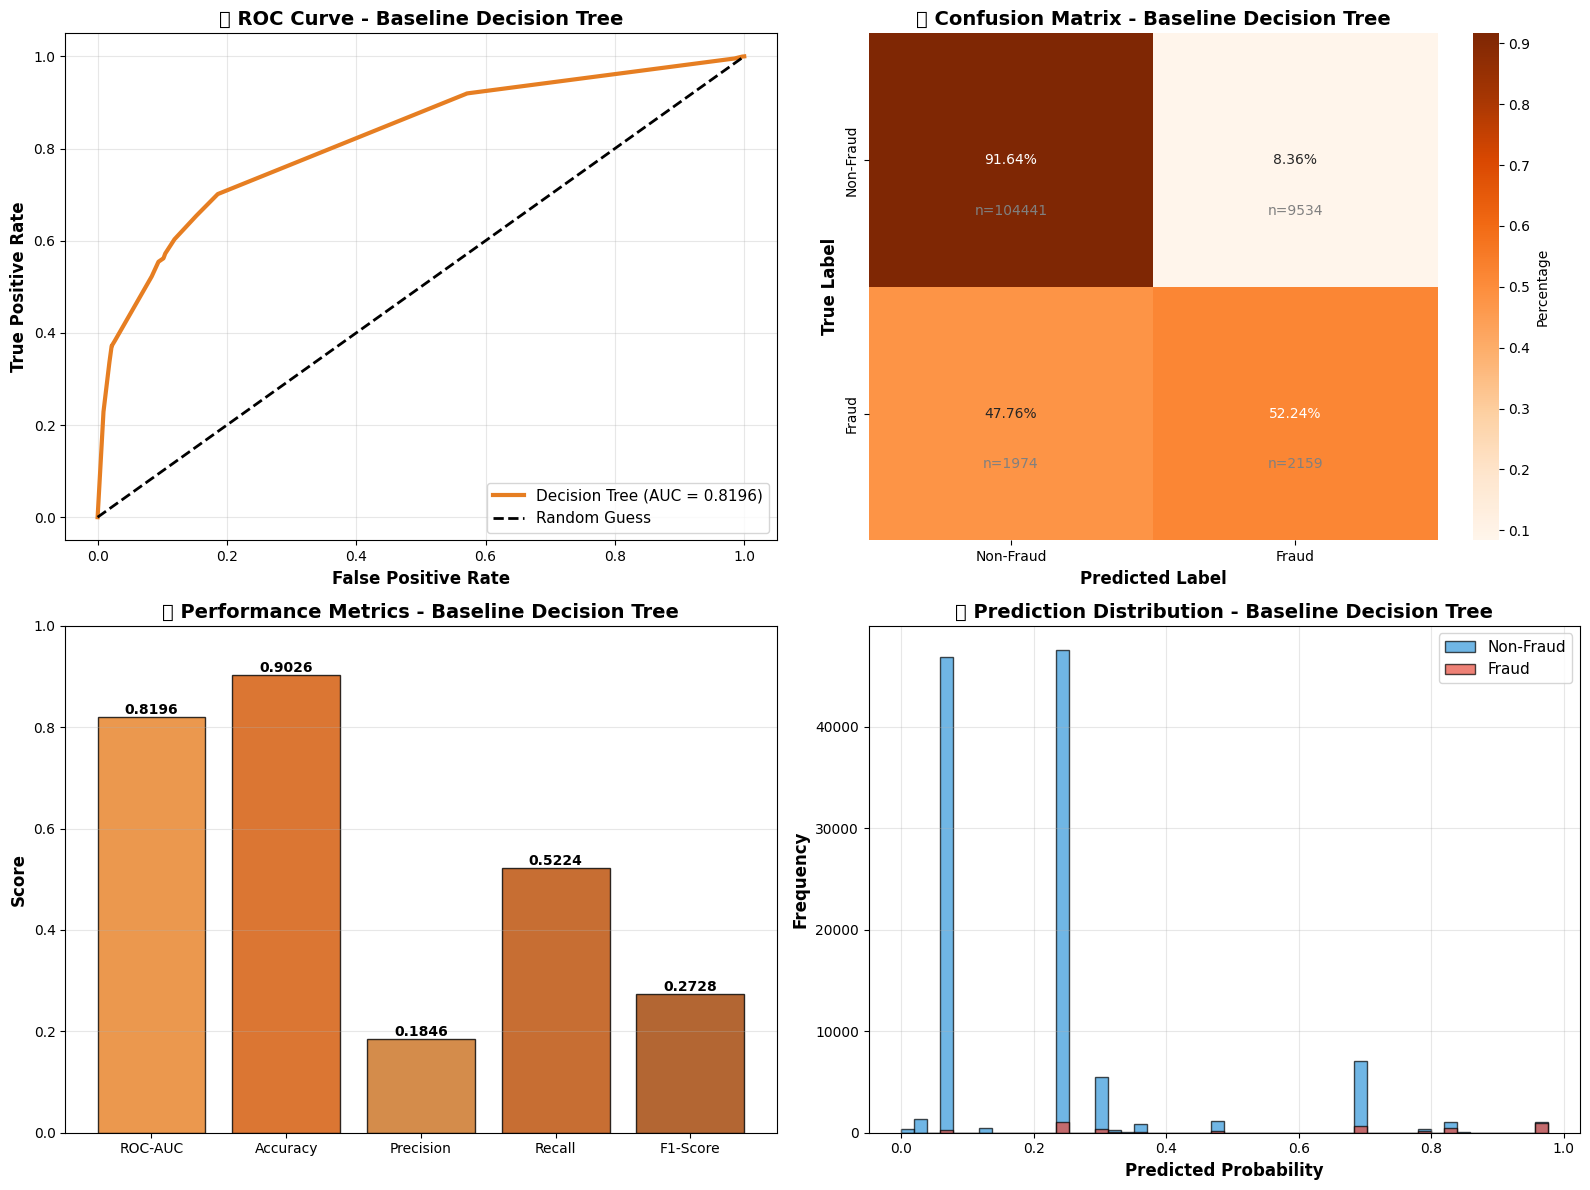


🎯 KEY INSIGHTS:
   Fraud Detection Rate: 52.24% (2159/4133 frauds caught)
   False Alarm Rate:     8.36% (9534/113975 false alarms)
   Tree Depth:           5
   Number of Leaves:     28

✅ Baseline Decision Tree visualization completed!


In [23]:
# ===================================
# VISUALIZE BASELINE DECISION TREE
# ===================================

print("\n📊 VISUALIZING BASELINE DECISION TREE PERFORMANCE")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val, y_val_pred_proba_dt)
roc_auc_dt = roc_auc_score(y_val, y_val_pred_proba_dt)

axes[0, 0].plot(fpr_dt, tpr_dt, color='#E67E22', lw=3, 
                label=f'Decision Tree (AUC = {roc_auc_dt:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('🌳 ROC Curve - Baseline Decision Tree', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. Confusion Matrix
cm_dt = confusion_matrix(y_val, y_val_pred_dt)
cm_dt_normalized = cm_dt.astype('float') / cm_dt.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_dt_normalized, annot=True, fmt='.2%', cmap='Oranges', 
            cbar_kws={'label': 'Percentage'}, ax=axes[0, 1],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 1].set_title('🌳 Confusion Matrix - Baseline Decision Tree', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts
for i in range(2):
    for j in range(2):
        axes[0, 1].text(j+0.5, i+0.7, f'n={cm_dt[i,j]}', 
                       ha='center', va='center', fontsize=10, color='gray')

# 3. Metrics Bar Chart
metrics_names_dt = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values_dt = [val_roc_auc_dt, val_accuracy_dt, val_precision_dt, val_recall_dt, val_f1_dt]
colors_dt = ['#E67E22', '#D35400', '#CA6F1E', '#BA4A00', '#A04000']

bars_dt = axes[1, 0].bar(metrics_names_dt, metrics_values_dt, color=colors_dt, alpha=0.8, edgecolor='black')
axes[1, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('🌳 Performance Metrics - Baseline Decision Tree', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars_dt:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Prediction Distribution
axes[1, 1].hist(y_val_pred_proba_dt[y_val == 0], bins=50, alpha=0.7, 
               label='Non-Fraud', color='#3498DB', edgecolor='black')
axes[1, 1].hist(y_val_pred_proba_dt[y_val == 1], bins=50, alpha=0.7, 
               label='Fraud', color='#E74C3C', edgecolor='black')
axes[1, 1].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 1].set_title('🌳 Prediction Distribution - Baseline Decision Tree', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
fraud_detection_rate_dt = cm_dt[1, 1] / cm_dt[1].sum()
false_alarm_rate_dt = cm_dt[0, 1] / cm_dt[0].sum()

print(f"\n🎯 KEY INSIGHTS:")
print(f"   Fraud Detection Rate: {fraud_detection_rate_dt:.2%} ({cm_dt[1, 1]}/{cm_dt[1].sum()} frauds caught)")
print(f"   False Alarm Rate:     {false_alarm_rate_dt:.2%} ({cm_dt[0, 1]}/{cm_dt[0].sum()} false alarms)")
print(f"   Tree Depth:           {baseline_dt.get_depth()}")
print(f"   Number of Leaves:     {baseline_dt.get_n_leaves()}")

print("\n✅ Baseline Decision Tree visualization completed!")

## Hyperparameter Tuning

In [24]:
# ===================================
# DECISION TREE - HYPERPARAMETER TUNING
# ===================================

print("🔧 Hyperparameter Tuning for Decision Tree")
print("="*70)

param_grid_dt = {
    'max_depth': [ 10, 20 ,30 ,40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': ['balanced']
}

total_combinations_dt = (len(param_grid_dt['max_depth']) * 
                         len(param_grid_dt['min_samples_split']) * 
                         len(param_grid_dt['min_samples_leaf']))

print(f"\n📋 Tuning Configuration:")
print(f"   - max_depth: {param_grid_dt['max_depth']}")
print(f"   - min_samples_split: {param_grid_dt['min_samples_split']}")
print(f"   - min_samples_leaf: {param_grid_dt['min_samples_leaf']}")
print(f"   - Total combinations: {total_combinations_dt}")
print(f"   - CV folds: 3")
print(f"   - Total fits: {total_combinations_dt * 3}")

dt_tuning = DecisionTreeClassifier(random_state=42)

grid_search_dt = GridSearchCV(
    estimator=dt_tuning,
    param_grid=param_grid_dt,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\n🔄 Starting Grid Search...")
start_time_dt = time.time()
grid_search_dt.fit(X_train_processed, y_train_processed)
elapsed_time_dt = time.time() - start_time_dt

print(f"\n✅ Grid Search completed in {elapsed_time_dt:.2f} seconds ({elapsed_time_dt/60:.2f} minutes)")

# Extract best parameters and score
best_dt_params = grid_search_dt.best_params_
best_dt_cv_score = grid_search_dt.best_score_

print(f"\n🏆 Best Parameters:")
for param, value in best_dt_params.items():
    print(f"   - {param}: {value}")

print(f"\n📊 Best Cross-Validation ROC-AUC: {best_dt_cv_score:.4f}")

# Train best model on full training set
print("\n🔄 Training best Decision Tree on full training set...")
best_dt = DecisionTreeClassifier(**best_dt_params, random_state=42)
best_dt.fit(X_train_processed, y_train_processed)
print("✅ Best model training completed!")

# Evaluate best model on validation set
print("\n🔮 Evaluating best Decision Tree on validation set...")
y_val_pred_dt_best = best_dt.predict(X_val_processed)
y_val_pred_proba_dt_best = best_dt.predict_proba(X_val_processed)[:, 1]

val_roc_auc_dt_best = roc_auc_score(y_val, y_val_pred_proba_dt_best)
val_accuracy_dt_best = accuracy_score(y_val, y_val_pred_dt_best)
val_precision_dt_best = precision_score(y_val, y_val_pred_dt_best, zero_division=0)
val_recall_dt_best = recall_score(y_val, y_val_pred_dt_best, zero_division=0)
val_f1_dt_best = f1_score(y_val, y_val_pred_dt_best, zero_division=0)

print(f"\n📊 BEST DECISION TREE PERFORMANCE:")
print(f"   ROC-AUC:   {val_roc_auc_dt_best:.4f}")
print(f"   Accuracy:  {val_accuracy_dt_best:.4f}")
print(f"   Precision: {val_precision_dt_best:.4f}")
print(f"   Recall:    {val_recall_dt_best:.4f}")
print(f"   F1-Score:  {val_f1_dt_best:.4f}")

# Compare with baseline
improvement_dt = ((val_roc_auc_dt_best - val_roc_auc_dt) / val_roc_auc_dt) * 100
print(f"\n📈 Improvement over baseline: {improvement_dt:+.2f}%")

# Store results in DataFrame for analysis
cv_results_dt = pd.DataFrame(grid_search_dt.cv_results_)
cv_results_dt = cv_results_dt.sort_values('rank_test_score')

print("\n🔝 Top 10 Parameter Combinations:")
top_10_dt = cv_results_dt[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)
for idx, row in top_10_dt.iterrows():
    print(f"\n   Rank {int(row['rank_test_score'])}:")
    print(f"   Params: {row['params']}")
    print(f"   Mean ROC-AUC: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")

print("\n✅ Hyperparameter tuning completed!")

🔧 Hyperparameter Tuning for Decision Tree

📋 Tuning Configuration:
   - max_depth: [10, 20, 30, 40]
   - min_samples_split: [2, 5, 10]
   - min_samples_leaf: [1, 2, 5]
   - Total combinations: 36
   - CV folds: 3
   - Total fits: 108

🔄 Starting Grid Search...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

✅ Grid Search completed in 786.61 seconds (13.11 minutes)

🏆 Best Parameters:
   - class_weight: balanced
   - max_depth: 40
   - min_samples_leaf: 5
   - min_samples_split: 2

📊 Best Cross-Validation ROC-AUC: 0.9678

🔄 Training best Decision Tree on full training set...

✅ Grid Search completed in 786.61 seconds (13.11 minutes)

🏆 Best Parameters:
   - class_weight: balanced
   - max_depth: 40
   - min_samples_leaf: 5
   - min_samples_split: 2

📊 Best Cross-Validation ROC-AUC: 0.9678

🔄 Training best Decision Tree on full training set...
✅ Best model training completed!

🔮 Evaluating best Decision Tree on validation set...
✅ Best model training completed!

🔮 Evaluati


📊 COMPARING BASELINE VS TUNED DECISION TREE


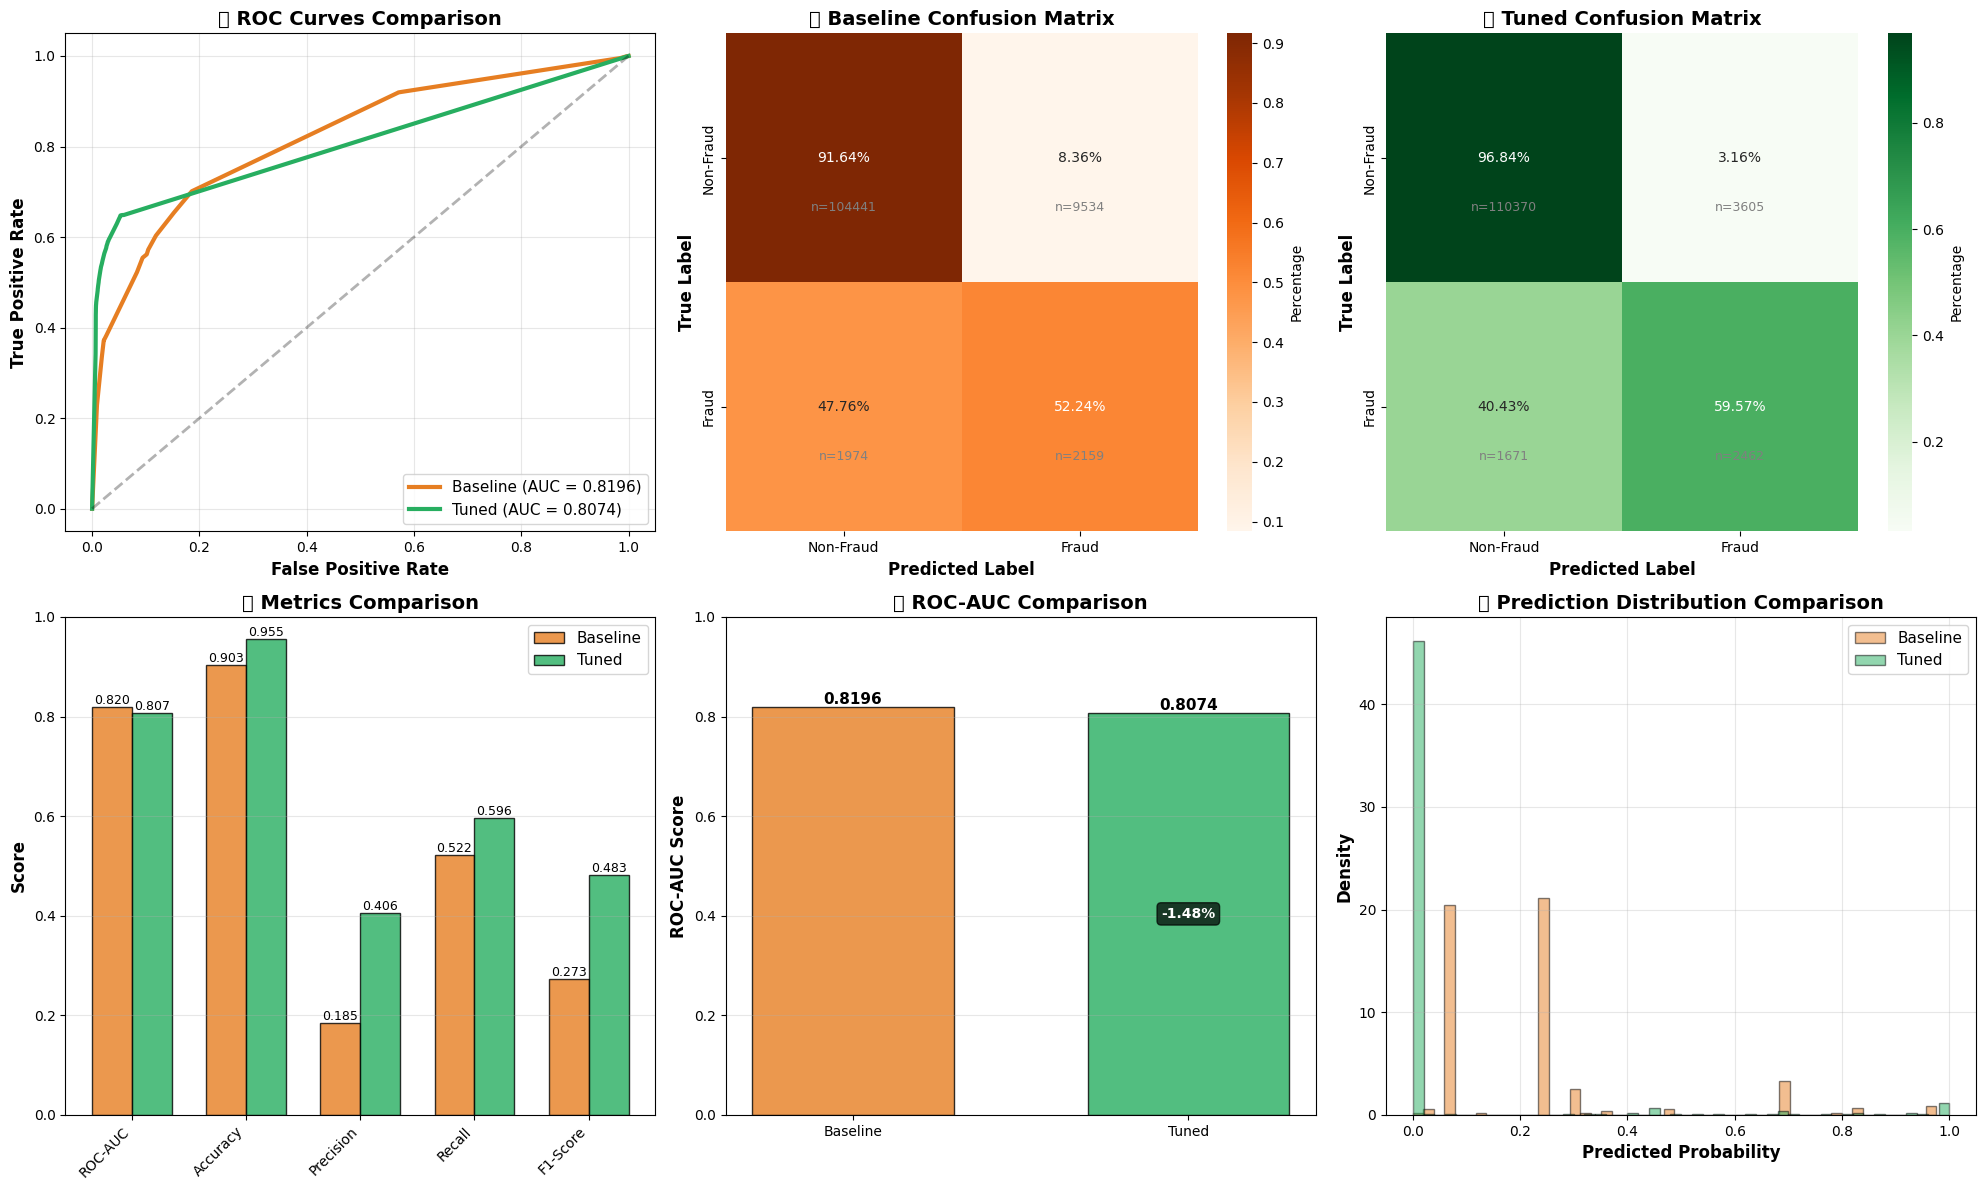


📊 DETAILED COMPARISON:

Metric          Baseline     Tuned        Change      
------------------------------------------------------------
ROC-AUC         0.8196       0.8074       -0.0121
Accuracy        0.9026       0.9553       +0.0528
Precision       0.1846       0.4058       +0.2212
Recall          0.5224       0.5957       +0.0733
F1-Score        0.2728       0.4827       +0.2099

🌳 Tree Complexity:
   Baseline - Depth: 5, Leaves: 28
   Tuned    - Depth: 40, Leaves: 9265

✅ Comparison visualization completed!


In [25]:
# ===================================
# COMPARE BASELINE VS TUNED DECISION TREE
# ===================================

print("\n📊 COMPARING BASELINE VS TUNED DECISION TREE")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. ROC Curves Comparison
fpr_dt_base, tpr_dt_base, _ = roc_curve(y_val, y_val_pred_proba_dt)
fpr_dt_best, tpr_dt_best, _ = roc_curve(y_val, y_val_pred_proba_dt_best)

axes[0, 0].plot(fpr_dt_base, tpr_dt_base, color='#E67E22', lw=3, 
                label=f'Baseline (AUC = {val_roc_auc_dt:.4f})')
axes[0, 0].plot(fpr_dt_best, tpr_dt_best, color='#27AE60', lw=3, 
                label=f'Tuned (AUC = {val_roc_auc_dt_best:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3)
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('🌳 ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. Baseline Confusion Matrix
cm_dt_base = confusion_matrix(y_val, y_val_pred_dt)
cm_dt_base_norm = cm_dt_base.astype('float') / cm_dt_base.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_dt_base_norm, annot=True, fmt='.2%', cmap='Oranges',
            cbar_kws={'label': 'Percentage'}, ax=axes[0, 1],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 1].set_title('🌳 Baseline Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts
for i in range(2):
    for j in range(2):
        axes[0, 1].text(j+0.5, i+0.7, f'n={cm_dt_base[i,j]}',
                       ha='center', va='center', fontsize=9, color='gray')

# 3. Tuned Confusion Matrix
cm_dt_best = confusion_matrix(y_val, y_val_pred_dt_best)
cm_dt_best_norm = cm_dt_best.astype('float') / cm_dt_best.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_dt_best_norm, annot=True, fmt='.2%', cmap='Greens',
            cbar_kws={'label': 'Percentage'}, ax=axes[0, 2],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 2].set_title('🌳 Tuned Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts
for i in range(2):
    for j in range(2):
        axes[0, 2].text(j+0.5, i+0.7, f'n={cm_dt_best[i,j]}',
                       ha='center', va='center', fontsize=9, color='gray')

# 4. Metrics Comparison Bar Chart
metrics_names_dt_comp = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
baseline_metrics_dt = [val_roc_auc_dt, val_accuracy_dt, val_precision_dt, val_recall_dt, val_f1_dt]
tuned_metrics_dt = [val_roc_auc_dt_best, val_accuracy_dt_best, val_precision_dt_best, val_recall_dt_best, val_f1_dt_best]

x_compare_dt = np.arange(len(metrics_names_dt_comp))
width_compare_dt = 0.35

bars1_dt = axes[1, 0].bar(x_compare_dt - width_compare_dt/2, baseline_metrics_dt, width_compare_dt,
                          label='Baseline', color='#E67E22', alpha=0.8, edgecolor='black')
bars2_dt = axes[1, 0].bar(x_compare_dt + width_compare_dt/2, tuned_metrics_dt, width_compare_dt,
                          label='Tuned', color='#27AE60', alpha=0.8, edgecolor='black')

axes[1, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('🌳 Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x_compare_dt)
axes[1, 0].set_xticklabels(metrics_names_dt_comp, rotation=45, ha='right')
axes[1, 0].legend(fontsize=11)
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1_dt, bars2_dt]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 5. ROC-AUC Comparison
models_dt = ['Baseline', 'Tuned']
aucs_dt = [val_roc_auc_dt, val_roc_auc_dt_best]
colors_dt_auc = ['#E67E22', '#27AE60']

bars_dt_auc = axes[1, 1].bar(models_dt, aucs_dt, color=colors_dt_auc, alpha=0.8, edgecolor='black', width=0.6)
axes[1, 1].set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('🌳 ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels and improvement
for i, (bar, auc) in enumerate(zip(bars_dt_auc, aucs_dt)):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{auc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    if i == 1:  # Tuned model
        improvement_dt = ((aucs_dt[1] - aucs_dt[0]) / aucs_dt[0]) * 100
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height/2,
                       f'{improvement_dt:+.2f}%', ha='center', va='center',
                       fontsize=10, fontweight='bold', color='white',
                       bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

# 6. Prediction Distribution Comparison
axes[1, 2].hist(y_val_pred_proba_dt, bins=50, alpha=0.5, label='Baseline',
               color='#E67E22', edgecolor='black', density=True)
axes[1, 2].hist(y_val_pred_proba_dt_best, bins=50, alpha=0.5, label='Tuned',
               color='#27AE60', edgecolor='black', density=True)
axes[1, 2].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Density', fontsize=12, fontweight='bold')
axes[1, 2].set_title('🌳 Prediction Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 2].legend(fontsize=11)
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\n📊 DETAILED COMPARISON:")
print(f"\n{'Metric':<15} {'Baseline':<12} {'Tuned':<12} {'Change':<12}")
print("-" * 60)
print(f"{'ROC-AUC':<15} {val_roc_auc_dt:<12.4f} {val_roc_auc_dt_best:<12.4f} {val_roc_auc_dt_best - val_roc_auc_dt:+.4f}")
print(f"{'Accuracy':<15} {val_accuracy_dt:<12.4f} {val_accuracy_dt_best:<12.4f} {val_accuracy_dt_best - val_accuracy_dt:+.4f}")
print(f"{'Precision':<15} {val_precision_dt:<12.4f} {val_precision_dt_best:<12.4f} {val_precision_dt_best - val_precision_dt:+.4f}")
print(f"{'Recall':<15} {val_recall_dt:<12.4f} {val_recall_dt_best:<12.4f} {val_recall_dt_best - val_recall_dt:+.4f}")
print(f"{'F1-Score':<15} {val_f1_dt:<12.4f} {val_f1_dt_best:<12.4f} {val_f1_dt_best - val_f1_dt:+.4f}")

print(f"\n🌳 Tree Complexity:")
print(f"   Baseline - Depth: {baseline_dt.get_depth()}, Leaves: {baseline_dt.get_n_leaves()}")
print(f"   Tuned    - Depth: {best_dt.get_depth()}, Leaves: {best_dt.get_n_leaves()}")

print("\n✅ Comparison visualization completed!")

## Test Evaluation

In [26]:
# ===================================
# DECISION TREE - TEST EVALUATION
# ===================================

print("🏆 SELECTING BEST DECISION TREE MODEL")
print("="*70)

# Compare baseline vs tuned on validation set
print(f"\n📊 Validation Performance Comparison:")
print(f"   Baseline ROC-AUC: {val_roc_auc_dt:.4f}")
print(f"   Tuned ROC-AUC:    {val_roc_auc_dt_best:.4f}")

if val_roc_auc_dt_best >= val_roc_auc_dt:
    best_dt_model = best_dt
    best_dt_name = "Tuned Decision Tree"
    best_dt_auc = val_roc_auc_dt_best
else:
    best_dt_model = baseline_dt
    best_dt_name = "Baseline Decision Tree"
    best_dt_auc = val_roc_auc_dt

print(f"\n✅ Selected: {best_dt_name} (Validation ROC-AUC: {best_dt_auc:.4f})")

# Test on test set
print("\n🧪 TESTING ON TEST SET")
print("="*70)

y_test_pred_dt = best_dt_model.predict(X_test_processed)
y_test_pred_proba_dt = best_dt_model.predict_proba(X_test_processed)[:, 1]

# Calculate metrics
test_roc_auc_dt = roc_auc_score(y_test, y_test_pred_proba_dt)
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)
test_precision_dt = precision_score(y_test, y_test_pred_dt, zero_division=0)
test_recall_dt = recall_score(y_test, y_test_pred_dt, zero_division=0)
test_f1_dt = f1_score(y_test, y_test_pred_dt, zero_division=0)

print(f"\n📊 TEST SET PERFORMANCE ({best_dt_name}):")
print(f"   ROC-AUC:   {test_roc_auc_dt:.4f}")
print(f"   Accuracy:  {test_accuracy_dt:.4f}")
print(f"   Precision: {test_precision_dt:.4f}")
print(f"   Recall:    {test_recall_dt:.4f}")
print(f"   F1-Score:  {test_f1_dt:.4f}")

# Confusion Matrix Analysis
cm_test_dt = confusion_matrix(y_test, y_test_pred_dt)
print(f"\n📋 Confusion Matrix:")
print(f"   True Negatives:  {cm_test_dt[0, 0]}")
print(f"   False Positives: {cm_test_dt[0, 1]}")
print(f"   False Negatives: {cm_test_dt[1, 0]}")
print(f"   True Positives:  {cm_test_dt[1, 1]}")

test_fraud_detection_rate_dt = cm_test_dt[1, 1] / cm_test_dt[1].sum()
test_false_alarm_rate_dt = cm_test_dt[0, 1] / cm_test_dt[0].sum()

print(f"\n🎯 KEY INSIGHTS:")
print(f"   Fraud Detection Rate: {test_fraud_detection_rate_dt:.2%} ({cm_test_dt[1, 1]}/{cm_test_dt[1].sum()} frauds caught)")
print(f"   False Alarm Rate:     {test_false_alarm_rate_dt:.2%} ({cm_test_dt[0, 1]}/{cm_test_dt[0].sum()} false alarms)")

# Classification Report
print(f"\n📊 Classification Report:")
print(classification_report(y_test, y_test_pred_dt, target_names=['Non-Fraud', 'Fraud'], zero_division=0))

# Store results
test_dt_results = {
    'model': best_dt_name,
    'test_roc_auc': test_roc_auc_dt,
    'test_accuracy': test_accuracy_dt,
    'test_precision': test_precision_dt,
    'test_recall': test_recall_dt,
    'test_f1': test_f1_dt,
    'validation_roc_auc': best_dt_auc
}

print("\n✅ Test evaluation completed!")

🏆 SELECTING BEST DECISION TREE MODEL

📊 Validation Performance Comparison:
   Baseline ROC-AUC: 0.8196
   Tuned ROC-AUC:    0.8074

✅ Selected: Baseline Decision Tree (Validation ROC-AUC: 0.8196)

🧪 TESTING ON TEST SET

📊 TEST SET PERFORMANCE (Baseline Decision Tree):
   ROC-AUC:   0.8209
   Accuracy:  0.9001
   Precision: 0.1800
   Recall:    0.5243
   F1-Score:  0.2680

📋 Confusion Matrix:
   True Negatives:  2604
   False Positives: 246
   False Negatives: 49
   True Positives:  54

🎯 KEY INSIGHTS:
   Fraud Detection Rate: 52.43% (54/103 frauds caught)
   False Alarm Rate:     8.63% (246/2850 false alarms)

📊 Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.91      0.95      2850
       Fraud       0.18      0.52      0.27       103

    accuracy                           0.90      2953
   macro avg       0.58      0.72      0.61      2953
weighted avg       0.95      0.90      0.92      2953


✅ Test evaluation completed!



📊 VISUALIZING DECISION TREE TEST RESULTS


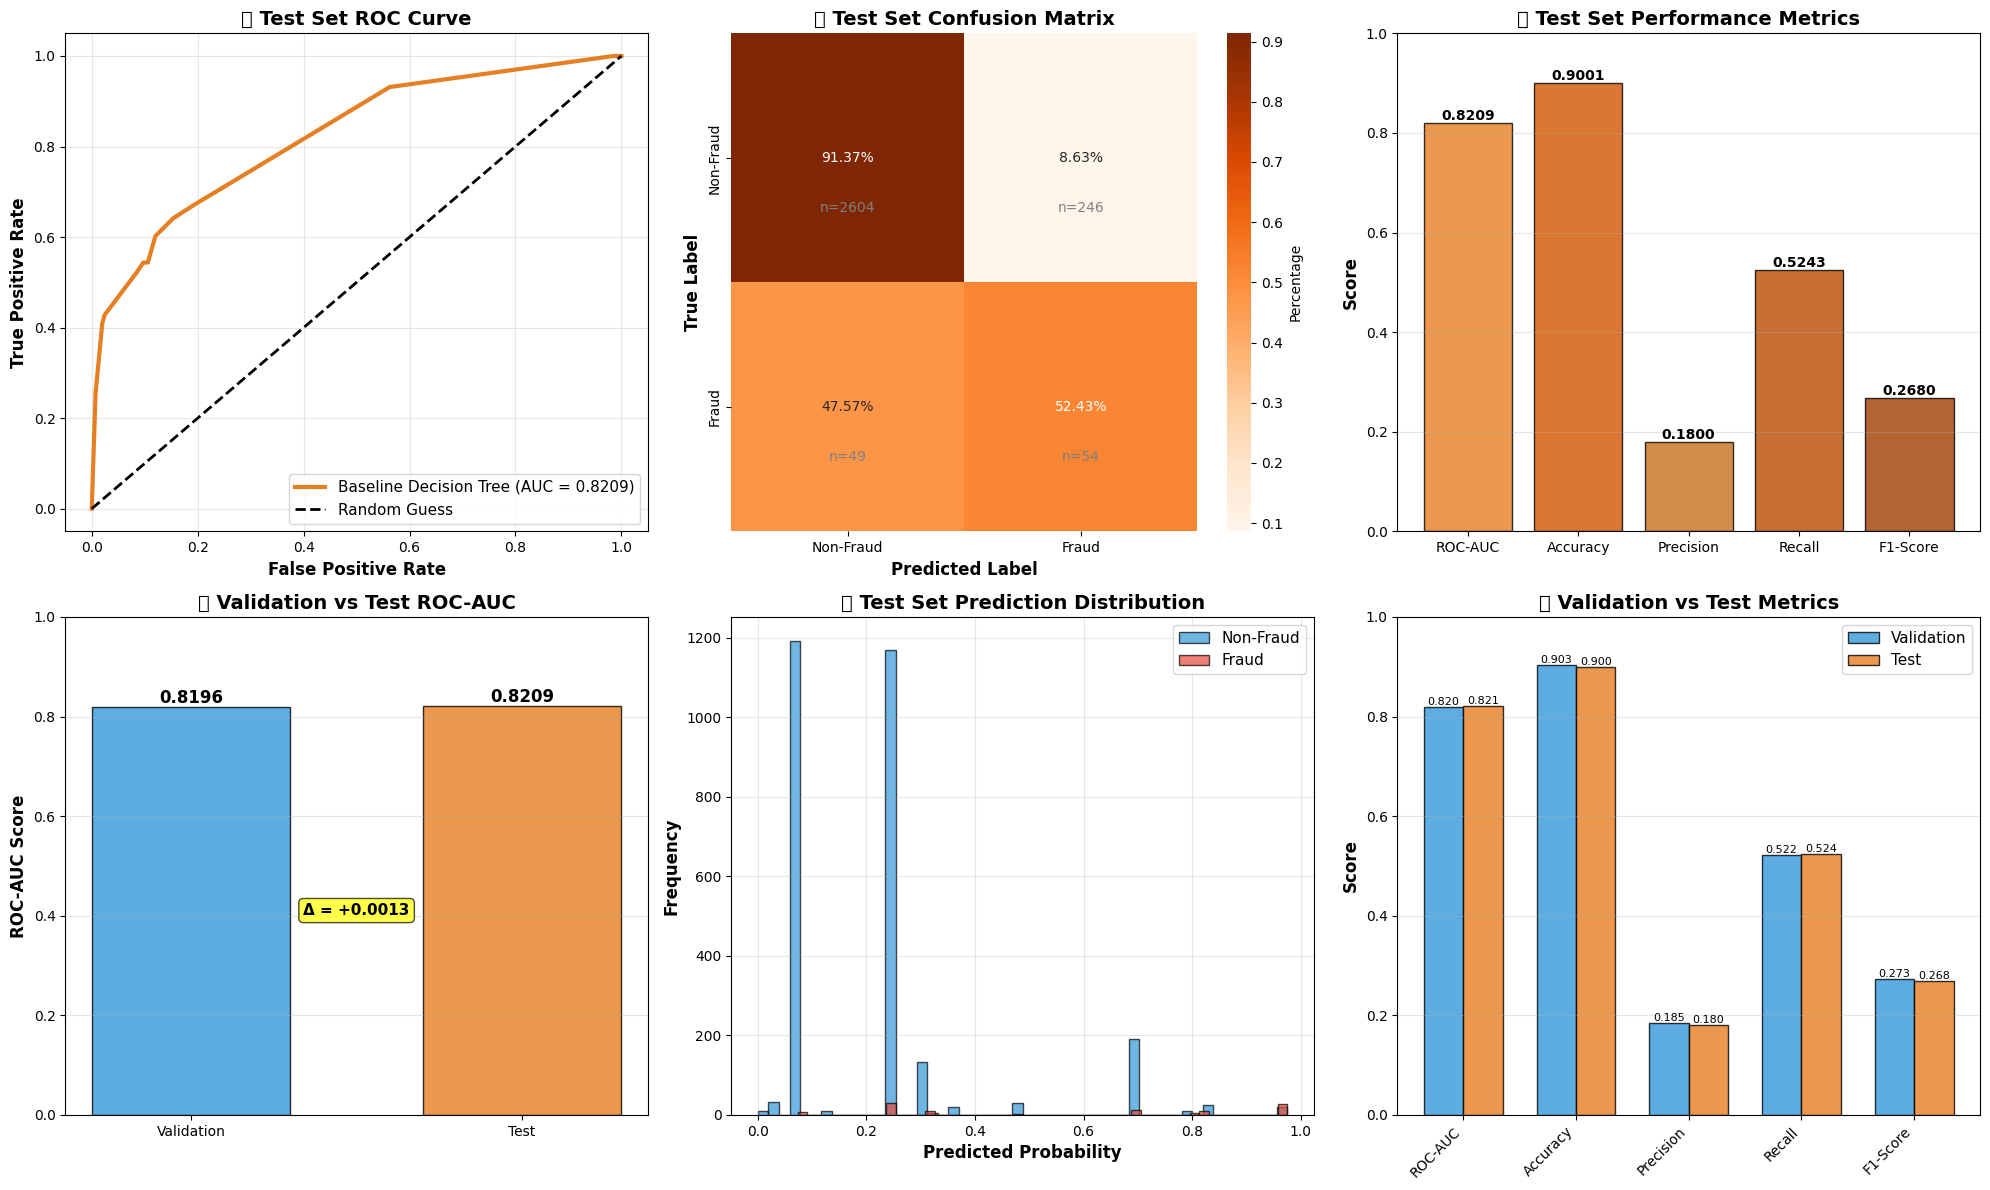


✅ Test visualization completed!

🎉 EXPERIMENT: DECISION TREE - COMPLETED!


In [27]:
# ===================================
# VISUALIZE DECISION TREE TEST RESULTS
# ===================================

print("\n📊 VISUALIZING DECISION TREE TEST RESULTS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Test ROC Curve
fpr_test_dt, tpr_test_dt, _ = roc_curve(y_test, y_test_pred_proba_dt)

axes[0, 0].plot(fpr_test_dt, tpr_test_dt, color='#E67E22', lw=3,
                label=f'{best_dt_name} (AUC = {test_roc_auc_dt:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('🌳 Test Set ROC Curve', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. Test Confusion Matrix
cm_test_dt_norm = cm_test_dt.astype('float') / cm_test_dt.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_test_dt_norm, annot=True, fmt='.2%', cmap='Oranges',
            cbar_kws={'label': 'Percentage'}, ax=axes[0, 1],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 1].set_title('🌳 Test Set Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts
for i in range(2):
    for j in range(2):
        axes[0, 1].text(j+0.5, i+0.7, f'n={cm_test_dt[i,j]}',
                       ha='center', va='center', fontsize=10, color='gray')

# 3. Test Metrics Bar Chart
metrics_names_test_dt = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values_test_dt = [test_roc_auc_dt, test_accuracy_dt, test_precision_dt, test_recall_dt, test_f1_dt]
colors_test_dt = ['#E67E22', '#D35400', '#CA6F1E', '#BA4A00', '#A04000']

bars_test_dt = axes[0, 2].bar(metrics_names_test_dt, metrics_values_test_dt,
                              color=colors_test_dt, alpha=0.8, edgecolor='black')
axes[0, 2].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0, 2].set_title('🌳 Test Set Performance Metrics', fontsize=14, fontweight='bold')
axes[0, 2].set_ylim([0, 1])
axes[0, 2].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars_test_dt:
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Validation vs Test Comparison
datasets = ['Validation', 'Test']
roc_aucs_dt = [best_dt_auc, test_roc_auc_dt]
colors_compare_dt = ['#3498DB', '#E67E22']

bars_compare_dt = axes[1, 0].bar(datasets, roc_aucs_dt, color=colors_compare_dt,
                                 alpha=0.8, edgecolor='black', width=0.6)
axes[1, 0].set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('🌳 Validation vs Test ROC-AUC', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, auc in zip(bars_compare_dt, roc_aucs_dt):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{auc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add difference
diff_dt = test_roc_auc_dt - best_dt_auc
axes[1, 0].text(0.5, max(roc_aucs_dt)/2,
               f'Δ = {diff_dt:+.4f}', ha='center', va='center',
               fontsize=11, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# 5. Test Prediction Distribution
axes[1, 1].hist(y_test_pred_proba_dt[y_test == 0], bins=50, alpha=0.7,
               label='Non-Fraud', color='#3498DB', edgecolor='black')
axes[1, 1].hist(y_test_pred_proba_dt[y_test == 1], bins=50, alpha=0.7,
               label='Fraud', color='#E74C3C', edgecolor='black')
axes[1, 1].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 1].set_title('🌳 Test Set Prediction Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

# 6. Comprehensive Metrics Comparison (Val vs Test)
val_metrics_dt = [best_dt_auc, 
                  val_accuracy_dt_best if best_dt_name == "Tuned Decision Tree" else val_accuracy_dt,
                  val_precision_dt_best if best_dt_name == "Tuned Decision Tree" else val_precision_dt,
                  val_recall_dt_best if best_dt_name == "Tuned Decision Tree" else val_recall_dt,
                  val_f1_dt_best if best_dt_name == "Tuned Decision Tree" else val_f1_dt]

test_metrics_dt = [test_roc_auc_dt, test_accuracy_dt, test_precision_dt, test_recall_dt, test_f1_dt]

x_comp = np.arange(len(metrics_names_test_dt))
width_comp = 0.35

bars_val_dt = axes[1, 2].bar(x_comp - width_comp/2, val_metrics_dt, width_comp,
                             label='Validation', color='#3498DB', alpha=0.8, edgecolor='black')
bars_test_dt2 = axes[1, 2].bar(x_comp + width_comp/2, test_metrics_dt, width_comp,
                               label='Test', color='#E67E22', alpha=0.8, edgecolor='black')

axes[1, 2].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 2].set_title('🌳 Validation vs Test Metrics', fontsize=14, fontweight='bold')
axes[1, 2].set_xticks(x_comp)
axes[1, 2].set_xticklabels(metrics_names_test_dt, rotation=45, ha='right')
axes[1, 2].legend(fontsize=11)
axes[1, 2].set_ylim([0, 1])
axes[1, 2].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars_val_dt, bars_test_dt2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n✅ Test visualization completed!")
print("\n" + "="*70)
print("🎉 EXPERIMENT: DECISION TREE - COMPLETED!")
print("="*70)

# SVM

## Baseline Model

In [28]:
# ===================================
# SVM (LINEAR SVC) - BASELINE
# ===================================

from sklearn.svm import LinearSVC

print("🚀 Training Baseline SVM (LinearSVC) Model")
print("="*70)

print("\n📋 Baseline Configuration:")
print("   - Algorithm: LinearSVC")
print("   - C: 1.0 (regularization parameter)")
print("   - class_weight: balanced")
print("   - max_iter: 1000")
print("   - dual: False (for n_samples > n_features)")

baseline_svm = LinearSVC(
    C=1.0,
    class_weight='balanced',
    max_iter=1000,
    dual=False,
    random_state=42,
    verbose=1
)

print("\n🔄 Training on processed train set...")
print(f"   Training samples: {X_train_processed.shape[0]}")
print(f"   Features: {X_train_processed.shape[1]}")

baseline_svm.fit(X_train_processed, y_train_processed)
print("✅ Training completed!")

print("\n🔮 Making predictions on validation set...")
y_val_pred_svm = baseline_svm.predict(X_val_processed)
y_val_decision_svm = baseline_svm.decision_function(X_val_processed)

# Calculate metrics
val_roc_auc_svm = roc_auc_score(y_val, y_val_decision_svm)
val_accuracy_svm = accuracy_score(y_val, y_val_pred_svm)
val_precision_svm = precision_score(y_val, y_val_pred_svm, zero_division=0)
val_recall_svm = recall_score(y_val, y_val_pred_svm, zero_division=0)
val_f1_svm = f1_score(y_val, y_val_pred_svm, zero_division=0)

print("\n📊 BASELINE SVM PERFORMANCE:")
print(f"   ROC-AUC:   {val_roc_auc_svm:.4f}")
print(f"   Accuracy:  {val_accuracy_svm:.4f}")
print(f"   Precision: {val_precision_svm:.4f}")
print(f"   Recall:    {val_recall_svm:.4f}")
print(f"   F1-Score:  {val_f1_svm:.4f}")

# Confusion Matrix
cm_svm = confusion_matrix(y_val, y_val_pred_svm)
print(f"\n📋 Confusion Matrix:")
print(f"   True Negatives:  {cm_svm[0, 0]}")
print(f"   False Positives: {cm_svm[0, 1]}")
print(f"   False Negatives: {cm_svm[1, 0]}")
print(f"   True Positives:  {cm_svm[1, 1]}")

# Classification Report
print(f"\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=['Non-Fraud', 'Fraud'], zero_division=0))

# Store results
baseline_svm_results = {
    'model': 'Baseline SVM',
    'val_roc_auc': val_roc_auc_svm,
    'val_accuracy': val_accuracy_svm,
    'val_precision': val_precision_svm,
    'val_recall': val_recall_svm,
    'val_f1': val_f1_svm
}

print("\n✅ Baseline SVM training completed!")

🚀 Training Baseline SVM (LinearSVC) Model

📋 Baseline Configuration:
   - Algorithm: LinearSVC
   - C: 1.0 (regularization parameter)
   - class_weight: balanced
   - max_iter: 1000
   - dual: False (for n_samples > n_features)

🔄 Training on processed train set...
   Training samples: 592672
   Features: 114
[LibLinear]✅ Training completed!

🔮 Making predictions on validation set...

📊 BASELINE SVM PERFORMANCE:
   ROC-AUC:   0.8429
   Accuracy:  0.8184
   Precision: 0.1270
   Recall:    0.7130
   F1-Score:  0.2156

📋 Confusion Matrix:
   True Negatives:  93714
   False Positives: 20261
   False Negatives: 1186
   True Positives:  2947

📊 Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.82      0.90    113975
       Fraud       0.13      0.71      0.22      4133

    accuracy                           0.82    118108
   macro avg       0.56      0.77      0.56    118108
weighted avg       0.96      0.82      0.87    118108


✅ 


📊 VISUALIZING BASELINE SVM PERFORMANCE


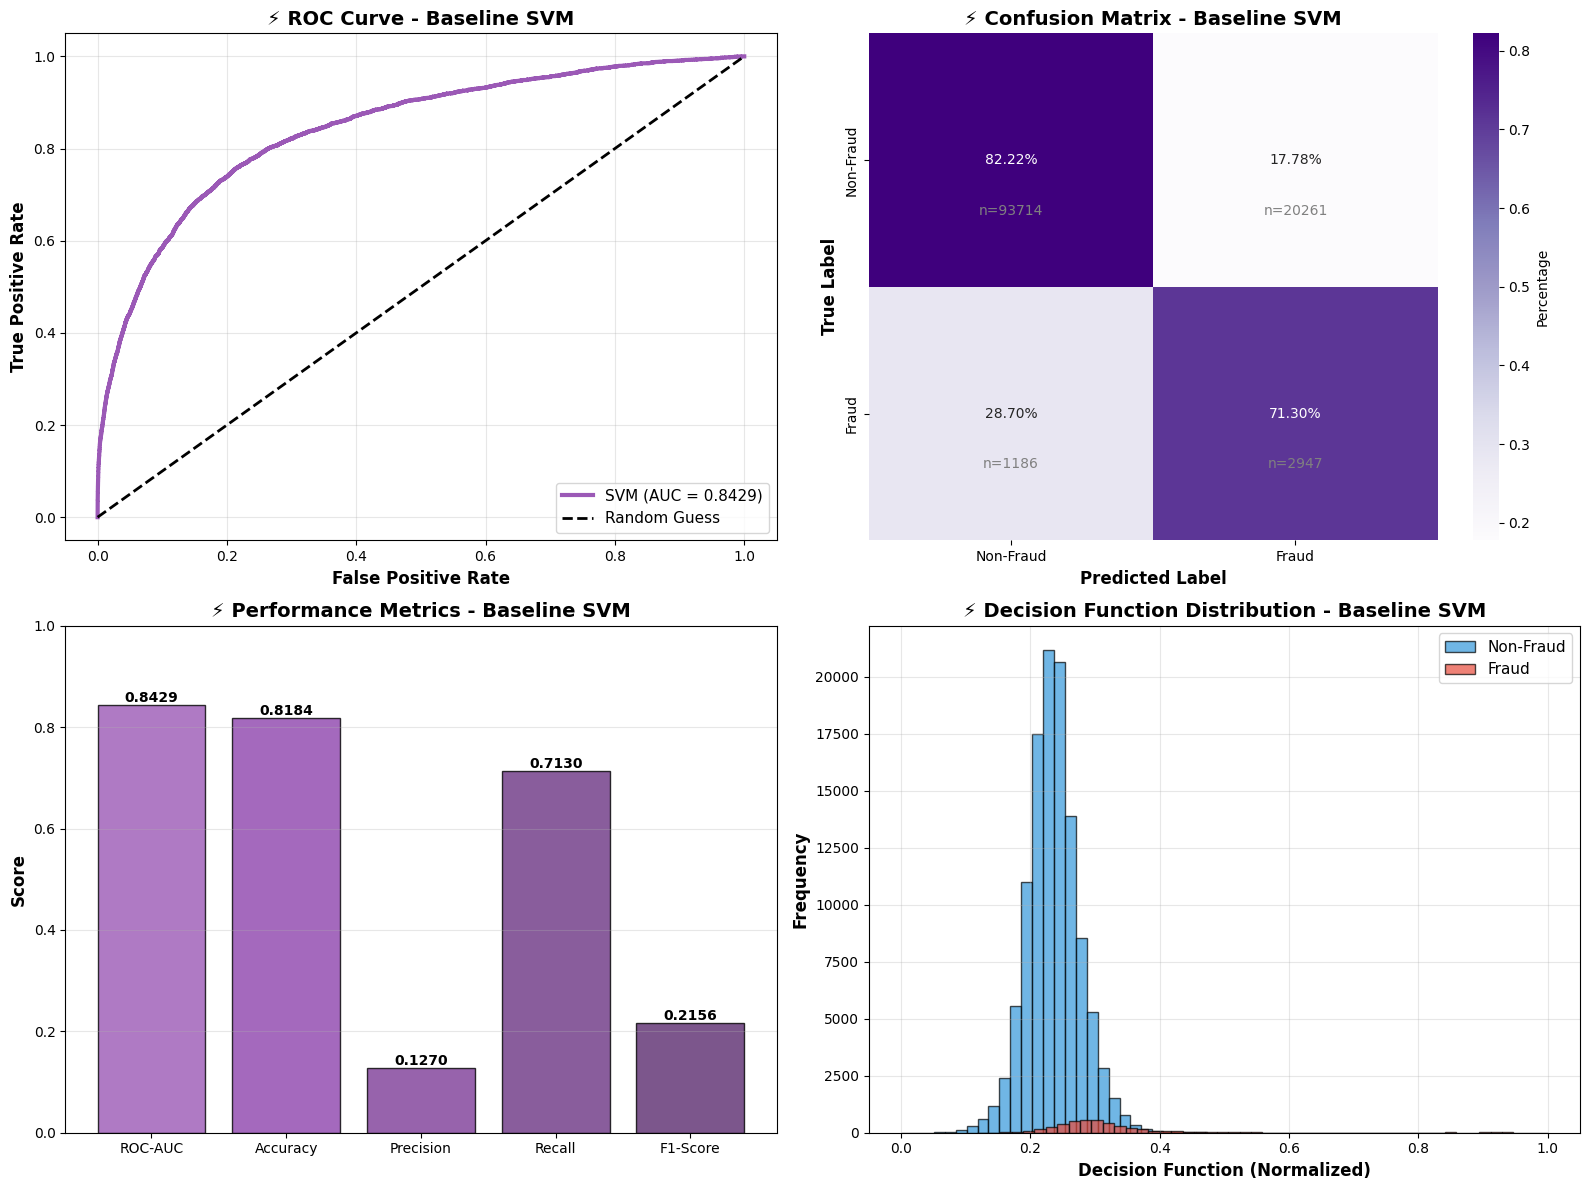


🎯 KEY INSIGHTS:
   Fraud Detection Rate: 71.30% (2947/4133 frauds caught)
   False Alarm Rate:     17.78% (20261/113975 false alarms)
   Support Vectors:      (1, 114)

✅ Baseline SVM visualization completed!


In [29]:
# ===================================
# VISUALIZE BASELINE SVM
# ===================================

print("\n📊 VISUALIZING BASELINE SVM PERFORMANCE")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val, y_val_decision_svm)
roc_auc_svm = roc_auc_score(y_val, y_val_decision_svm)

axes[0, 0].plot(fpr_svm, tpr_svm, color='#9B59B6', lw=3, 
                label=f'SVM (AUC = {roc_auc_svm:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('⚡ ROC Curve - Baseline SVM', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. Confusion Matrix
cm_svm_normalized = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_svm_normalized, annot=True, fmt='.2%', cmap='Purples', 
            cbar_kws={'label': 'Percentage'}, ax=axes[0, 1],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 1].set_title('⚡ Confusion Matrix - Baseline SVM', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts
for i in range(2):
    for j in range(2):
        axes[0, 1].text(j+0.5, i+0.7, f'n={cm_svm[i,j]}', 
                       ha='center', va='center', fontsize=10, color='gray')

# 3. Metrics Bar Chart
metrics_names_svm = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values_svm = [val_roc_auc_svm, val_accuracy_svm, val_precision_svm, val_recall_svm, val_f1_svm]
colors_svm = ['#9B59B6', '#8E44AD', '#7D3C98', '#6C3483', '#5B2C6F']

bars_svm = axes[1, 0].bar(metrics_names_svm, metrics_values_svm, color=colors_svm, alpha=0.8, edgecolor='black')
axes[1, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('⚡ Performance Metrics - Baseline SVM', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars_svm:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Decision Function Distribution (instead of probability for SVM)
# Normalize decision values to [0, 1] range for visualization
decision_min = y_val_decision_svm.min()
decision_max = y_val_decision_svm.max()
y_val_decision_normalized = (y_val_decision_svm - decision_min) / (decision_max - decision_min)

axes[1, 1].hist(y_val_decision_normalized[y_val == 0], bins=50, alpha=0.7, 
               label='Non-Fraud', color='#3498DB', edgecolor='black')
axes[1, 1].hist(y_val_decision_normalized[y_val == 1], bins=50, alpha=0.7, 
               label='Fraud', color='#E74C3C', edgecolor='black')
axes[1, 1].set_xlabel('Decision Function (Normalized)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 1].set_title('⚡ Decision Function Distribution - Baseline SVM', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
fraud_detection_rate_svm = cm_svm[1, 1] / cm_svm[1].sum()
false_alarm_rate_svm = cm_svm[0, 1] / cm_svm[0].sum()

print(f"\n🎯 KEY INSIGHTS:")
print(f"   Fraud Detection Rate: {fraud_detection_rate_svm:.2%} ({cm_svm[1, 1]}/{cm_svm[1].sum()} frauds caught)")
print(f"   False Alarm Rate:     {false_alarm_rate_svm:.2%} ({cm_svm[0, 1]}/{cm_svm[0].sum()} false alarms)")
print(f"   Support Vectors:      {baseline_svm.coef_.shape}")

print("\n✅ Baseline SVM visualization completed!")

## Hyperparameter Tuning

In [30]:
# ===================================
# SVM - HYPERPARAMETER TUNING
# ===================================

print("🔧 Hyperparameter Tuning for SVM (LinearSVC)")
print("="*70)

param_grid_svm = {
    'C': [0.1, 1, 10],
    'class_weight': ['balanced'],
    'max_iter': [1000, 2000],
    'dual': [False]  # Set to False for n_samples > n_features
}

total_combinations_svm = (len(param_grid_svm['C']) * 
                         len(param_grid_svm['max_iter']))

print(f"\n📋 Tuning Configuration:")
print(f"   - C: {param_grid_svm['C']}")
print(f"   - class_weight: {param_grid_svm['class_weight']}")
print(f"   - max_iter: {param_grid_svm['max_iter']}")
print(f"   - dual: {param_grid_svm['dual']}")
print(f"   - Total combinations: {total_combinations_svm}")
print(f"   - CV folds: 3")
print(f"   - Total fits: {total_combinations_svm * 3}")

svm_tuning = LinearSVC(random_state=42)

grid_search_svm = GridSearchCV(
    estimator=svm_tuning,
    param_grid=param_grid_svm,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\n🔄 Starting Grid Search...")
start_time_svm = time.time()
grid_search_svm.fit(X_train_processed, y_train_processed)
elapsed_time_svm = time.time() - start_time_svm

print(f"\n✅ Grid Search completed in {elapsed_time_svm:.2f} seconds ({elapsed_time_svm/60:.2f} minutes)")

# Extract best parameters and score
best_svm_params = grid_search_svm.best_params_
best_svm_cv_score = grid_search_svm.best_score_

print(f"\n🏆 Best Parameters:")
for param, value in best_svm_params.items():
    print(f"   - {param}: {value}")

print(f"\n📊 Best Cross-Validation ROC-AUC: {best_svm_cv_score:.4f}")

# Train best model on full training set
print("\n🔄 Training best SVM on full training set...")
best_svm = LinearSVC(**best_svm_params, random_state=42)
best_svm.fit(X_train_processed, y_train_processed)
print("✅ Best model training completed!")

# Evaluate best model on validation set
print("\n🔮 Evaluating best SVM on validation set...")
y_val_pred_svm_best = best_svm.predict(X_val_processed)
y_val_decision_svm_best = best_svm.decision_function(X_val_processed)

val_roc_auc_svm_best = roc_auc_score(y_val, y_val_decision_svm_best)
val_accuracy_svm_best = accuracy_score(y_val, y_val_pred_svm_best)
val_precision_svm_best = precision_score(y_val, y_val_pred_svm_best, zero_division=0)
val_recall_svm_best = recall_score(y_val, y_val_pred_svm_best, zero_division=0)
val_f1_svm_best = f1_score(y_val, y_val_pred_svm_best, zero_division=0)

print(f"\n📊 BEST SVM PERFORMANCE:")
print(f"   ROC-AUC:   {val_roc_auc_svm_best:.4f}")
print(f"   Accuracy:  {val_accuracy_svm_best:.4f}")
print(f"   Precision: {val_precision_svm_best:.4f}")
print(f"   Recall:    {val_recall_svm_best:.4f}")
print(f"   F1-Score:  {val_f1_svm_best:.4f}")

# Compare with baseline
improvement_svm = ((val_roc_auc_svm_best - val_roc_auc_svm) / val_roc_auc_svm) * 100
print(f"\n📈 Improvement over baseline: {improvement_svm:+.2f}%")

# Store results in DataFrame for analysis
cv_results_svm = pd.DataFrame(grid_search_svm.cv_results_)
cv_results_svm = cv_results_svm.sort_values('rank_test_score')

print("\n🔝 Top 5 Parameter Combinations:")
top_5_svm = cv_results_svm[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(5)
for idx, row in top_5_svm.iterrows():
    print(f"\n   Rank {int(row['rank_test_score'])}:")
    print(f"   Params: {row['params']}")
    print(f"   Mean ROC-AUC: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")

print("\n✅ Hyperparameter tuning completed!")

🔧 Hyperparameter Tuning for SVM (LinearSVC)

📋 Tuning Configuration:
   - C: [0.1, 1, 10]
   - class_weight: ['balanced']
   - max_iter: [1000, 2000]
   - dual: [False]
   - Total combinations: 6
   - CV folds: 3
   - Total fits: 18

🔄 Starting Grid Search...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Grid Search completed in 358.20 seconds (5.97 minutes)

🏆 Best Parameters:
   - C: 1
   - class_weight: balanced
   - dual: False
   - max_iter: 1000

📊 Best Cross-Validation ROC-AUC: 0.8371

🔄 Training best SVM on full training set...

✅ Grid Search completed in 358.20 seconds (5.97 minutes)

🏆 Best Parameters:
   - C: 1
   - class_weight: balanced
   - dual: False
   - max_iter: 1000

📊 Best Cross-Validation ROC-AUC: 0.8371

🔄 Training best SVM on full training set...
✅ Best model training completed!

🔮 Evaluating best SVM on validation set...
✅ Best model training completed!

🔮 Evaluating best SVM on validation set...

📊 BEST SVM PERFORMANCE:
   ROC-AUC:   0.8429
  


📊 COMPARING BASELINE VS TUNED SVM


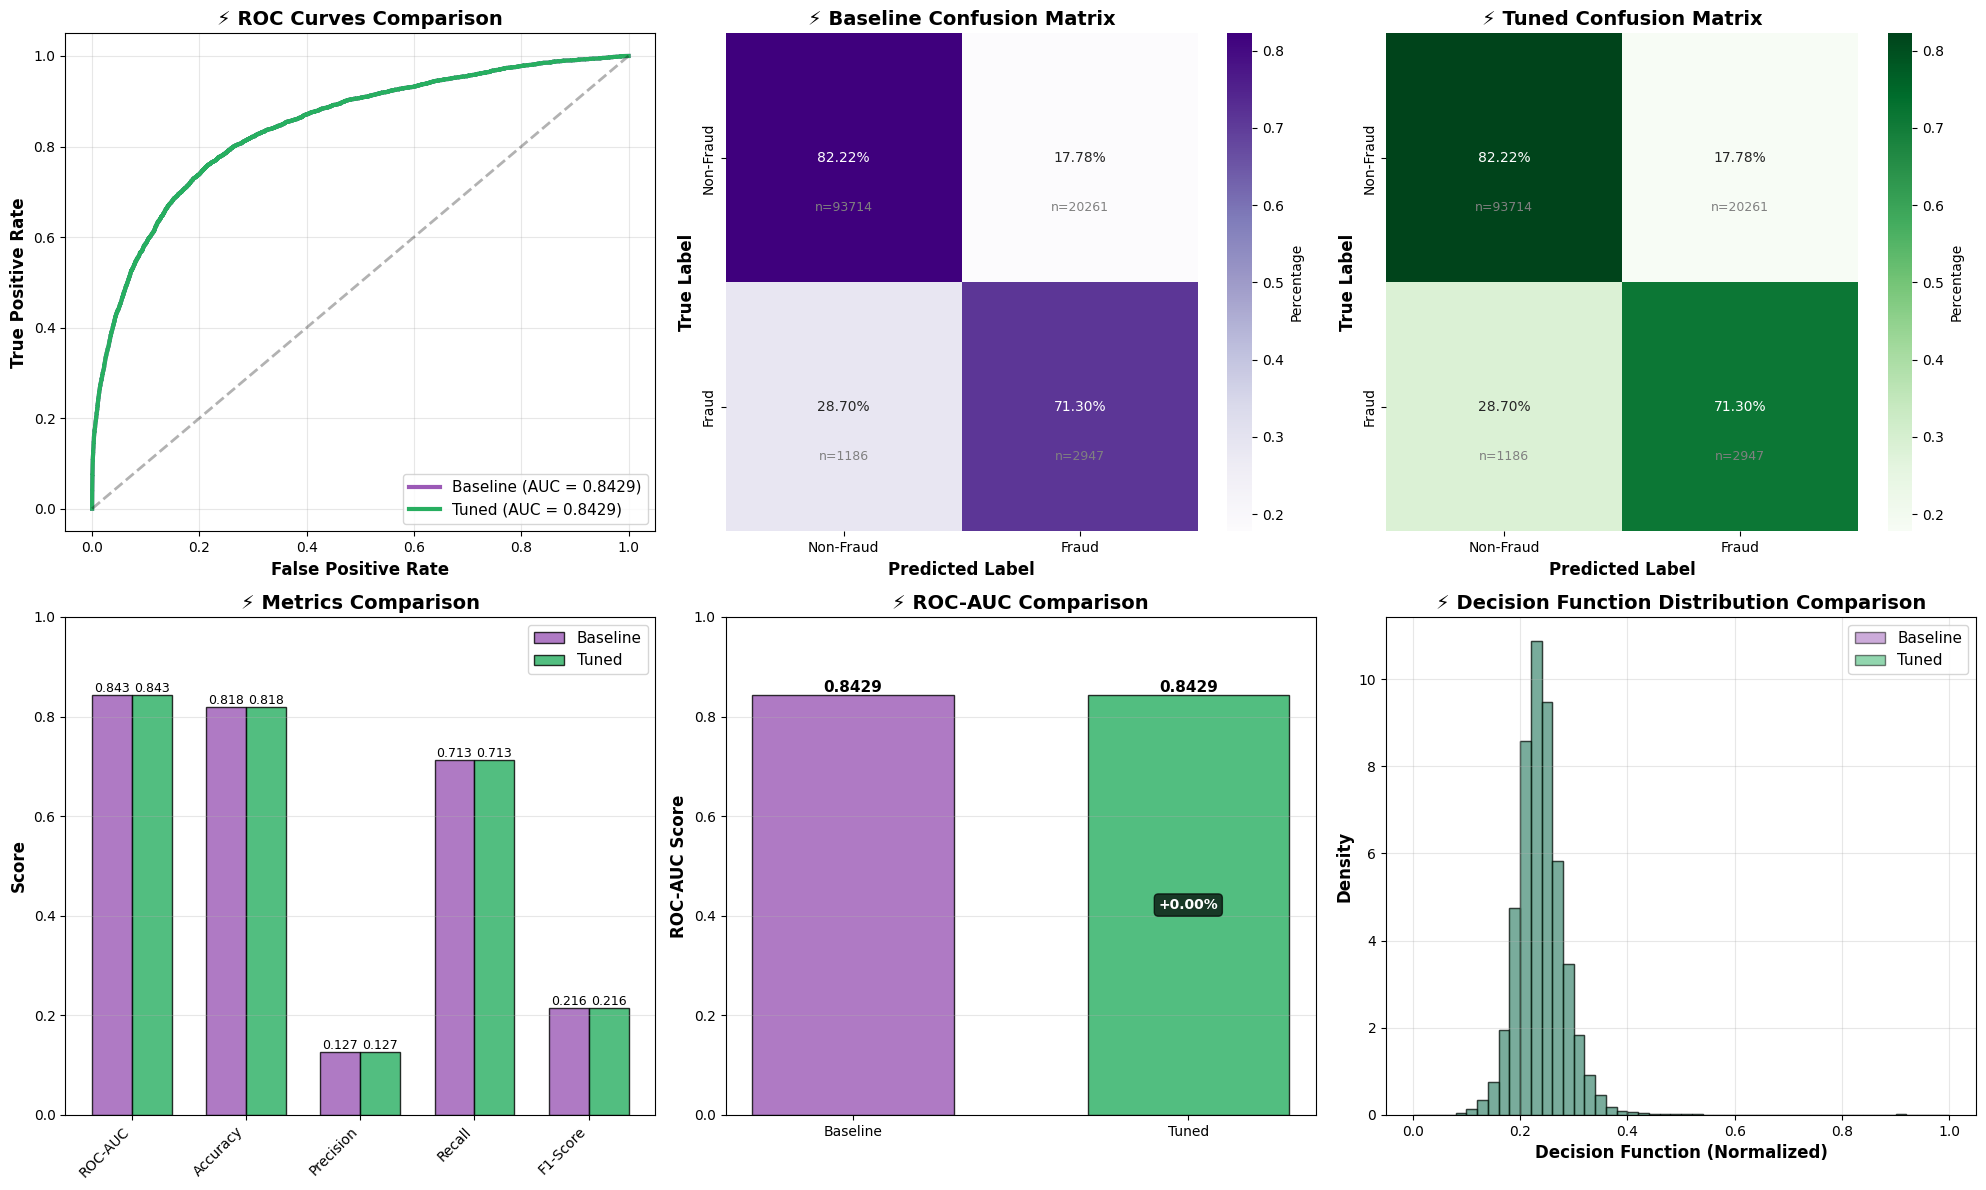


📊 DETAILED COMPARISON:

Metric          Baseline     Tuned        Change      
------------------------------------------------------------
ROC-AUC         0.8429       0.8429       +0.0000
Accuracy        0.8184       0.8184       +0.0000
Precision       0.1270       0.1270       +0.0000
Recall          0.7130       0.7130       +0.0000
F1-Score        0.2156       0.2156       +0.0000

✅ Comparison visualization completed!


In [31]:
# ===================================
# COMPARE BASELINE VS TUNED SVM
# ===================================

print("\n📊 COMPARING BASELINE VS TUNED SVM")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. ROC Curves Comparison
fpr_svm_base, tpr_svm_base, _ = roc_curve(y_val, y_val_decision_svm)
fpr_svm_best, tpr_svm_best, _ = roc_curve(y_val, y_val_decision_svm_best)

axes[0, 0].plot(fpr_svm_base, tpr_svm_base, color='#9B59B6', lw=3, 
                label=f'Baseline (AUC = {val_roc_auc_svm:.4f})')
axes[0, 0].plot(fpr_svm_best, tpr_svm_best, color='#27AE60', lw=3, 
                label=f'Tuned (AUC = {val_roc_auc_svm_best:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3)
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('⚡ ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. Baseline Confusion Matrix
cm_svm_base = confusion_matrix(y_val, y_val_pred_svm)
cm_svm_base_norm = cm_svm_base.astype('float') / cm_svm_base.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_svm_base_norm, annot=True, fmt='.2%', cmap='Purples',
            cbar_kws={'label': 'Percentage'}, ax=axes[0, 1],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 1].set_title('⚡ Baseline Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts
for i in range(2):
    for j in range(2):
        axes[0, 1].text(j+0.5, i+0.7, f'n={cm_svm_base[i,j]}',
                       ha='center', va='center', fontsize=9, color='gray')

# 3. Tuned Confusion Matrix
cm_svm_best = confusion_matrix(y_val, y_val_pred_svm_best)
cm_svm_best_norm = cm_svm_best.astype('float') / cm_svm_best.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_svm_best_norm, annot=True, fmt='.2%', cmap='Greens',
            cbar_kws={'label': 'Percentage'}, ax=axes[0, 2],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 2].set_title('⚡ Tuned Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts
for i in range(2):
    for j in range(2):
        axes[0, 2].text(j+0.5, i+0.7, f'n={cm_svm_best[i,j]}',
                       ha='center', va='center', fontsize=9, color='gray')

# 4. Metrics Comparison Bar Chart
metrics_names_svm_comp = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
baseline_metrics_svm = [val_roc_auc_svm, val_accuracy_svm, val_precision_svm, val_recall_svm, val_f1_svm]
tuned_metrics_svm = [val_roc_auc_svm_best, val_accuracy_svm_best, val_precision_svm_best, val_recall_svm_best, val_f1_svm_best]

x_compare_svm = np.arange(len(metrics_names_svm_comp))
width_compare_svm = 0.35

bars1_svm = axes[1, 0].bar(x_compare_svm - width_compare_svm/2, baseline_metrics_svm, width_compare_svm,
                          label='Baseline', color='#9B59B6', alpha=0.8, edgecolor='black')
bars2_svm = axes[1, 0].bar(x_compare_svm + width_compare_svm/2, tuned_metrics_svm, width_compare_svm,
                          label='Tuned', color='#27AE60', alpha=0.8, edgecolor='black')

axes[1, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('⚡ Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x_compare_svm)
axes[1, 0].set_xticklabels(metrics_names_svm_comp, rotation=45, ha='right')
axes[1, 0].legend(fontsize=11)
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1_svm, bars2_svm]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 5. ROC-AUC Comparison
models_svm = ['Baseline', 'Tuned']
aucs_svm = [val_roc_auc_svm, val_roc_auc_svm_best]
colors_svm_auc = ['#9B59B6', '#27AE60']

bars_svm_auc = axes[1, 1].bar(models_svm, aucs_svm, color=colors_svm_auc, alpha=0.8, edgecolor='black', width=0.6)
axes[1, 1].set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('⚡ ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels and improvement
for i, (bar, auc) in enumerate(zip(bars_svm_auc, aucs_svm)):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{auc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    if i == 1:  # Tuned model
        improvement_svm = ((aucs_svm[1] - aucs_svm[0]) / aucs_svm[0]) * 100
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height/2,
                       f'{improvement_svm:+.2f}%', ha='center', va='center',
                       fontsize=10, fontweight='bold', color='white',
                       bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

# 6. Decision Function Distribution Comparison
# Normalize both decision functions
decision_min_base = y_val_decision_svm.min()
decision_max_base = y_val_decision_svm.max()
y_val_decision_norm_base = (y_val_decision_svm - decision_min_base) / (decision_max_base - decision_min_base)

decision_min_best = y_val_decision_svm_best.min()
decision_max_best = y_val_decision_svm_best.max()
y_val_decision_norm_best = (y_val_decision_svm_best - decision_min_best) / (decision_max_best - decision_min_best)

axes[1, 2].hist(y_val_decision_norm_base, bins=50, alpha=0.5, label='Baseline',
               color='#9B59B6', edgecolor='black', density=True)
axes[1, 2].hist(y_val_decision_norm_best, bins=50, alpha=0.5, label='Tuned',
               color='#27AE60', edgecolor='black', density=True)
axes[1, 2].set_xlabel('Decision Function (Normalized)', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Density', fontsize=12, fontweight='bold')
axes[1, 2].set_title('⚡ Decision Function Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 2].legend(fontsize=11)
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\n📊 DETAILED COMPARISON:")
print(f"\n{'Metric':<15} {'Baseline':<12} {'Tuned':<12} {'Change':<12}")
print("-" * 60)
print(f"{'ROC-AUC':<15} {val_roc_auc_svm:<12.4f} {val_roc_auc_svm_best:<12.4f} {val_roc_auc_svm_best - val_roc_auc_svm:+.4f}")
print(f"{'Accuracy':<15} {val_accuracy_svm:<12.4f} {val_accuracy_svm_best:<12.4f} {val_accuracy_svm_best - val_accuracy_svm:+.4f}")
print(f"{'Precision':<15} {val_precision_svm:<12.4f} {val_precision_svm_best:<12.4f} {val_precision_svm_best - val_precision_svm:+.4f}")
print(f"{'Recall':<15} {val_recall_svm:<12.4f} {val_recall_svm_best:<12.4f} {val_recall_svm_best - val_recall_svm:+.4f}")
print(f"{'F1-Score':<15} {val_f1_svm:<12.4f} {val_f1_svm_best:<12.4f} {val_f1_svm_best - val_f1_svm:+.4f}")

print("\n✅ Comparison visualization completed!")

## Test Evaluation

In [32]:
# ===================================
# SVM - TEST EVALUATION
# ===================================

print("🏆 SELECTING BEST SVM MODEL")
print("="*70)

# Compare baseline vs tuned on validation set
print(f"\n📊 Validation Performance Comparison:")
print(f"   Baseline ROC-AUC: {val_roc_auc_svm:.4f}")
print(f"   Tuned ROC-AUC:    {val_roc_auc_svm_best:.4f}")

if val_roc_auc_svm_best >= val_roc_auc_svm:
    best_svm_model = best_svm
    best_svm_name = "Tuned SVM"
    best_svm_auc = val_roc_auc_svm_best
else:
    best_svm_model = baseline_svm
    best_svm_name = "Baseline SVM"
    best_svm_auc = val_roc_auc_svm

print(f"\n✅ Selected: {best_svm_name} (Validation ROC-AUC: {best_svm_auc:.4f})")

# Test on test set
print("\n🧪 TESTING ON TEST SET")
print("="*70)

y_test_pred_svm = best_svm_model.predict(X_test_processed)
y_test_decision_svm = best_svm_model.decision_function(X_test_processed)

# Calculate metrics
test_roc_auc_svm = roc_auc_score(y_test, y_test_decision_svm)
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
test_precision_svm = precision_score(y_test, y_test_pred_svm, zero_division=0)
test_recall_svm = recall_score(y_test, y_test_pred_svm, zero_division=0)
test_f1_svm = f1_score(y_test, y_test_pred_svm, zero_division=0)

print(f"\n📊 TEST SET PERFORMANCE ({best_svm_name}):")
print(f"   ROC-AUC:   {test_roc_auc_svm:.4f}")
print(f"   Accuracy:  {test_accuracy_svm:.4f}")
print(f"   Precision: {test_precision_svm:.4f}")
print(f"   Recall:    {test_recall_svm:.4f}")
print(f"   F1-Score:  {test_f1_svm:.4f}")

# Confusion Matrix Analysis
cm_test_svm = confusion_matrix(y_test, y_test_pred_svm)
print(f"\n📋 Confusion Matrix:")
print(f"   True Negatives:  {cm_test_svm[0, 0]}")
print(f"   False Positives: {cm_test_svm[0, 1]}")
print(f"   False Negatives: {cm_test_svm[1, 0]}")
print(f"   True Positives:  {cm_test_svm[1, 1]}")

test_fraud_detection_rate_svm = cm_test_svm[1, 1] / cm_test_svm[1].sum()
test_false_alarm_rate_svm = cm_test_svm[0, 1] / cm_test_svm[0].sum()

print(f"\n🎯 KEY INSIGHTS:")
print(f"   Fraud Detection Rate: {test_fraud_detection_rate_svm:.2%} ({cm_test_svm[1, 1]}/{cm_test_svm[1].sum()} frauds caught)")
print(f"   False Alarm Rate:     {test_false_alarm_rate_svm:.2%} ({cm_test_svm[0, 1]}/{cm_test_svm[0].sum()} false alarms)")

# Classification Report
print(f"\n📊 Classification Report:")
print(classification_report(y_test, y_test_pred_svm, target_names=['Non-Fraud', 'Fraud'], zero_division=0))

# Store results
test_svm_results = {
    'model': best_svm_name,
    'test_roc_auc': test_roc_auc_svm,
    'test_accuracy': test_accuracy_svm,
    'test_precision': test_precision_svm,
    'test_recall': test_recall_svm,
    'test_f1': test_f1_svm,
    'validation_roc_auc': best_svm_auc
}

print("\n✅ Test evaluation completed!")

🏆 SELECTING BEST SVM MODEL

📊 Validation Performance Comparison:
   Baseline ROC-AUC: 0.8429
   Tuned ROC-AUC:    0.8429

✅ Selected: Tuned SVM (Validation ROC-AUC: 0.8429)

🧪 TESTING ON TEST SET

📊 TEST SET PERFORMANCE (Tuned SVM):
   ROC-AUC:   0.8591
   Accuracy:  0.8178
   Precision: 0.1320
   Recall:    0.7573
   F1-Score:  0.2248

📋 Confusion Matrix:
   True Negatives:  2337
   False Positives: 513
   False Negatives: 25
   True Positives:  78

🎯 KEY INSIGHTS:
   Fraud Detection Rate: 75.73% (78/103 frauds caught)
   False Alarm Rate:     18.00% (513/2850 false alarms)

📊 Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.82      0.90      2850
       Fraud       0.13      0.76      0.22       103

    accuracy                           0.82      2953
   macro avg       0.56      0.79      0.56      2953
weighted avg       0.96      0.82      0.87      2953


✅ Test evaluation completed!



📊 VISUALIZING SVM TEST RESULTS


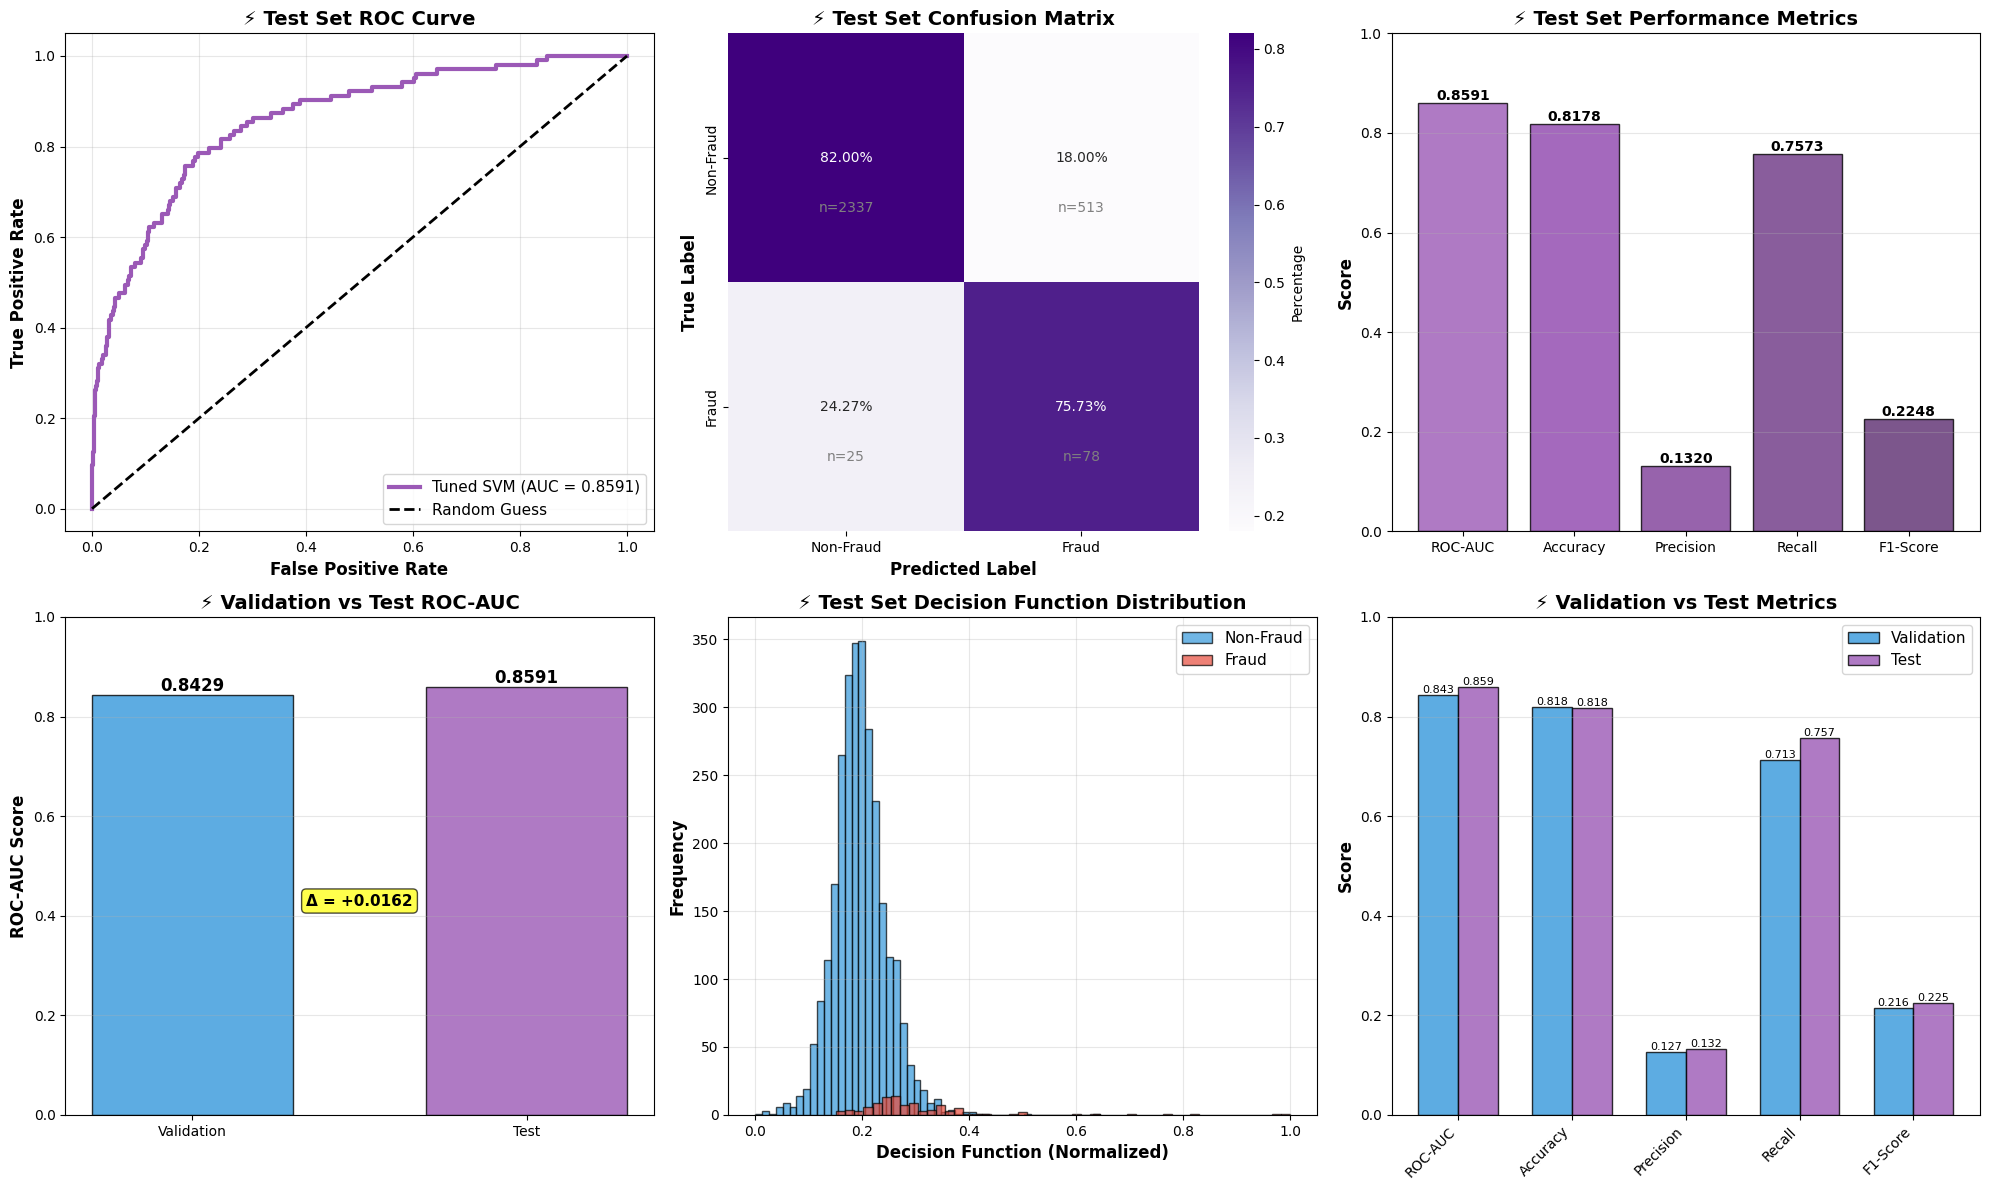


✅ Test visualization completed!

🎉 EXPERIMENT: SVM - COMPLETED!


In [33]:
# ===================================
# VISUALIZE SVM TEST RESULTS
# ===================================

print("\n📊 VISUALIZING SVM TEST RESULTS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Test ROC Curve
fpr_test_svm, tpr_test_svm, _ = roc_curve(y_test, y_test_decision_svm)

axes[0, 0].plot(fpr_test_svm, tpr_test_svm, color='#9B59B6', lw=3,
                label=f'{best_svm_name} (AUC = {test_roc_auc_svm:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('⚡ Test Set ROC Curve', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. Test Confusion Matrix
cm_test_svm_norm = cm_test_svm.astype('float') / cm_test_svm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_test_svm_norm, annot=True, fmt='.2%', cmap='Purples',
            cbar_kws={'label': 'Percentage'}, ax=axes[0, 1],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 1].set_title('⚡ Test Set Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts
for i in range(2):
    for j in range(2):
        axes[0, 1].text(j+0.5, i+0.7, f'n={cm_test_svm[i,j]}',
                       ha='center', va='center', fontsize=10, color='gray')

# 3. Test Metrics Bar Chart
metrics_names_test_svm = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values_test_svm = [test_roc_auc_svm, test_accuracy_svm, test_precision_svm, test_recall_svm, test_f1_svm]
colors_test_svm = ['#9B59B6', '#8E44AD', '#7D3C98', '#6C3483', '#5B2C6F']

bars_test_svm = axes[0, 2].bar(metrics_names_test_svm, metrics_values_test_svm,
                              color=colors_test_svm, alpha=0.8, edgecolor='black')
axes[0, 2].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0, 2].set_title('⚡ Test Set Performance Metrics', fontsize=14, fontweight='bold')
axes[0, 2].set_ylim([0, 1])
axes[0, 2].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars_test_svm:
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Validation vs Test Comparison
datasets = ['Validation', 'Test']
roc_aucs_svm = [best_svm_auc, test_roc_auc_svm]
colors_compare_svm = ['#3498DB', '#9B59B6']

bars_compare_svm = axes[1, 0].bar(datasets, roc_aucs_svm, color=colors_compare_svm,
                                 alpha=0.8, edgecolor='black', width=0.6)
axes[1, 0].set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('⚡ Validation vs Test ROC-AUC', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, auc in zip(bars_compare_svm, roc_aucs_svm):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{auc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add difference
diff_svm = test_roc_auc_svm - best_svm_auc
axes[1, 0].text(0.5, max(roc_aucs_svm)/2,
               f'Δ = {diff_svm:+.4f}', ha='center', va='center',
               fontsize=11, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# 5. Test Decision Function Distribution
# Normalize decision values
decision_min_test = y_test_decision_svm.min()
decision_max_test = y_test_decision_svm.max()
y_test_decision_normalized = (y_test_decision_svm - decision_min_test) / (decision_max_test - decision_min_test)

axes[1, 1].hist(y_test_decision_normalized[y_test == 0], bins=50, alpha=0.7,
               label='Non-Fraud', color='#3498DB', edgecolor='black')
axes[1, 1].hist(y_test_decision_normalized[y_test == 1], bins=50, alpha=0.7,
               label='Fraud', color='#E74C3C', edgecolor='black')
axes[1, 1].set_xlabel('Decision Function (Normalized)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 1].set_title('⚡ Test Set Decision Function Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

# 6. Comprehensive Metrics Comparison (Val vs Test)
val_metrics_svm = [best_svm_auc, 
                  val_accuracy_svm_best if best_svm_name == "Tuned SVM" else val_accuracy_svm,
                  val_precision_svm_best if best_svm_name == "Tuned SVM" else val_precision_svm,
                  val_recall_svm_best if best_svm_name == "Tuned SVM" else val_recall_svm,
                  val_f1_svm_best if best_svm_name == "Tuned SVM" else val_f1_svm]

test_metrics_svm = [test_roc_auc_svm, test_accuracy_svm, test_precision_svm, test_recall_svm, test_f1_svm]

x_comp = np.arange(len(metrics_names_test_svm))
width_comp = 0.35

bars_val_svm = axes[1, 2].bar(x_comp - width_comp/2, val_metrics_svm, width_comp,
                             label='Validation', color='#3498DB', alpha=0.8, edgecolor='black')
bars_test_svm2 = axes[1, 2].bar(x_comp + width_comp/2, test_metrics_svm, width_comp,
                               label='Test', color='#9B59B6', alpha=0.8, edgecolor='black')

axes[1, 2].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 2].set_title('⚡ Validation vs Test Metrics', fontsize=14, fontweight='bold')
axes[1, 2].set_xticks(x_comp)
axes[1, 2].set_xticklabels(metrics_names_test_svm, rotation=45, ha='right')
axes[1, 2].legend(fontsize=11)
axes[1, 2].set_ylim([0, 1])
axes[1, 2].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars_val_svm, bars_test_svm2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n✅ Test visualization completed!")
print("\n" + "="*70)
print("🎉 EXPERIMENT: SVM - COMPLETED!")
print("="*70)

# XGboost

## Baseline Model

In [34]:
# ===================================
# XGBOOST - BASELINE
# ===================================

import xgboost as xgb

print("🚀 Training Baseline XGBoost Model")
print("="*70)

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = len(y_train_processed[y_train_processed==0]) / len(y_train_processed[y_train_processed==1])

baseline_xgb = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbosity=1,
    eval_metric='logloss'
)

print("\n🔄 Training on processed train set...")
print(f"   Training samples: {X_train_processed.shape[0]}")
print(f"   Features: {X_train_processed.shape[1]}")

baseline_xgb.fit(X_train_processed, y_train_processed)
print("✅ Training completed!")

print("\n🔮 Making predictions on validation set...")
y_val_pred_xgb = baseline_xgb.predict(X_val_processed)
y_val_pred_proba_xgb = baseline_xgb.predict_proba(X_val_processed)[:, 1]

# Calculate metrics
val_roc_auc_xgb = roc_auc_score(y_val, y_val_pred_proba_xgb)
val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
val_precision_xgb = precision_score(y_val, y_val_pred_xgb, zero_division=0)
val_recall_xgb = recall_score(y_val, y_val_pred_xgb, zero_division=0)
val_f1_xgb = f1_score(y_val, y_val_pred_xgb, zero_division=0)

print("\n📊 BASELINE XGBOOST PERFORMANCE:")
print(f"   ROC-AUC:   {val_roc_auc_xgb:.4f}")
print(f"   Accuracy:  {val_accuracy_xgb:.4f}")
print(f"   Precision: {val_precision_xgb:.4f}")
print(f"   Recall:    {val_recall_xgb:.4f}")
print(f"   F1-Score:  {val_f1_xgb:.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
print(f"\n📋 Confusion Matrix:")
print(f"   True Negatives:  {cm_xgb[0, 0]}")
print(f"   False Positives: {cm_xgb[0, 1]}")
print(f"   False Negatives: {cm_xgb[1, 0]}")
print(f"   True Positives:  {cm_xgb[1, 1]}")

# Classification Report
print(f"\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Fraud', 'Fraud'], zero_division=0))

# Feature importance (top 10)
feature_importance = pd.DataFrame({
    'feature': [f'feature_{i}' for i in range(X_train_processed.shape[1])],
    'importance': baseline_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔝 Top 10 Important Features:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

# Store results
baseline_xgb_results = {
    'model': 'Baseline XGBoost',
    'val_roc_auc': val_roc_auc_xgb,
    'val_accuracy': val_accuracy_xgb,
    'val_precision': val_precision_xgb,
    'val_recall': val_recall_xgb,
    'val_f1': val_f1_xgb
}

print("\n✅ Baseline XGBoost training completed!")

🚀 Training Baseline XGBoost Model

🔄 Training on processed train set...
   Training samples: 592672
   Features: 114
✅ Training completed!

🔮 Making predictions on validation set...

📊 BASELINE XGBOOST PERFORMANCE:
   ROC-AUC:   0.9177
   Accuracy:  0.9694
   Precision: 0.5625
   Recall:    0.5652
   F1-Score:  0.5638

📋 Confusion Matrix:
   True Negatives:  112158
   False Positives: 1817
   False Negatives: 1797
   True Positives:  2336

📊 Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.98      0.98    113975
       Fraud       0.56      0.57      0.56      4133

    accuracy                           0.97    118108
   macro avg       0.77      0.77      0.77    118108
weighted avg       0.97      0.97      0.97    118108


🔝 Top 10 Important Features:
   feature_7: 0.1092
   feature_98: 0.0451
   feature_9: 0.0436
   feature_109: 0.0372
   feature_69: 0.0345
   feature_12: 0.0337
   feature_37: 0.0336
   feature_67: 0.0304


📊 VISUALIZING BASELINE XGBOOST PERFORMANCE


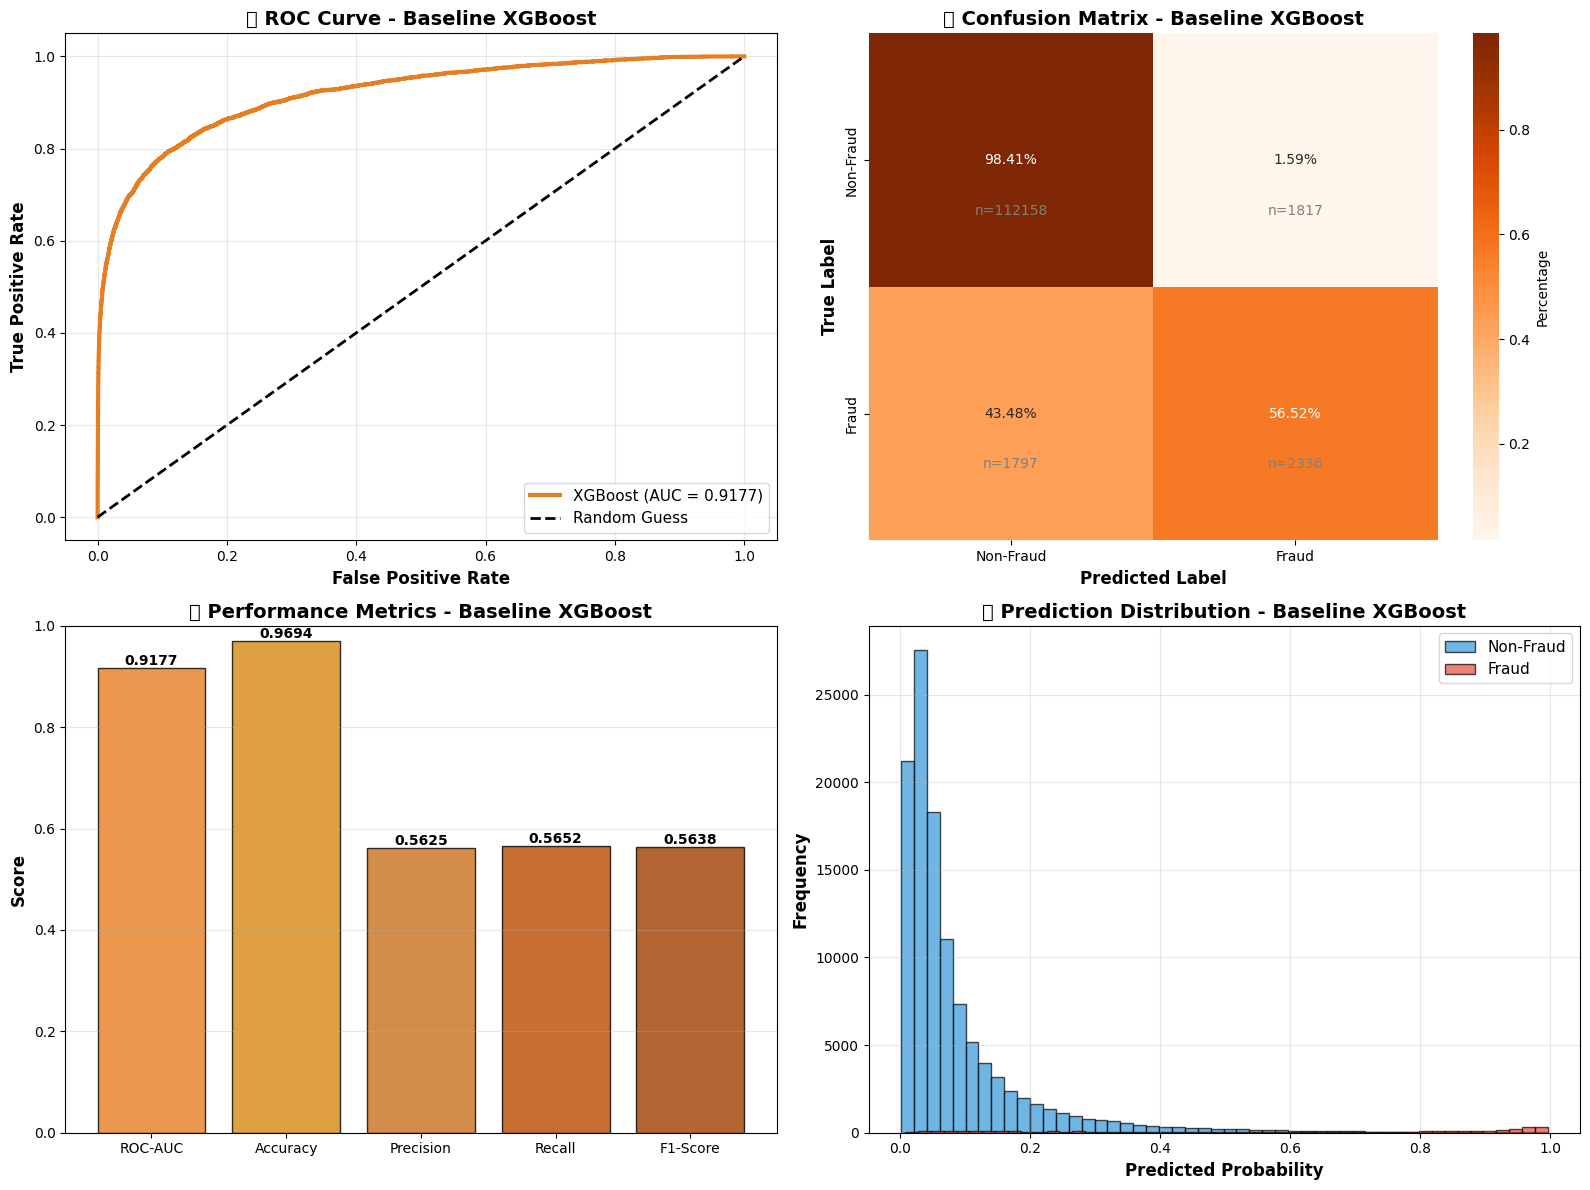


🎯 KEY INSIGHTS:
   Fraud Detection Rate: 56.52% (2336/4133 frauds caught)
   False Alarm Rate:     1.59% (1817/113975 false alarms)
   Number of Trees:      100
   Max Tree Depth:       6

✅ Baseline XGBoost visualization completed!


In [35]:
# ===================================
# VISUALIZE BASELINE XGBOOST
# ===================================

print("\n📊 VISUALIZING BASELINE XGBOOST PERFORMANCE")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_val, y_val_pred_proba_xgb)
roc_auc_xgb = roc_auc_score(y_val, y_val_pred_proba_xgb)

axes[0, 0].plot(fpr_xgb, tpr_xgb, color='#E67E22', lw=3, 
                label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('🚀 ROC Curve - Baseline XGBoost', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. Confusion Matrix
cm_xgb_normalized = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_xgb_normalized, annot=True, fmt='.2%', cmap='Oranges', 
            cbar_kws={'label': 'Percentage'}, ax=axes[0, 1],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 1].set_title('🚀 Confusion Matrix - Baseline XGBoost', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts
for i in range(2):
    for j in range(2):
        axes[0, 1].text(j+0.5, i+0.7, f'n={cm_xgb[i,j]}', 
                       ha='center', va='center', fontsize=10, color='gray')

# 3. Metrics Bar Chart
metrics_names_xgb = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values_xgb = [val_roc_auc_xgb, val_accuracy_xgb, val_precision_xgb, val_recall_xgb, val_f1_xgb]
colors_xgb = ['#E67E22', '#D68910', '#CA6F1E', '#BA4A00', '#A04000']

bars_xgb = axes[1, 0].bar(metrics_names_xgb, metrics_values_xgb, color=colors_xgb, alpha=0.8, edgecolor='black')
axes[1, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('🚀 Performance Metrics - Baseline XGBoost', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars_xgb:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Prediction Distribution
axes[1, 1].hist(y_val_pred_proba_xgb[y_val == 0], bins=50, alpha=0.7, 
               label='Non-Fraud', color='#3498DB', edgecolor='black')
axes[1, 1].hist(y_val_pred_proba_xgb[y_val == 1], bins=50, alpha=0.7, 
               label='Fraud', color='#E74C3C', edgecolor='black')
axes[1, 1].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 1].set_title('🚀 Prediction Distribution - Baseline XGBoost', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
fraud_detection_rate_xgb = cm_xgb[1, 1] / cm_xgb[1].sum()
false_alarm_rate_xgb = cm_xgb[0, 1] / cm_xgb[0].sum()

print(f"\n🎯 KEY INSIGHTS:")
print(f"   Fraud Detection Rate: {fraud_detection_rate_xgb:.2%} ({cm_xgb[1, 1]}/{cm_xgb[1].sum()} frauds caught)")
print(f"   False Alarm Rate:     {false_alarm_rate_xgb:.2%} ({cm_xgb[0, 1]}/{cm_xgb[0].sum()} false alarms)")
print(f"   Number of Trees:      {baseline_xgb.n_estimators}")
print(f"   Max Tree Depth:       {baseline_xgb.max_depth}")

print("\n✅ Baseline XGBoost visualization completed!")

## Hyperparameter Tuning

In [36]:
# ===================================
# XGBOOST - HYPERPARAMETER TUNING
# ===================================

print("🔧 Hyperparameter Tuning for XGBoost")
print("="*70)

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'min_child_weight': [1, 3]
}

total_combinations_xgb = (len(param_grid_xgb['n_estimators']) * 
                          len(param_grid_xgb['max_depth']) * 
                          len(param_grid_xgb['learning_rate']) * 
                          len(param_grid_xgb['min_child_weight']))

print(f"\n📋 Tuning Configuration:")
print(f"   - n_estimators: {param_grid_xgb['n_estimators']}")
print(f"   - max_depth: {param_grid_xgb['max_depth']}")
print(f"   - learning_rate: {param_grid_xgb['learning_rate']}")
print(f"   - min_child_weight: {param_grid_xgb['min_child_weight']}")
print(f"   - scale_pos_weight: {scale_pos_weight:.2f} (fixed)")
print(f"   - Total combinations: {total_combinations_xgb}")
print(f"   - CV folds: 3")
print(f"   - Total fits: {total_combinations_xgb * 3}")

xgb_tuning = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    eval_metric='logloss'
)

grid_search_xgb = GridSearchCV(
    estimator=xgb_tuning,
    param_grid=param_grid_xgb,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\n🔄 Starting Grid Search...")
start_time_xgb = time.time()
grid_search_xgb.fit(X_train_processed, y_train_processed)
elapsed_time_xgb = time.time() - start_time_xgb

print(f"\n✅ Grid Search completed in {elapsed_time_xgb:.2f} seconds ({elapsed_time_xgb/60:.2f} minutes)")

# Extract best parameters and score
best_xgb_params = grid_search_xgb.best_params_
best_xgb_cv_score = grid_search_xgb.best_score_

print(f"\n🏆 Best Parameters:")
for param, value in best_xgb_params.items():
    print(f"   - {param}: {value}")

print(f"\n📊 Best Cross-Validation ROC-AUC: {best_xgb_cv_score:.4f}")

# Train best model on full training set
print("\n🔄 Training best XGBoost on full training set...")
best_xgb = xgb.XGBClassifier(
    **best_xgb_params,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    eval_metric='logloss'
)
best_xgb.fit(X_train_processed, y_train_processed)
print("✅ Best model training completed!")

# Evaluate best model on validation set
print("\n🔮 Evaluating best XGBoost on validation set...")
y_val_pred_xgb_best = best_xgb.predict(X_val_processed)
y_val_pred_proba_xgb_best = best_xgb.predict_proba(X_val_processed)[:, 1]

val_roc_auc_xgb_best = roc_auc_score(y_val, y_val_pred_proba_xgb_best)
val_accuracy_xgb_best = accuracy_score(y_val, y_val_pred_xgb_best)
val_precision_xgb_best = precision_score(y_val, y_val_pred_xgb_best, zero_division=0)
val_recall_xgb_best = recall_score(y_val, y_val_pred_xgb_best, zero_division=0)
val_f1_xgb_best = f1_score(y_val, y_val_pred_xgb_best, zero_division=0)

print(f"\n📊 BEST XGBOOST PERFORMANCE:")
print(f"   ROC-AUC:   {val_roc_auc_xgb_best:.4f}")
print(f"   Accuracy:  {val_accuracy_xgb_best:.4f}")
print(f"   Precision: {val_precision_xgb_best:.4f}")
print(f"   Recall:    {val_recall_xgb_best:.4f}")
print(f"   F1-Score:  {val_f1_xgb_best:.4f}")

# Compare with baseline
improvement_xgb = ((val_roc_auc_xgb_best - val_roc_auc_xgb) / val_roc_auc_xgb) * 100
print(f"\n📈 Improvement over baseline: {improvement_xgb:+.2f}%")

# Store results in DataFrame for analysis
cv_results_xgb = pd.DataFrame(grid_search_xgb.cv_results_)
cv_results_xgb = cv_results_xgb.sort_values('rank_test_score')

print("\n🔝 Top 10 Parameter Combinations:")
top_10_xgb = cv_results_xgb[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)
for idx, row in top_10_xgb.iterrows():
    print(f"\n   Rank {int(row['rank_test_score'])}:")
    print(f"   Params: {row['params']}")
    print(f"   Mean ROC-AUC: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")

print("\n✅ Hyperparameter tuning completed!")

🔧 Hyperparameter Tuning for XGBoost

📋 Tuning Configuration:
   - n_estimators: [50, 100, 200]
   - max_depth: [3, 6, 10]
   - learning_rate: [0.01, 0.1, 0.3]
   - min_child_weight: [1, 3]
   - scale_pos_weight: 3.33 (fixed)
   - Total combinations: 54
   - CV folds: 3
   - Total fits: 162

🔄 Starting Grid Search...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

✅ Grid Search completed in 614.81 seconds (10.25 minutes)

🏆 Best Parameters:
   - learning_rate: 0.3
   - max_depth: 10
   - min_child_weight: 1
   - n_estimators: 200

📊 Best Cross-Validation ROC-AUC: 0.9965

🔄 Training best XGBoost on full training set...

✅ Grid Search completed in 614.81 seconds (10.25 minutes)

🏆 Best Parameters:
   - learning_rate: 0.3
   - max_depth: 10
   - min_child_weight: 1
   - n_estimators: 200

📊 Best Cross-Validation ROC-AUC: 0.9965

🔄 Training best XGBoost on full training set...
✅ Best model training completed!

🔮 Evaluating best XGBoost on validation set...
✅ Best model traini


📊 COMPARING BASELINE VS TUNED XGBOOST


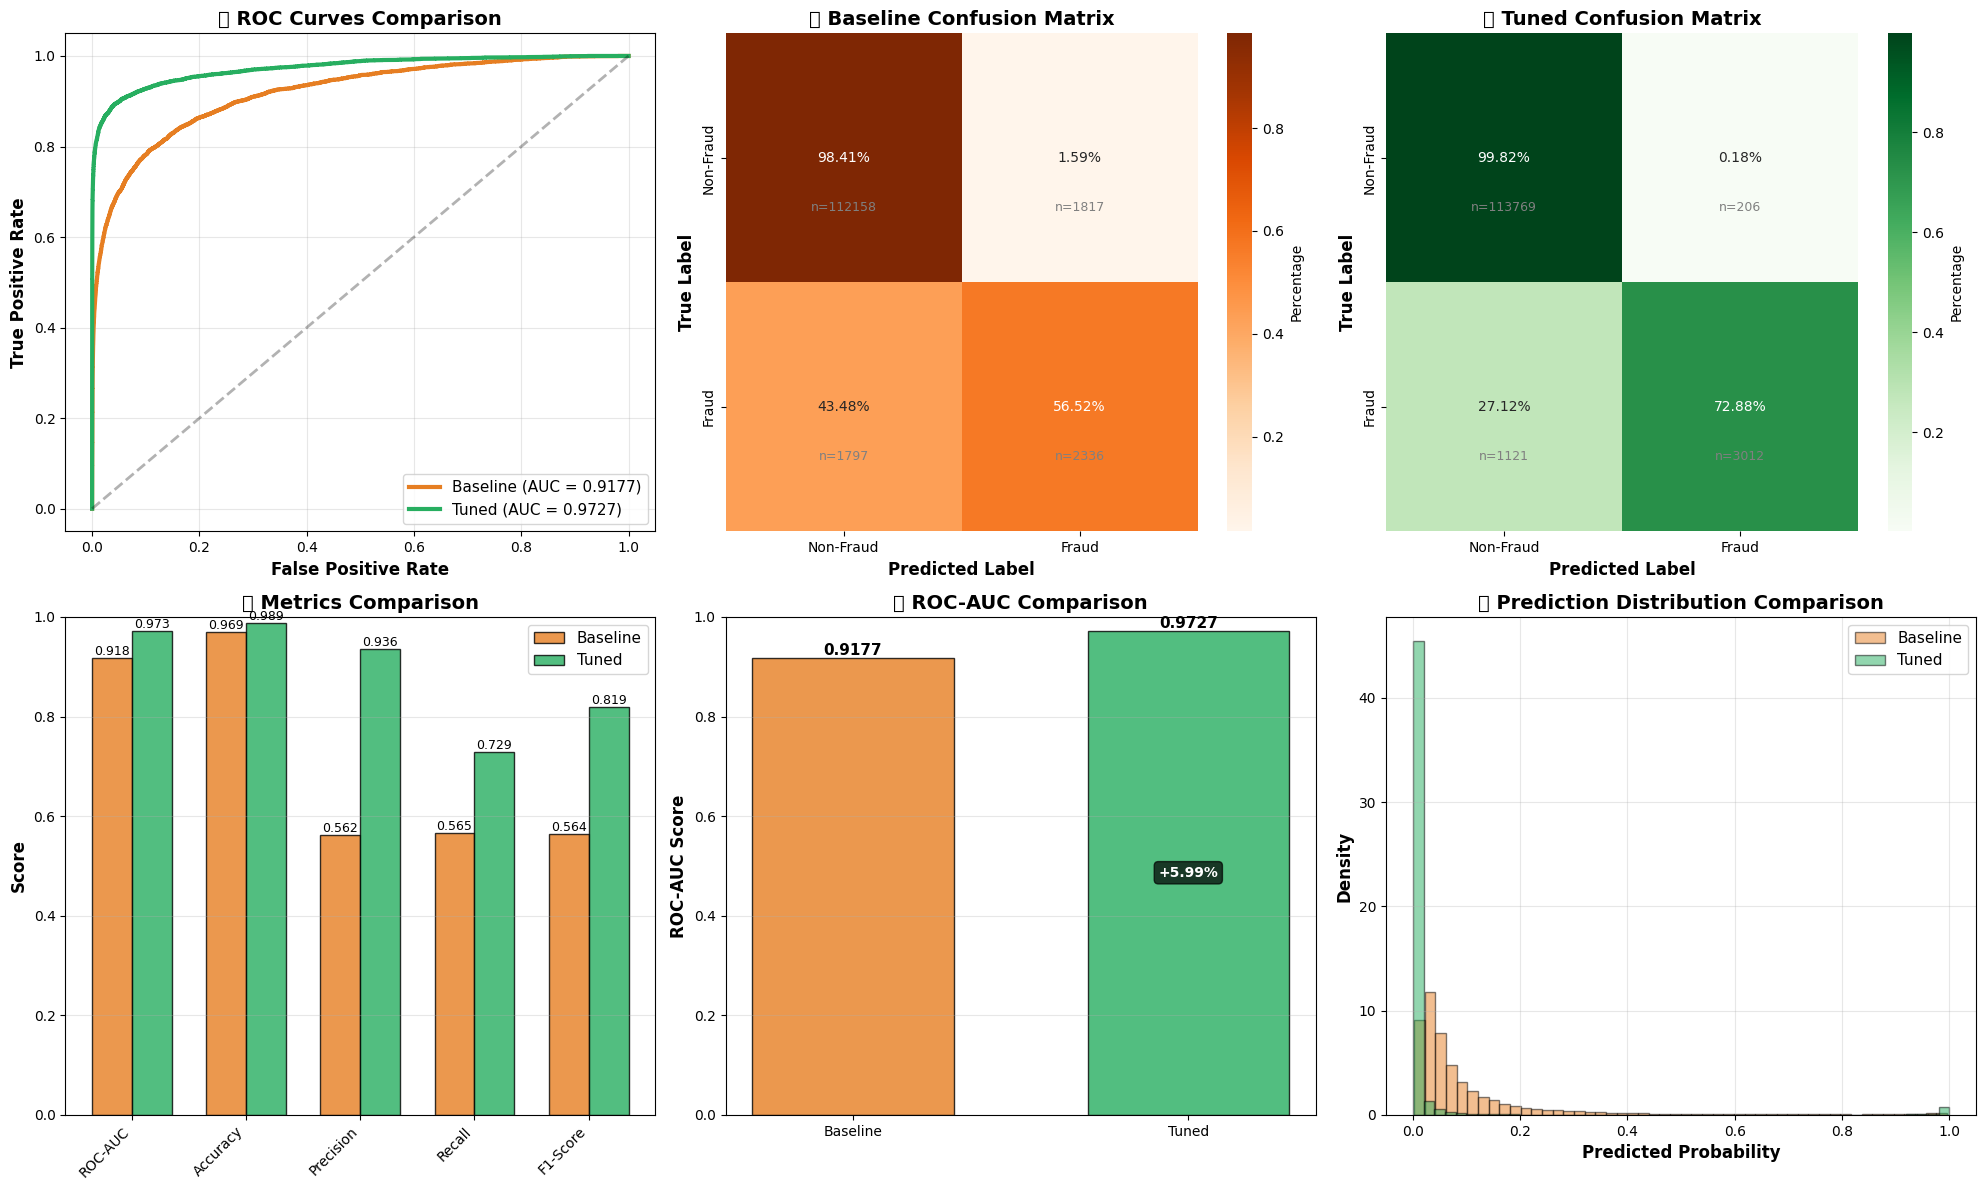


📊 DETAILED COMPARISON:

Metric          Baseline     Tuned        Change      
------------------------------------------------------------
ROC-AUC         0.9177       0.9727       +0.0550
Accuracy        0.9694       0.9888       +0.0194
Precision       0.5625       0.9360       +0.3735
Recall          0.5652       0.7288       +0.1636
F1-Score        0.5638       0.8195       +0.2556

🚀 Model Configuration:
   Baseline - n_estimators: 100, max_depth: 6, lr: 0.1
   Tuned    - n_estimators: 200, max_depth: 10, lr: 0.3

✅ Comparison visualization completed!


In [37]:
# ===================================
# COMPARE BASELINE VS TUNED XGBOOST
# ===================================

print("\n📊 COMPARING BASELINE VS TUNED XGBOOST")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. ROC Curves Comparison
fpr_xgb_base, tpr_xgb_base, _ = roc_curve(y_val, y_val_pred_proba_xgb)
fpr_xgb_best, tpr_xgb_best, _ = roc_curve(y_val, y_val_pred_proba_xgb_best)

axes[0, 0].plot(fpr_xgb_base, tpr_xgb_base, color='#E67E22', lw=3, 
                label=f'Baseline (AUC = {val_roc_auc_xgb:.4f})')
axes[0, 0].plot(fpr_xgb_best, tpr_xgb_best, color='#27AE60', lw=3, 
                label=f'Tuned (AUC = {val_roc_auc_xgb_best:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3)
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('🚀 ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. Baseline Confusion Matrix
cm_xgb_base = confusion_matrix(y_val, y_val_pred_xgb)
cm_xgb_base_norm = cm_xgb_base.astype('float') / cm_xgb_base.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_xgb_base_norm, annot=True, fmt='.2%', cmap='Oranges',
            cbar_kws={'label': 'Percentage'}, ax=axes[0, 1],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 1].set_title('🚀 Baseline Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts
for i in range(2):
    for j in range(2):
        axes[0, 1].text(j+0.5, i+0.7, f'n={cm_xgb_base[i,j]}',
                       ha='center', va='center', fontsize=9, color='gray')

# 3. Tuned Confusion Matrix
cm_xgb_best = confusion_matrix(y_val, y_val_pred_xgb_best)
cm_xgb_best_norm = cm_xgb_best.astype('float') / cm_xgb_best.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_xgb_best_norm, annot=True, fmt='.2%', cmap='Greens',
            cbar_kws={'label': 'Percentage'}, ax=axes[0, 2],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 2].set_title('🚀 Tuned Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts
for i in range(2):
    for j in range(2):
        axes[0, 2].text(j+0.5, i+0.7, f'n={cm_xgb_best[i,j]}',
                       ha='center', va='center', fontsize=9, color='gray')

# 4. Metrics Comparison Bar Chart
metrics_names_xgb_comp = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
baseline_metrics_xgb = [val_roc_auc_xgb, val_accuracy_xgb, val_precision_xgb, val_recall_xgb, val_f1_xgb]
tuned_metrics_xgb = [val_roc_auc_xgb_best, val_accuracy_xgb_best, val_precision_xgb_best, val_recall_xgb_best, val_f1_xgb_best]

x_compare_xgb = np.arange(len(metrics_names_xgb_comp))
width_compare_xgb = 0.35

bars1_xgb = axes[1, 0].bar(x_compare_xgb - width_compare_xgb/2, baseline_metrics_xgb, width_compare_xgb,
                          label='Baseline', color='#E67E22', alpha=0.8, edgecolor='black')
bars2_xgb = axes[1, 0].bar(x_compare_xgb + width_compare_xgb/2, tuned_metrics_xgb, width_compare_xgb,
                          label='Tuned', color='#27AE60', alpha=0.8, edgecolor='black')

axes[1, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('🚀 Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x_compare_xgb)
axes[1, 0].set_xticklabels(metrics_names_xgb_comp, rotation=45, ha='right')
axes[1, 0].legend(fontsize=11)
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1_xgb, bars2_xgb]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 5. ROC-AUC Comparison
models_xgb = ['Baseline', 'Tuned']
aucs_xgb = [val_roc_auc_xgb, val_roc_auc_xgb_best]
colors_xgb_auc = ['#E67E22', '#27AE60']

bars_xgb_auc = axes[1, 1].bar(models_xgb, aucs_xgb, color=colors_xgb_auc, alpha=0.8, edgecolor='black', width=0.6)
axes[1, 1].set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('🚀 ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels and improvement
for i, (bar, auc) in enumerate(zip(bars_xgb_auc, aucs_xgb)):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{auc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    if i == 1:  # Tuned model
        improvement_xgb = ((aucs_xgb[1] - aucs_xgb[0]) / aucs_xgb[0]) * 100
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height/2,
                       f'{improvement_xgb:+.2f}%', ha='center', va='center',
                       fontsize=10, fontweight='bold', color='white',
                       bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

# 6. Prediction Distribution Comparison
axes[1, 2].hist(y_val_pred_proba_xgb, bins=50, alpha=0.5, label='Baseline',
               color='#E67E22', edgecolor='black', density=True)
axes[1, 2].hist(y_val_pred_proba_xgb_best, bins=50, alpha=0.5, label='Tuned',
               color='#27AE60', edgecolor='black', density=True)
axes[1, 2].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Density', fontsize=12, fontweight='bold')
axes[1, 2].set_title('🚀 Prediction Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 2].legend(fontsize=11)
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\n📊 DETAILED COMPARISON:")
print(f"\n{'Metric':<15} {'Baseline':<12} {'Tuned':<12} {'Change':<12}")
print("-" * 60)
print(f"{'ROC-AUC':<15} {val_roc_auc_xgb:<12.4f} {val_roc_auc_xgb_best:<12.4f} {val_roc_auc_xgb_best - val_roc_auc_xgb:+.4f}")
print(f"{'Accuracy':<15} {val_accuracy_xgb:<12.4f} {val_accuracy_xgb_best:<12.4f} {val_accuracy_xgb_best - val_accuracy_xgb:+.4f}")
print(f"{'Precision':<15} {val_precision_xgb:<12.4f} {val_precision_xgb_best:<12.4f} {val_precision_xgb_best - val_precision_xgb:+.4f}")
print(f"{'Recall':<15} {val_recall_xgb:<12.4f} {val_recall_xgb_best:<12.4f} {val_recall_xgb_best - val_recall_xgb:+.4f}")
print(f"{'F1-Score':<15} {val_f1_xgb:<12.4f} {val_f1_xgb_best:<12.4f} {val_f1_xgb_best - val_f1_xgb:+.4f}")

print(f"\n🚀 Model Configuration:")
print(f"   Baseline - n_estimators: {baseline_xgb.n_estimators}, max_depth: {baseline_xgb.max_depth}, lr: {baseline_xgb.learning_rate}")
print(f"   Tuned    - n_estimators: {best_xgb.n_estimators}, max_depth: {best_xgb.max_depth}, lr: {best_xgb.learning_rate}")

print("\n✅ Comparison visualization completed!")

## Test Evaluation

In [38]:
# ===================================
# XGBOOST - TEST EVALUATION
# ===================================

print("🏆 SELECTING BEST XGBOOST MODEL")
print("="*70)

# Compare baseline vs tuned on validation set
print(f"\n📊 Validation Performance Comparison:")
print(f"   Baseline ROC-AUC: {val_roc_auc_xgb:.4f}")
print(f"   Tuned ROC-AUC:    {val_roc_auc_xgb_best:.4f}")

if val_roc_auc_xgb_best >= val_roc_auc_xgb:
    best_xgb_model = best_xgb
    best_xgb_name = "Tuned XGBoost"
    best_xgb_auc = val_roc_auc_xgb_best
else:
    best_xgb_model = baseline_xgb
    best_xgb_name = "Baseline XGBoost"
    best_xgb_auc = val_roc_auc_xgb

print(f"\n✅ Selected: {best_xgb_name} (Validation ROC-AUC: {best_xgb_auc:.4f})")

# Test on test set
print("\n🧪 TESTING ON TEST SET")
print("="*70)

y_test_pred_xgb = best_xgb_model.predict(X_test_processed)
y_test_pred_proba_xgb = best_xgb_model.predict_proba(X_test_processed)[:, 1]

# Calculate metrics
test_roc_auc_xgb = roc_auc_score(y_test, y_test_pred_proba_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
test_precision_xgb = precision_score(y_test, y_test_pred_xgb, zero_division=0)
test_recall_xgb = recall_score(y_test, y_test_pred_xgb, zero_division=0)
test_f1_xgb = f1_score(y_test, y_test_pred_xgb, zero_division=0)

print(f"\n📊 TEST SET PERFORMANCE ({best_xgb_name}):")
print(f"   ROC-AUC:   {test_roc_auc_xgb:.4f}")
print(f"   Accuracy:  {test_accuracy_xgb:.4f}")
print(f"   Precision: {test_precision_xgb:.4f}")
print(f"   Recall:    {test_recall_xgb:.4f}")
print(f"   F1-Score:  {test_f1_xgb:.4f}")

# Confusion Matrix Analysis
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb)
print(f"\n📋 Confusion Matrix:")
print(f"   True Negatives:  {cm_test_xgb[0, 0]}")
print(f"   False Positives: {cm_test_xgb[0, 1]}")
print(f"   False Negatives: {cm_test_xgb[1, 0]}")
print(f"   True Positives:  {cm_test_xgb[1, 1]}")

test_fraud_detection_rate_xgb = cm_test_xgb[1, 1] / cm_test_xgb[1].sum()
test_false_alarm_rate_xgb = cm_test_xgb[0, 1] / cm_test_xgb[0].sum()

print(f"\n🎯 KEY INSIGHTS:")
print(f"   Fraud Detection Rate: {test_fraud_detection_rate_xgb:.2%} ({cm_test_xgb[1, 1]}/{cm_test_xgb[1].sum()} frauds caught)")
print(f"   False Alarm Rate:     {test_false_alarm_rate_xgb:.2%} ({cm_test_xgb[0, 1]}/{cm_test_xgb[0].sum()} false alarms)")

# Classification Report
print(f"\n📊 Classification Report:")
print(classification_report(y_test, y_test_pred_xgb, target_names=['Non-Fraud', 'Fraud'], zero_division=0))

# Store results
test_xgb_results = {
    'model': best_xgb_name,
    'test_roc_auc': test_roc_auc_xgb,
    'test_accuracy': test_accuracy_xgb,
    'test_precision': test_precision_xgb,
    'test_recall': test_recall_xgb,
    'test_f1': test_f1_xgb,
    'validation_roc_auc': best_xgb_auc
}

print("\n✅ Test evaluation completed!")

🏆 SELECTING BEST XGBOOST MODEL

📊 Validation Performance Comparison:
   Baseline ROC-AUC: 0.9177
   Tuned ROC-AUC:    0.9727

✅ Selected: Tuned XGBoost (Validation ROC-AUC: 0.9727)

🧪 TESTING ON TEST SET

📊 TEST SET PERFORMANCE (Tuned XGBoost):
   ROC-AUC:   0.9775
   Accuracy:  0.9868
   Precision: 0.9211
   Recall:    0.6796
   F1-Score:  0.7821

📋 Confusion Matrix:
   True Negatives:  2844
   False Positives: 6
   False Negatives: 33
   True Positives:  70

🎯 KEY INSIGHTS:
   Fraud Detection Rate: 67.96% (70/103 frauds caught)
   False Alarm Rate:     0.21% (6/2850 false alarms)

📊 Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.99      1.00      0.99      2850
       Fraud       0.92      0.68      0.78       103

    accuracy                           0.99      2953
   macro avg       0.95      0.84      0.89      2953
weighted avg       0.99      0.99      0.99      2953


✅ Test evaluation completed!



📊 VISUALIZING XGBOOST TEST RESULTS


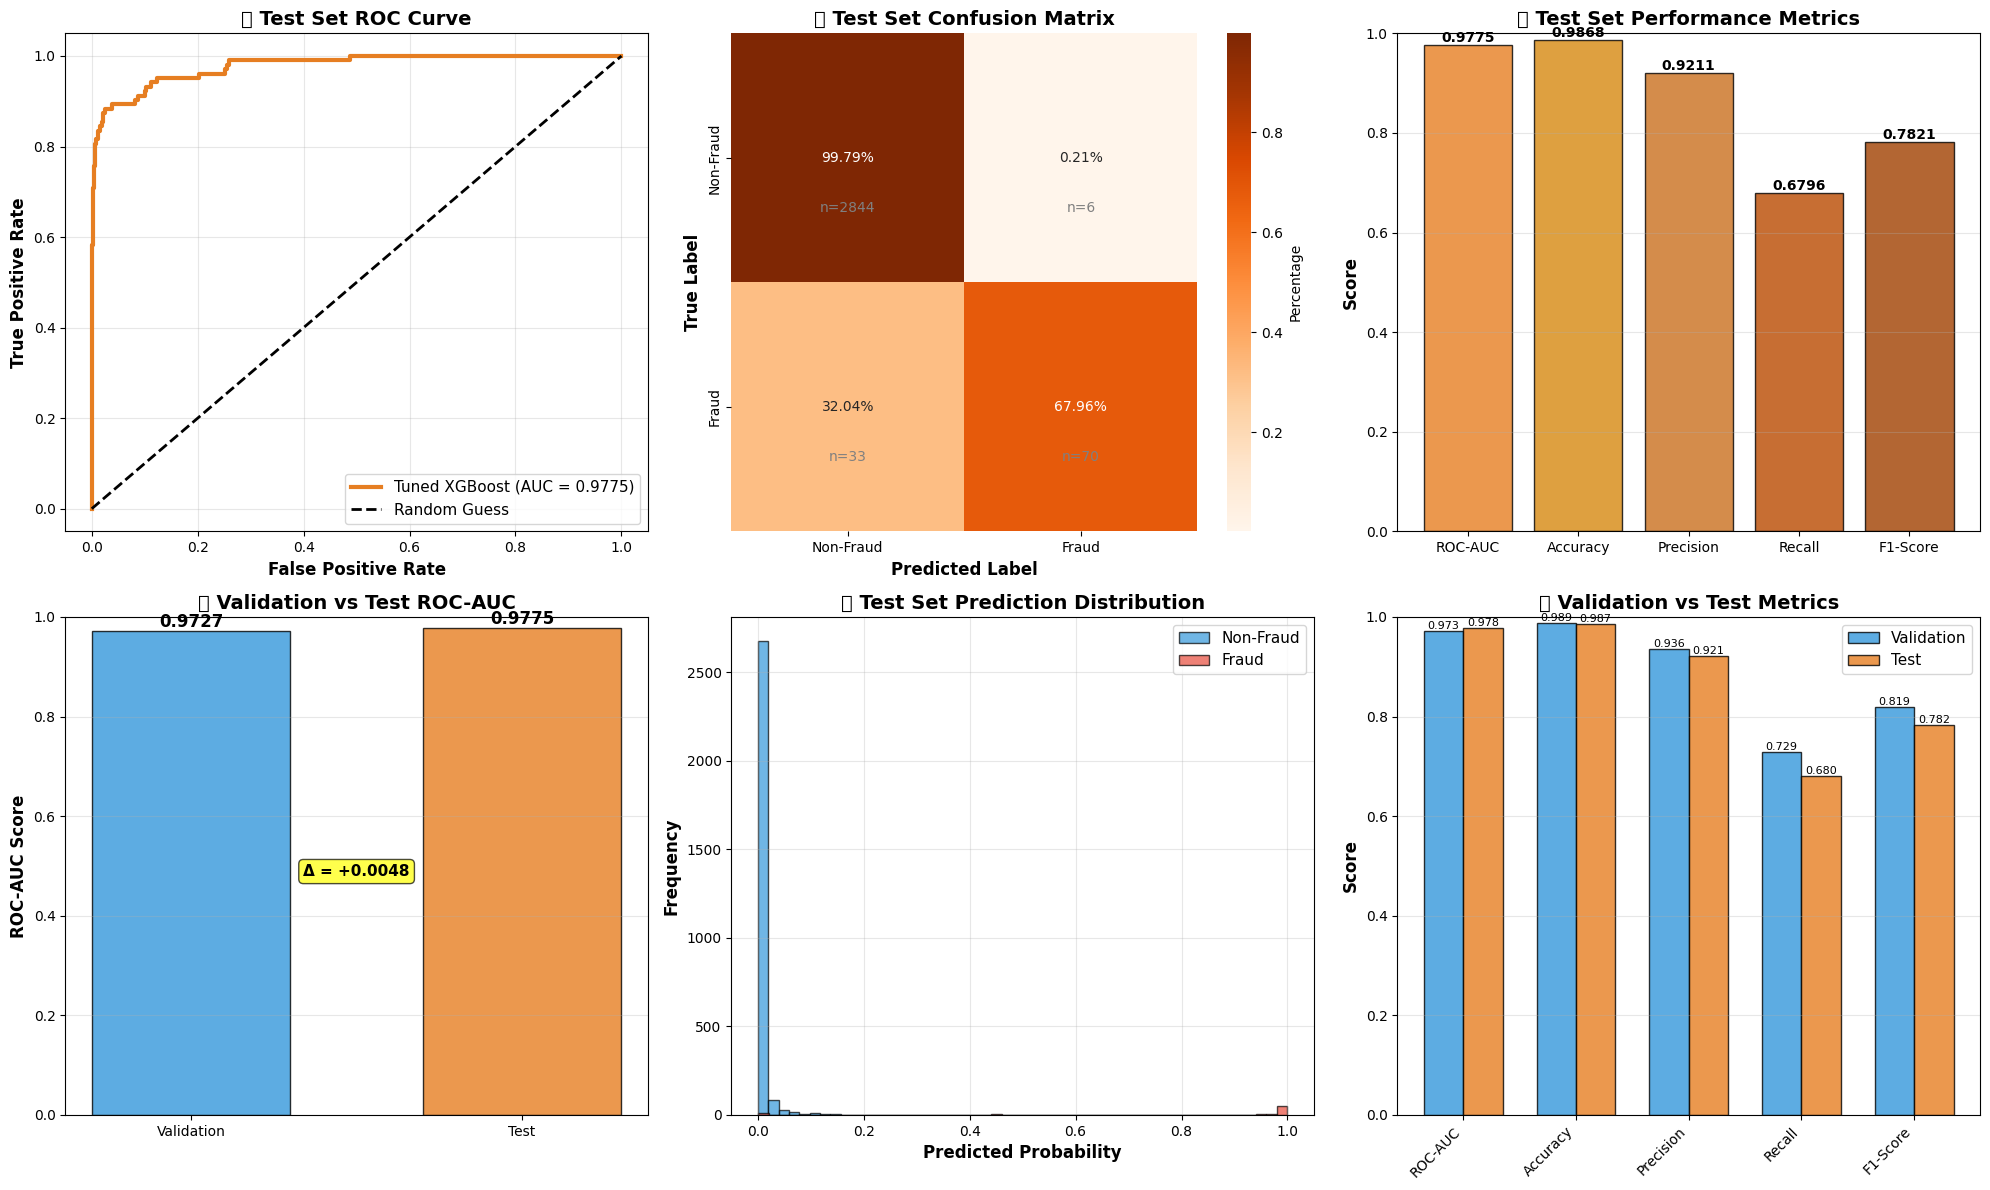


✅ Test visualization completed!

🎉 EXPERIMENT: XGBOOST - COMPLETED!


In [39]:
# ===================================
# VISUALIZE XGBOOST TEST RESULTS
# ===================================

print("\n📊 VISUALIZING XGBOOST TEST RESULTS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Test ROC Curve
fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_test_pred_proba_xgb)

axes[0, 0].plot(fpr_test_xgb, tpr_test_xgb, color='#E67E22', lw=3,
                label=f'{best_xgb_name} (AUC = {test_roc_auc_xgb:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('🚀 Test Set ROC Curve', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. Test Confusion Matrix
cm_test_xgb_norm = cm_test_xgb.astype('float') / cm_test_xgb.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_test_xgb_norm, annot=True, fmt='.2%', cmap='Oranges',
            cbar_kws={'label': 'Percentage'}, ax=axes[0, 1],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 1].set_title('🚀 Test Set Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts
for i in range(2):
    for j in range(2):
        axes[0, 1].text(j+0.5, i+0.7, f'n={cm_test_xgb[i,j]}',
                       ha='center', va='center', fontsize=10, color='gray')

# 3. Test Metrics Bar Chart
metrics_names_test_xgb = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values_test_xgb = [test_roc_auc_xgb, test_accuracy_xgb, test_precision_xgb, test_recall_xgb, test_f1_xgb]
colors_test_xgb = ['#E67E22', '#D68910', '#CA6F1E', '#BA4A00', '#A04000']

bars_test_xgb = axes[0, 2].bar(metrics_names_test_xgb, metrics_values_test_xgb,
                              color=colors_test_xgb, alpha=0.8, edgecolor='black')
axes[0, 2].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0, 2].set_title('🚀 Test Set Performance Metrics', fontsize=14, fontweight='bold')
axes[0, 2].set_ylim([0, 1])
axes[0, 2].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars_test_xgb:
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Validation vs Test Comparison
datasets = ['Validation', 'Test']
roc_aucs_xgb = [best_xgb_auc, test_roc_auc_xgb]
colors_compare_xgb = ['#3498DB', '#E67E22']

bars_compare_xgb = axes[1, 0].bar(datasets, roc_aucs_xgb, color=colors_compare_xgb,
                                 alpha=0.8, edgecolor='black', width=0.6)
axes[1, 0].set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('🚀 Validation vs Test ROC-AUC', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, auc in zip(bars_compare_xgb, roc_aucs_xgb):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{auc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add difference
diff_xgb = test_roc_auc_xgb - best_xgb_auc
axes[1, 0].text(0.5, max(roc_aucs_xgb)/2,
               f'Δ = {diff_xgb:+.4f}', ha='center', va='center',
               fontsize=11, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# 5. Test Prediction Distribution
axes[1, 1].hist(y_test_pred_proba_xgb[y_test == 0], bins=50, alpha=0.7,
               label='Non-Fraud', color='#3498DB', edgecolor='black')
axes[1, 1].hist(y_test_pred_proba_xgb[y_test == 1], bins=50, alpha=0.7,
               label='Fraud', color='#E74C3C', edgecolor='black')
axes[1, 1].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 1].set_title('🚀 Test Set Prediction Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

# 6. Comprehensive Metrics Comparison (Val vs Test)
val_metrics_xgb = [best_xgb_auc, 
                  val_accuracy_xgb_best if best_xgb_name == "Tuned XGBoost" else val_accuracy_xgb,
                  val_precision_xgb_best if best_xgb_name == "Tuned XGBoost" else val_precision_xgb,
                  val_recall_xgb_best if best_xgb_name == "Tuned XGBoost" else val_recall_xgb,
                  val_f1_xgb_best if best_xgb_name == "Tuned XGBoost" else val_f1_xgb]

test_metrics_xgb = [test_roc_auc_xgb, test_accuracy_xgb, test_precision_xgb, test_recall_xgb, test_f1_xgb]

x_comp = np.arange(len(metrics_names_test_xgb))
width_comp = 0.35

bars_val_xgb = axes[1, 2].bar(x_comp - width_comp/2, val_metrics_xgb, width_comp,
                             label='Validation', color='#3498DB', alpha=0.8, edgecolor='black')
bars_test_xgb2 = axes[1, 2].bar(x_comp + width_comp/2, test_metrics_xgb, width_comp,
                               label='Test', color='#E67E22', alpha=0.8, edgecolor='black')

axes[1, 2].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 2].set_title('🚀 Validation vs Test Metrics', fontsize=14, fontweight='bold')
axes[1, 2].set_xticks(x_comp)
axes[1, 2].set_xticklabels(metrics_names_test_xgb, rotation=45, ha='right')
axes[1, 2].legend(fontsize=11)
axes[1, 2].set_ylim([0, 1])
axes[1, 2].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars_val_xgb, bars_test_xgb2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n✅ Test visualization completed!")
print("\n" + "="*70)
print("🎉 EXPERIMENT: XGBOOST - COMPLETED!")
print("="*70)

# LightGBM

## Baseline Model

In [40]:
# ===================================
# LIGHTGBM - BASELINE
# ===================================

import lightgbm as lgb

print("🚀 Training Baseline LightGBM Model")
print("="*70)

print("\n📋 Baseline Configuration:")
print("   - Algorithm: LightGBM")
print("   - n_estimators: 100")
print("   - max_depth: 6")
print("   - learning_rate: 0.1")
print("   - num_leaves: 31")
print("   - class_weight: balanced")
print("   - n_jobs: -1 (use all cores)")

baseline_lgbm = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True
)

print("\n🔄 Training on processed train set...")
print(f"   Training samples: {X_train_processed.shape[0]}")
print(f"   Features: {X_train_processed.shape[1]}")

baseline_lgbm.fit(X_train_processed, y_train_processed)
print("✅ Training completed!")

print("\n🔮 Making predictions on validation set...")
y_val_pred_lgbm = baseline_lgbm.predict(X_val_processed)
y_val_pred_proba_lgbm = baseline_lgbm.predict_proba(X_val_processed)[:, 1]

# Calculate metrics
val_roc_auc_lgbm = roc_auc_score(y_val, y_val_pred_proba_lgbm)
val_accuracy_lgbm = accuracy_score(y_val, y_val_pred_lgbm)
val_precision_lgbm = precision_score(y_val, y_val_pred_lgbm, zero_division=0)
val_recall_lgbm = recall_score(y_val, y_val_pred_lgbm, zero_division=0)
val_f1_lgbm = f1_score(y_val, y_val_pred_lgbm, zero_division=0)

print("\n📊 BASELINE LIGHTGBM PERFORMANCE:")
print(f"   ROC-AUC:   {val_roc_auc_lgbm:.4f}")
print(f"   Accuracy:  {val_accuracy_lgbm:.4f}")
print(f"   Precision: {val_precision_lgbm:.4f}")
print(f"   Recall:    {val_recall_lgbm:.4f}")
print(f"   F1-Score:  {val_f1_lgbm:.4f}")

# Confusion Matrix
cm_lgbm = confusion_matrix(y_val, y_val_pred_lgbm)
print(f"\n📋 Confusion Matrix:")
print(f"   True Negatives:  {cm_lgbm[0, 0]}")
print(f"   False Positives: {cm_lgbm[0, 1]}")
print(f"   False Negatives: {cm_lgbm[1, 0]}")
print(f"   True Positives:  {cm_lgbm[1, 1]}")

# Classification Report
print(f"\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_lgbm, target_names=['Non-Fraud', 'Fraud'], zero_division=0))

# Feature importance (top 10)
feature_importance_lgbm = pd.DataFrame({
    'feature': [f'feature_{i}' for i in range(X_train_processed.shape[1])],
    'importance': baseline_lgbm.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔝 Top 10 Important Features:")
for idx, row in feature_importance_lgbm.head(10).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

# Store results
baseline_lgbm_results = {
    'model': 'Baseline LightGBM',
    'val_roc_auc': val_roc_auc_lgbm,
    'val_accuracy': val_accuracy_lgbm,
    'val_precision': val_precision_lgbm,
    'val_recall': val_recall_lgbm,
    'val_f1': val_f1_lgbm
}

print("\n✅ Baseline LightGBM training completed!")

🚀 Training Baseline LightGBM Model

📋 Baseline Configuration:
   - Algorithm: LightGBM
   - n_estimators: 100
   - max_depth: 6
   - learning_rate: 0.1
   - num_leaves: 31
   - class_weight: balanced
   - n_jobs: -1 (use all cores)

🔄 Training on processed train set...
   Training samples: 592672
   Features: 114
✅ Training completed!

🔮 Making predictions on validation set...
✅ Training completed!

🔮 Making predictions on validation set...

📊 BASELINE LIGHTGBM PERFORMANCE:
   ROC-AUC:   0.9145
   Accuracy:  0.9695
   Precision: 0.5661
   Recall:    0.5471
   F1-Score:  0.5564

📋 Confusion Matrix:
   True Negatives:  112242
   False Positives: 1733
   False Negatives: 1872
   True Positives:  2261

📊 Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.98      0.98    113975
       Fraud       0.57      0.55      0.56      4133

    accuracy                           0.97    118108
   macro avg       0.77      0.77      0.77    11


📊 VISUALIZING BASELINE LIGHTGBM PERFORMANCE


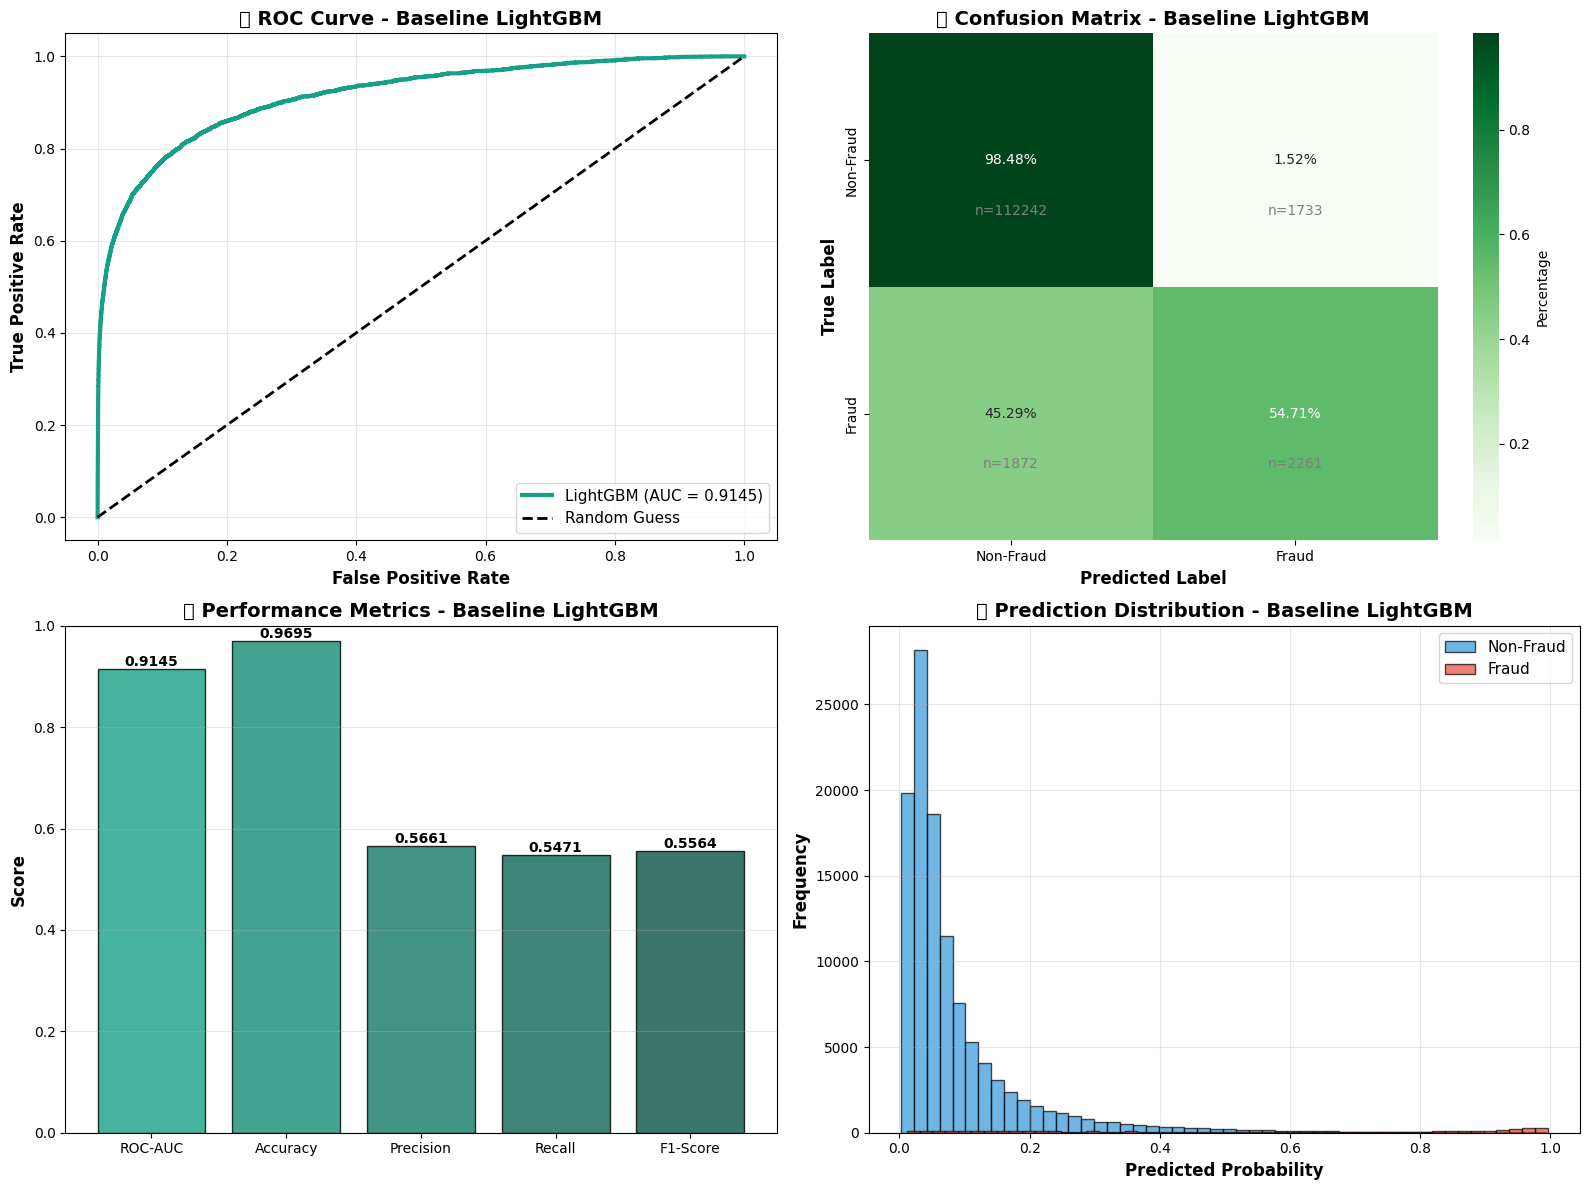


🎯 KEY INSIGHTS:
   Fraud Detection Rate: 54.71% (2261/4133 frauds caught)
   False Alarm Rate:     1.52% (1733/113975 false alarms)
   Number of Trees:      100
   Number of Leaves:     31

✅ Baseline LightGBM visualization completed!


In [41]:
# ===================================
# VISUALIZE BASELINE LIGHTGBM
# ===================================

print("\n📊 VISUALIZING BASELINE LIGHTGBM PERFORMANCE")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_val, y_val_pred_proba_lgbm)
roc_auc_lgbm = roc_auc_score(y_val, y_val_pred_proba_lgbm)

axes[0, 0].plot(fpr_lgbm, tpr_lgbm, color='#16A085', lw=3, 
                label=f'LightGBM (AUC = {roc_auc_lgbm:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('💡 ROC Curve - Baseline LightGBM', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. Confusion Matrix
cm_lgbm_normalized = cm_lgbm.astype('float') / cm_lgbm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_lgbm_normalized, annot=True, fmt='.2%', cmap='Greens', 
            cbar_kws={'label': 'Percentage'}, ax=axes[0, 1],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 1].set_title('💡 Confusion Matrix - Baseline LightGBM', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts
for i in range(2):
    for j in range(2):
        axes[0, 1].text(j+0.5, i+0.7, f'n={cm_lgbm[i,j]}', 
                       ha='center', va='center', fontsize=10, color='gray')

# 3. Metrics Bar Chart
metrics_names_lgbm = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values_lgbm = [val_roc_auc_lgbm, val_accuracy_lgbm, val_precision_lgbm, val_recall_lgbm, val_f1_lgbm]
colors_lgbm = ['#16A085', '#138D75', '#117A65', '#0E6655', '#0B5345']

bars_lgbm = axes[1, 0].bar(metrics_names_lgbm, metrics_values_lgbm, color=colors_lgbm, alpha=0.8, edgecolor='black')
axes[1, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('💡 Performance Metrics - Baseline LightGBM', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars_lgbm:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Prediction Distribution
axes[1, 1].hist(y_val_pred_proba_lgbm[y_val == 0], bins=50, alpha=0.7, 
               label='Non-Fraud', color='#3498DB', edgecolor='black')
axes[1, 1].hist(y_val_pred_proba_lgbm[y_val == 1], bins=50, alpha=0.7, 
               label='Fraud', color='#E74C3C', edgecolor='black')
axes[1, 1].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 1].set_title('💡 Prediction Distribution - Baseline LightGBM', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
fraud_detection_rate_lgbm = cm_lgbm[1, 1] / cm_lgbm[1].sum()
false_alarm_rate_lgbm = cm_lgbm[0, 1] / cm_lgbm[0].sum()

print(f"\n🎯 KEY INSIGHTS:")
print(f"   Fraud Detection Rate: {fraud_detection_rate_lgbm:.2%} ({cm_lgbm[1, 1]}/{cm_lgbm[1].sum()} frauds caught)")
print(f"   False Alarm Rate:     {false_alarm_rate_lgbm:.2%} ({cm_lgbm[0, 1]}/{cm_lgbm[0].sum()} false alarms)")
print(f"   Number of Trees:      {baseline_lgbm.n_estimators}")
print(f"   Number of Leaves:     {baseline_lgbm.num_leaves}")

print("\n✅ Baseline LightGBM visualization completed!")

## Tunning Hyper params 

In [ ]:
# ===================================
# LIGHTGBM - HYPERPARAMETER TUNING
# ===================================

print("🔧 Hyperparameter Tuning for LightGBM")
print("="*70)

param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20]
}

total_combinations_lgbm = (len(param_grid_lgbm['n_estimators']) * 
                           len(param_grid_lgbm['max_depth']) * 
                           len(param_grid_lgbm['learning_rate']) * 
                           len(param_grid_lgbm['num_leaves']) * 
                           len(param_grid_lgbm['min_child_samples']))

print(f"\n📋 Tuning Configuration:")
print(f"   - n_estimators: {param_grid_lgbm['n_estimators']}")
print(f"   - max_depth: {param_grid_lgbm['max_depth']}")
print(f"   - learning_rate: {param_grid_lgbm['learning_rate']}")
print(f"   - num_leaves: {param_grid_lgbm['num_leaves']}")
print(f"   - min_child_samples: {param_grid_lgbm['min_child_samples']}")
print(f"   - class_weight: balanced (fixed)")
print(f"   - Total combinations: {total_combinations_lgbm}")
print(f"   - CV folds: 3")
print(f"   - Total fits: {total_combinations_lgbm * 3}")

lgbm_tuning = lgb.LGBMClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True
)

grid_search_lgbm = GridSearchCV(
    estimator=lgbm_tuning,
    param_grid=param_grid_lgbm,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\n🔄 Starting Grid Search...")
start_time_lgbm = time.time()
grid_search_lgbm.fit(X_train_processed, y_train_processed)
elapsed_time_lgbm = time.time() - start_time_lgbm

print(f"\n✅ Grid Search completed in {elapsed_time_lgbm:.2f} seconds ({elapsed_time_lgbm/60:.2f} minutes)")

# Extract best parameters and score
best_lgbm_params = grid_search_lgbm.best_params_
best_lgbm_cv_score = grid_search_lgbm.best_score_

print(f"\n🏆 Best Parameters:")
for param, value in best_lgbm_params.items():
    print(f"   - {param}: {value}")

print(f"\n📊 Best Cross-Validation ROC-AUC: {best_lgbm_cv_score:.4f}")

# Train best model on full training set
print("\n🔄 Training best LightGBM on full training set...")
best_lgbm = lgb.LGBMClassifier(
    **best_lgbm_params,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True
)
best_lgbm.fit(X_train_processed, y_train_processed)
print("✅ Best model training completed!")

# Evaluate best model on validation set
print("\n🔮 Evaluating best LightGBM on validation set...")
y_val_pred_lgbm_best = best_lgbm.predict(X_val_processed)
y_val_pred_proba_lgbm_best = best_lgbm.predict_proba(X_val_processed)[:, 1]

val_roc_auc_lgbm_best = roc_auc_score(y_val, y_val_pred_proba_lgbm_best)
val_accuracy_lgbm_best = accuracy_score(y_val, y_val_pred_lgbm_best)
val_precision_lgbm_best = precision_score(y_val, y_val_pred_lgbm_best, zero_division=0)
val_recall_lgbm_best = recall_score(y_val, y_val_pred_lgbm_best, zero_division=0)
val_f1_lgbm_best = f1_score(y_val, y_val_pred_lgbm_best, zero_division=0)

print(f"\n📊 BEST LIGHTGBM PERFORMANCE:")
print(f"   ROC-AUC:   {val_roc_auc_lgbm_best:.4f}")
print(f"   Accuracy:  {val_accuracy_lgbm_best:.4f}")
print(f"   Precision: {val_precision_lgbm_best:.4f}")
print(f"   Recall:    {val_recall_lgbm_best:.4f}")
print(f"   F1-Score:  {val_f1_lgbm_best:.4f}")

# Compare with baseline
improvement_lgbm = ((val_roc_auc_lgbm_best - val_roc_auc_lgbm) / val_roc_auc_lgbm) * 100
print(f"\n📈 Improvement over baseline: {improvement_lgbm:+.2f}%")

# Store results in DataFrame for analysis
cv_results_lgbm = pd.DataFrame(grid_search_lgbm.cv_results_)
cv_results_lgbm = cv_results_lgbm.sort_values('rank_test_score')

print("\n🔝 Top 10 Parameter Combinations:")
top_10_lgbm = cv_results_lgbm[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)
for idx, row in top_10_lgbm.iterrows():
    print(f"\n   Rank {int(row['rank_test_score'])}:")
    print(f"   Params: {row['params']}")
    print(f"   Mean ROC-AUC: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")

print("\n✅ Hyperparameter tuning completed!")

🔧 Hyperparameter Tuning for LightGBM

📋 Tuning Configuration:
   - n_estimators: [50, 100, 200]
   - max_depth: [3, 6, 10]
   - learning_rate: [0.01, 0.1, 0.3]
   - num_leaves: [15, 31, 63]
   - min_child_samples: [10, 20]
   - class_weight: balanced (fixed)
   - Total combinations: 162
   - CV folds: 3
   - Total fits: 486

🔄 Starting Grid Search...
Fitting 3 folds for each of 162 candidates, totalling 486 fits


In [ ]:
# ===================================
# LIGHTGBM - COMPARISON VISUALIZATION
# ===================================

# Prepare baseline metrics for comparison
baseline_metrics_lgbm = {
    'ROC-AUC': val_roc_auc_lgbm,
    'Accuracy': val_accuracy_lgbm,
    'Precision': val_precision_lgbm,
    'Recall': val_recall_lgbm,
    'F1-Score': val_f1_lgbm
}

# Prepare tuned metrics
tuned_metrics_lgbm = {
    'ROC-AUC': val_roc_auc_lgbm_best,
    'Accuracy': val_accuracy_lgbm_best,
    'Precision': val_precision_lgbm_best,
    'Recall': val_recall_lgbm_best,
    'F1-Score': val_f1_lgbm_best
}

# Create comprehensive comparison visualization
fig = plt.figure(figsize=(20, 12))

# 1. ROC Curves Comparison
ax1 = plt.subplot(2, 3, 1)
fpr_baseline, tpr_baseline, _ = roc_curve(y_val, y_val_pred_proba_lgbm)
fpr_tuned, tpr_tuned, _ = roc_curve(y_val, y_val_pred_proba_lgbm_best)

plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC = {val_roc_auc_lgbm:.3f})', 
         linewidth=2.5, color='#FF6B6B')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned (AUC = {val_roc_auc_lgbm_best:.3f})', 
         linewidth=2.5, color='#4ECDC4')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random', alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=11, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=11, fontweight='bold')
plt.title('🎯 ROC Curves: Baseline vs Tuned', fontsize=13, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)

# 2. Metrics Bar Comparison
ax2 = plt.subplot(2, 3, 2)
metrics = list(baseline_metrics_lgbm.keys())
baseline_values = list(baseline_metrics_lgbm.values())
tuned_values = list(tuned_metrics_lgbm.values())

x = np.arange(len(metrics))
width = 0.35

bars1 = plt.bar(x - width/2, baseline_values, width, label='Baseline', 
                color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.2)
bars2 = plt.bar(x + width/2, tuned_values, width, label='Tuned', 
                color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.2)

plt.xlabel('Metrics', fontsize=11, fontweight='bold')
plt.ylabel('Score', fontsize=11, fontweight='bold')
plt.title('📊 All Metrics Comparison', fontsize=13, fontweight='bold', pad=15)
plt.xticks(x, metrics, rotation=45, ha='right')
plt.legend(fontsize=10)
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 3. Confusion Matrix - Baseline
ax3 = plt.subplot(2, 3, 3)
cm_baseline = confusion_matrix(y_val, y_val_pred_lgbm)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'},
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'],
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
plt.title('📋 Confusion Matrix - Baseline', fontsize=13, fontweight='bold', pad=15)
plt.ylabel('True Label', fontsize=11, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=11, fontweight='bold')

# 4. Confusion Matrix - Tuned
ax4 = plt.subplot(2, 3, 4)
cm_tuned = confusion_matrix(y_val, y_val_pred_lgbm_best)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', cbar_kws={'label': 'Count'},
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'],
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
plt.title('📋 Confusion Matrix - Tuned', fontsize=13, fontweight='bold', pad=15)
plt.ylabel('True Label', fontsize=11, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=11, fontweight='bold')

# 5. Improvement Percentage
ax5 = plt.subplot(2, 3, 5)
improvements = [(tuned_values[i] - baseline_values[i]) / baseline_values[i] * 100 
                for i in range(len(metrics))]
colors = ['#2ECC71' if imp > 0 else '#E74C3C' for imp in improvements]

bars = plt.barh(metrics, improvements, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
plt.xlabel('Improvement (%)', fontsize=11, fontweight='bold')
plt.title('📈 Percentage Improvement', fontsize=13, fontweight='bold', pad=15)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
plt.grid(True, alpha=0.3, axis='x')

for i, (bar, imp) in enumerate(zip(bars, improvements)):
    plt.text(imp, i, f'{imp:+.2f}%', va='center', 
             ha='left' if imp > 0 else 'right', fontsize=9, fontweight='bold')

# 6. Top 10 Hyperparameter Combinations
ax6 = plt.subplot(2, 3, 6)
top_10_scores = cv_results_lgbm.head(10)['mean_test_score'].values
top_10_ranks = range(1, 11)

plt.barh(top_10_ranks, top_10_scores, color=plt.cm.viridis(np.linspace(0.3, 0.9, 10)),
         alpha=0.8, edgecolor='black', linewidth=1.2)
plt.xlabel('Mean CV ROC-AUC', fontsize=11, fontweight='bold')
plt.ylabel('Rank', fontsize=11, fontweight='bold')
plt.title('🏆 Top 10 Parameter Combinations', fontsize=13, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

for i, (rank, score) in enumerate(zip(top_10_ranks, top_10_scores)):
    plt.text(score, rank, f'{score:.4f}', va='center', ha='left', 
             fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('lightgbm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*70)
print("📊 LIGHTGBM: BASELINE vs TUNED COMPARISON")
print("="*70)
print("\n🎯 BASELINE MODEL:")
for metric, value in baseline_metrics_lgbm.items():
    print(f"   {metric:12s}: {value:.4f}")

print("\n🏆 TUNED MODEL:")
for metric, value in tuned_metrics_lgbm.items():
    print(f"   {metric:12s}: {value:.4f}")

print("\n📈 IMPROVEMENTS:")
for metric in metrics:
    baseline_val = baseline_metrics_lgbm[metric]
    tuned_val = tuned_metrics_lgbm[metric]
    improvement = ((tuned_val - baseline_val) / baseline_val) * 100
    arrow = "📈" if improvement > 0 else "📉"
    print(f"   {arrow} {metric:12s}: {improvement:+.2f}%")

print("\n🎯 BEST PARAMETERS:")
for param, value in best_lgbm_params.items():
    print(f"   {param:20s}: {value}")

# Select best model
if val_roc_auc_lgbm_best > val_roc_auc_lgbm:
    best_lgbm_model = best_lgbm
    print("\n✅ Tuned model selected as best (higher ROC-AUC)")
else:
    best_lgbm_model = baseline_lgbm
    print("\n✅ Baseline model selected as best (higher ROC-AUC)")

print("="*70)

## Test evaluation 

In [ ]:
# ===================================
# LIGHTGBM - TEST SET EVALUATION
# ===================================

print("🧪 LightGBM - Testing on Hold-out Test Set")
print("="*70)

# Make predictions on test set
y_test_pred_lgbm = best_lgbm_model.predict(X_test_processed)
y_test_pred_proba_lgbm = best_lgbm_model.predict_proba(X_test_processed)[:, 1]

# Calculate metrics
test_roc_auc_lgbm = roc_auc_score(y_test, y_test_pred_proba_lgbm)
test_accuracy_lgbm = accuracy_score(y_test, y_test_pred_lgbm)
test_precision_lgbm = precision_score(y_test, y_test_pred_lgbm, zero_division=0)
test_recall_lgbm = recall_score(y_test, y_test_pred_lgbm, zero_division=0)
test_f1_lgbm = f1_score(y_test, y_test_pred_lgbm, zero_division=0)

# Confusion matrix
cm_test_lgbm = confusion_matrix(y_test, y_test_pred_lgbm)
tn, fp, fn, tp = cm_test_lgbm.ravel()

# Additional metrics
test_fraud_detection_rate_lgbm = tp / (tp + fn) if (tp + fn) > 0 else 0
test_false_alarm_rate_lgbm = fp / (fp + tn) if (fp + tn) > 0 else 0

# Store results
test_lgbm_results = {
    'roc_auc': test_roc_auc_lgbm,
    'accuracy': test_accuracy_lgbm,
    'precision': test_precision_lgbm,
    'recall': test_recall_lgbm,
    'f1': test_f1_lgbm,
    'fraud_detection_rate': test_fraud_detection_rate_lgbm,
    'false_alarm_rate': test_false_alarm_rate_lgbm,
    'confusion_matrix': cm_test_lgbm,
    'tp': tp,
    'tn': tn,
    'fp': fp,
    'fn': fn
}

print("\n📊 TEST SET PERFORMANCE:")
print(f"   ROC-AUC:              {test_roc_auc_lgbm:.4f}")
print(f"   Accuracy:             {test_accuracy_lgbm:.4f}")
print(f"   Precision:            {test_precision_lgbm:.4f}")
print(f"   Recall:               {test_recall_lgbm:.4f}")
print(f"   F1-Score:             {test_f1_lgbm:.4f}")
print(f"   Fraud Detection Rate: {test_fraud_detection_rate_lgbm:.4f}")
print(f"   False Alarm Rate:     {test_false_alarm_rate_lgbm:.4f}")

print("\n📋 CONFUSION MATRIX:")
print(f"   True Negatives:  {tn:6d}")
print(f"   False Positives: {fp:6d}")
print(f"   False Negatives: {fn:6d}")
print(f"   True Positives:  {tp:6d}")

print("\n🎯 BUSINESS METRICS:")
total_fraud = tp + fn
total_non_fraud = tn + fp
print(f"   Total Frauds:     {total_fraud:6d}")
print(f"   Frauds Detected:  {tp:6d} ({test_fraud_detection_rate_lgbm*100:.2f}%)")
print(f"   Frauds Missed:    {fn:6d} ({(fn/total_fraud*100) if total_fraud > 0 else 0:.2f}%)")
print(f"   False Alarms:     {fp:6d} ({test_false_alarm_rate_lgbm*100:.2f}%)")

print("\n✅ Test evaluation completed!")
print("="*70)

In [ ]:
# ===================================
# LIGHTGBM - TEST RESULTS VISUALIZATION
# ===================================

fig = plt.figure(figsize=(20, 12))

# 1. ROC Curve on Test Set
ax1 = plt.subplot(2, 3, 1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_proba_lgbm)
plt.plot(fpr_test, tpr_test, linewidth=3, label=f'LightGBM (AUC = {test_roc_auc_lgbm:.3f})', 
         color='#8E44AD')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier', alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('🎯 ROC Curve - Test Set', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.fill_between(fpr_test, tpr_test, alpha=0.2, color='#8E44AD')

# 2. Confusion Matrix
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm_test_lgbm, annot=True, fmt='d', cmap='Purples', 
            cbar_kws={'label': 'Count'},
            xticklabels=['Non-Fraud (0)', 'Fraud (1)'], 
            yticklabels=['Non-Fraud (0)', 'Fraud (1)'],
            annot_kws={'fontsize': 13, 'fontweight': 'bold'})
plt.title('📋 Confusion Matrix - Test Set', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add percentages
for i in range(2):
    for j in range(2):
        value = cm_test_lgbm[i, j]
        total = cm_test_lgbm.sum()
        percentage = (value / total) * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='darkblue')

# 3. Metrics Bar Chart
ax3 = plt.subplot(2, 3, 3)
test_metrics = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
test_values = [test_roc_auc_lgbm, test_accuracy_lgbm, test_precision_lgbm, 
               test_recall_lgbm, test_f1_lgbm]

bars = plt.bar(test_metrics, test_values, color=['#8E44AD', '#3498DB', '#E74C3C', '#2ECC71', '#F39C12'],
               alpha=0.8, edgecolor='black', linewidth=1.5)
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('📊 Test Set Metrics', fontsize=14, fontweight='bold', pad=15)
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, test_values):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.02, f'{value:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Prediction Distribution
ax4 = plt.subplot(2, 3, 4)
plt.hist(y_test_pred_proba_lgbm[y_test == 0], bins=50, alpha=0.7, label='Non-Fraud (Actual)', 
         color='#3498DB', edgecolor='black')
plt.hist(y_test_pred_proba_lgbm[y_test == 1], bins=50, alpha=0.7, label='Fraud (Actual)', 
         color='#E74C3C', edgecolor='black')
plt.xlabel('Predicted Probability', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('📈 Prediction Probability Distribution', fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold = 0.5')

# 5. Business Impact Metrics
ax5 = plt.subplot(2, 3, 5)
business_metrics = ['Fraud\nDetection\nRate', 'False\nAlarm\nRate']
business_values = [test_fraud_detection_rate_lgbm, test_false_alarm_rate_lgbm]
colors_business = ['#2ECC71', '#E74C3C']

bars = plt.bar(business_metrics, business_values, color=colors_business, alpha=0.8, 
               edgecolor='black', linewidth=1.5)
plt.ylabel('Rate', fontsize=12, fontweight='bold')
plt.title('💼 Business Impact Metrics', fontsize=14, fontweight='bold', pad=15)
plt.ylim(0, max(business_values) * 1.2)
plt.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, business_values):
    plt.text(bar.get_x() + bar.get_width()/2, value + max(business_values)*0.02, 
             f'{value:.3f}\n({value*100:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 6. Feature Importance (Top 15)
ax6 = plt.subplot(2, 3, 6)
feature_importance = best_lgbm_model.feature_importances_
feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(15)

plt.barh(range(len(importance_df)), importance_df['importance'], 
         color=plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df))),
         alpha=0.8, edgecolor='black', linewidth=1.2)
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.title('🌟 Top 15 Feature Importances', fontsize=14, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('lightgbm_test_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("📊 LIGHTGBM TEST RESULTS SUMMARY")
print("="*70)
print("\n🎯 Classification Metrics:")
print(f"   ROC-AUC:   {test_roc_auc_lgbm:.4f}")
print(f"   Accuracy:  {test_accuracy_lgbm:.4f}")
print(f"   Precision: {test_precision_lgbm:.4f}")
print(f"   Recall:    {test_recall_lgbm:.4f}")
print(f"   F1-Score:  {test_f1_lgbm:.4f}")

print("\n💼 Business Metrics:")
print(f"   Fraud Detection Rate: {test_fraud_detection_rate_lgbm:.4f} ({test_fraud_detection_rate_lgbm*100:.2f}%)")
print(f"   False Alarm Rate:     {test_false_alarm_rate_lgbm:.4f} ({test_false_alarm_rate_lgbm*100:.2f}%)")

print("\n📋 Confusion Matrix Breakdown:")
print(f"   True Negatives:  {tn:6d} (Correct Non-Fraud predictions)")
print(f"   False Positives: {fp:6d} (Non-Fraud predicted as Fraud)")
print(f"   False Negatives: {fn:6d} (Fraud predicted as Non-Fraud)")
print(f"   True Positives:  {tp:6d} (Correct Fraud predictions)")

print("\n✅ LightGBM evaluation completed successfully!")
print("="*70)